In [65]:
import importlib

import joblib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

from Utils import paths, common_functions
from Utils import transformation_utils as t_utils

importlib.reload(paths)
importlib.reload(common_functions)

<module 'Utils.common_functions' from 'C:\\Users\\jllav\\IdeaProjects\\TFM\\Utils\\common_functions.py'>

In [66]:
xlabel_font_size = 20
both_ticks_label_size = 15
legend_font_size = 15

COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

In [67]:
# Cargamos los datos originales
fhr = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/fhr_ctu-chb.pickle")
uc = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/uc_ctu-chb.pickle")
clinical = pd.read_pickle(f"{paths.ORIGINAL_DATA_PATH}/clinical_ctu-chb.pickle")

fhr.columns = fhr.columns.astype('float64')
uc.columns = uc.columns.astype('float64')

# Labels
y = clinical['ph'].apply(lambda x: 0 if x >= 7.2 else 1)

fhr.shape, uc.shape, clinical.shape

((552, 21620), (552, 21620), (552, 17))

In [195]:
fhr_clean_statistics = pd.DataFrame([], columns=['zeros', 'extreme', 'cons', 'cons_no_zero', 'num_cons'], dtype='int64')
uc_clean_statistics = pd.DataFrame([], columns=['zeros', 'cons', 'cons_no_zero'], dtype='int64')

In [202]:
threshold = 5 * 4  # 5 segundos 4 Hz

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr.copy().iterrows(), uc.copy().iterrows()), total=len(fhr)):
    len_0 = fhr_row[fhr_row <= 0].shape[0]
    len_250 = fhr_row[fhr_row >= 250].shape[0]

    constant_parts_fhr = [x for x in np.split(fhr_row.index, np.where(np.diff(fhr_row.values) != 0)[0] + 1) if
                          x.size > threshold]
    len_cons = 0
    len_cons_no_zero = 0
    num_cons = 0
    for constant_part in constant_parts_fhr:
        len_cons += len(constant_part)
        if fhr_row[constant_part.values[0]] != 0:
            len_cons_no_zero += len(constant_part)
            num_cons += 1
    fhr_clean_statistics.loc[idx_fhr] = pd.Series({
        'zeros': len_0,
        'extreme': len_250,
        'cons': len_cons,
        'cons_no_zero': len_cons_no_zero,
        'num_cons': num_cons
    })

    len_0 = uc_row[fhr_row <= 0].shape[0]

    constant_parts_uc = [x for x in np.split(uc_row.index, np.where(np.diff(uc_row.values) != 0)[0] + 1) if
                         x.size > threshold]
    len_cons = 0
    len_cons_no_zero = 0
    for constant_part in constant_parts_uc:
        len_cons += len(constant_part)
        if uc_row[constant_part.values[0]] != 0:
            len_cons_no_zero += len(constant_part)

    uc_clean_statistics.loc[idx_fhr] = pd.Series({
        'zeros': len_0,
        'cons': len_cons,
        'cons_no_zero': len_cons_no_zero
    })



  0%|          | 0/552 [00:00<?, ?it/s]

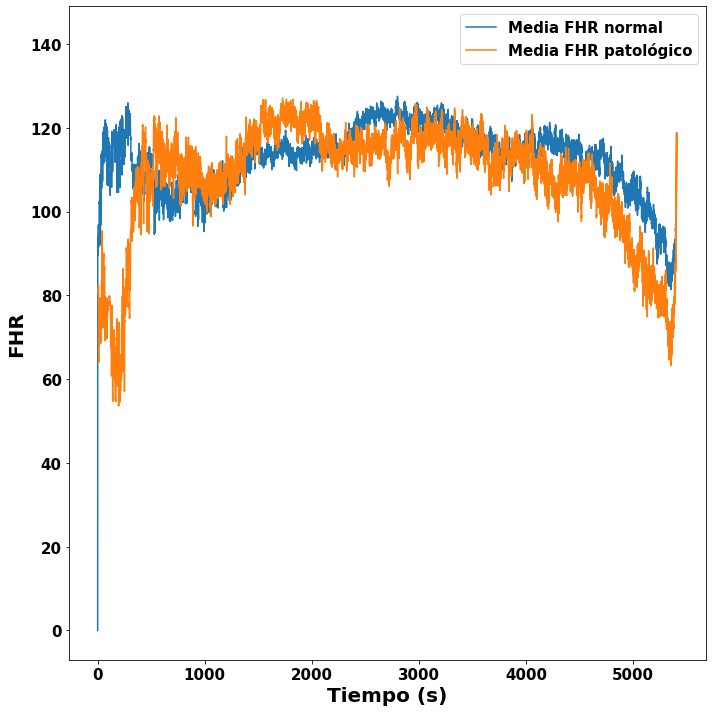

In [272]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.plot(fhr[y == 0].mean().index, fhr[y == 0].mean().values, label='Media FHR normal')
ax.plot(fhr[y == 1].mean().index, fhr[y == 1].mean().values, label='Media FHR patológico')

ax.set_xlabel('Tiempo (s)', fontsize=xlabel_font_size)
ax.set_ylabel('FHR', fontsize=xlabel_font_size)
ax.tick_params(axis='both', which='major', labelsize=both_ticks_label_size)

ax.legend(fontsize=legend_font_size)
ax.set_ylim((-7, 149))

fig.tight_layout()
plt.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_FHR_original_description.pdf")

(2.0, 57.0)

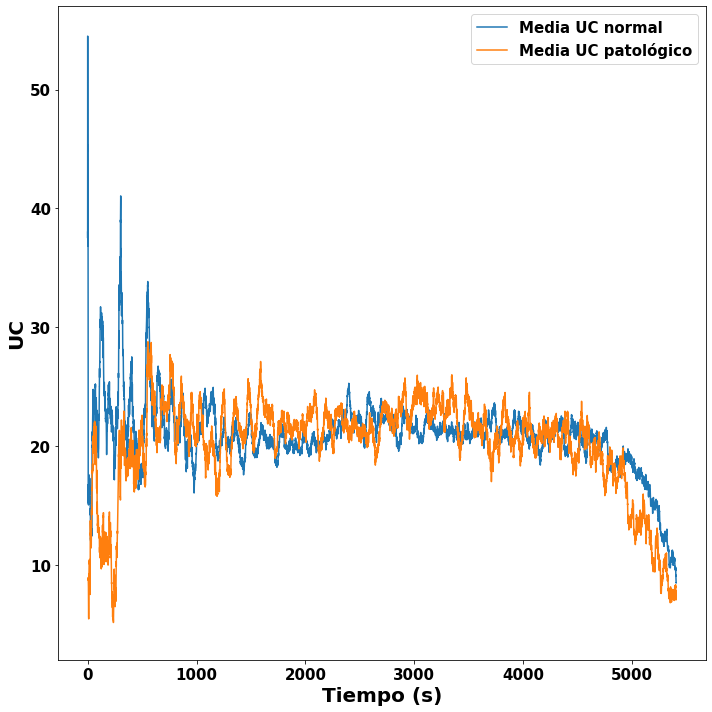

In [275]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.plot(uc[y == 0].mean().index, uc[y == 0].mean().values, label='Media UC normal')
ax.plot(uc[y == 1].mean().index, uc[y == 1].mean().values, label='Media UC patológico')

ax.set_xlabel('Tiempo (s)', fontsize=xlabel_font_size)
ax.set_ylabel('UC', fontsize=xlabel_font_size)
ax.tick_params(axis='both', which='major', labelsize=both_ticks_label_size)

ax.legend(fontsize=legend_font_size)
ax.set_ylim(2, 57)

fig.tight_layout()
plt.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_UC_original_description.pdf")
ax.get_ylim()

In [68]:
fhr_clean = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/fhr.pickle")
uc_clean = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/uc.pickle")
y_clean = pd.read_pickle(f"{paths.CLEAN_DATA_PATH}/y.pickle")

fhr_clean.shape, uc_clean.shape, y_clean.shape

((552, 21620), (552, 21620), (552,))

In [260]:
shadow_uc = uc.copy()
shadow_uc[~uc_clean.isna()] = np.nan

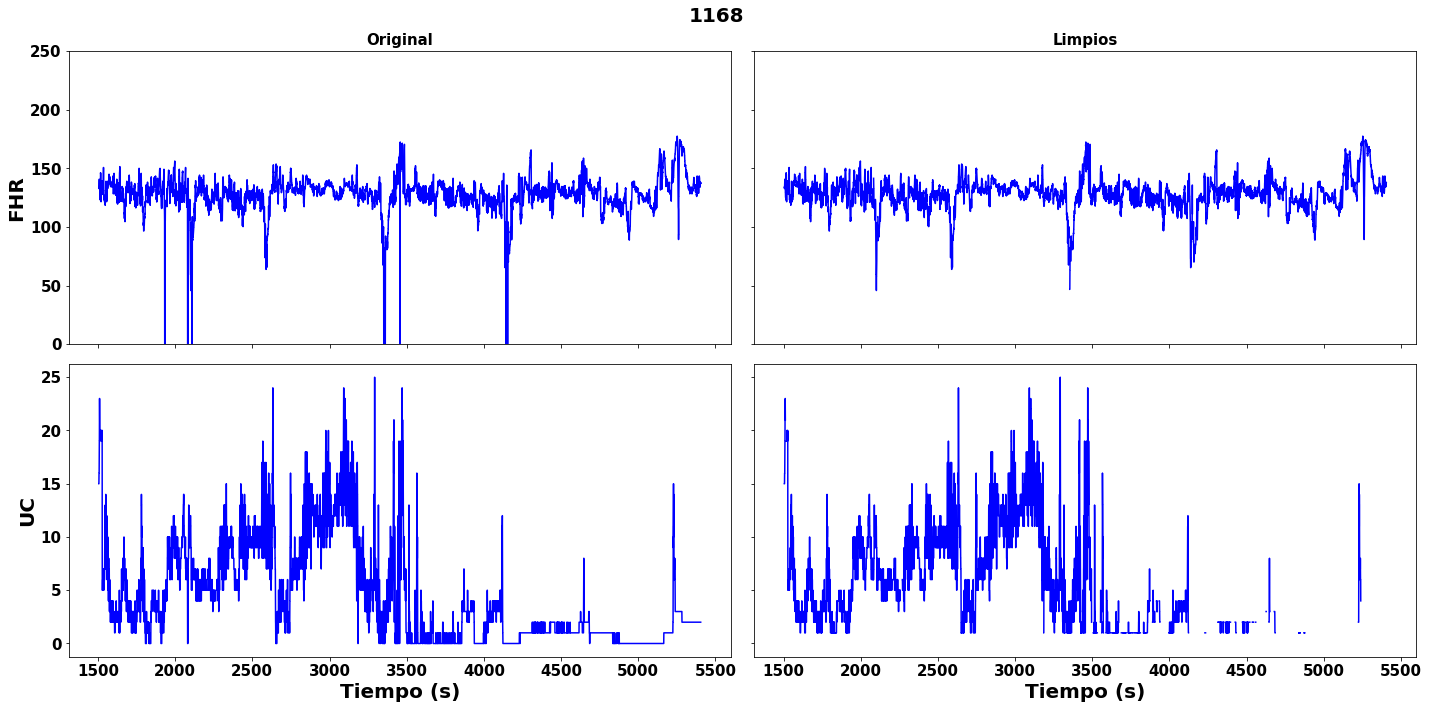

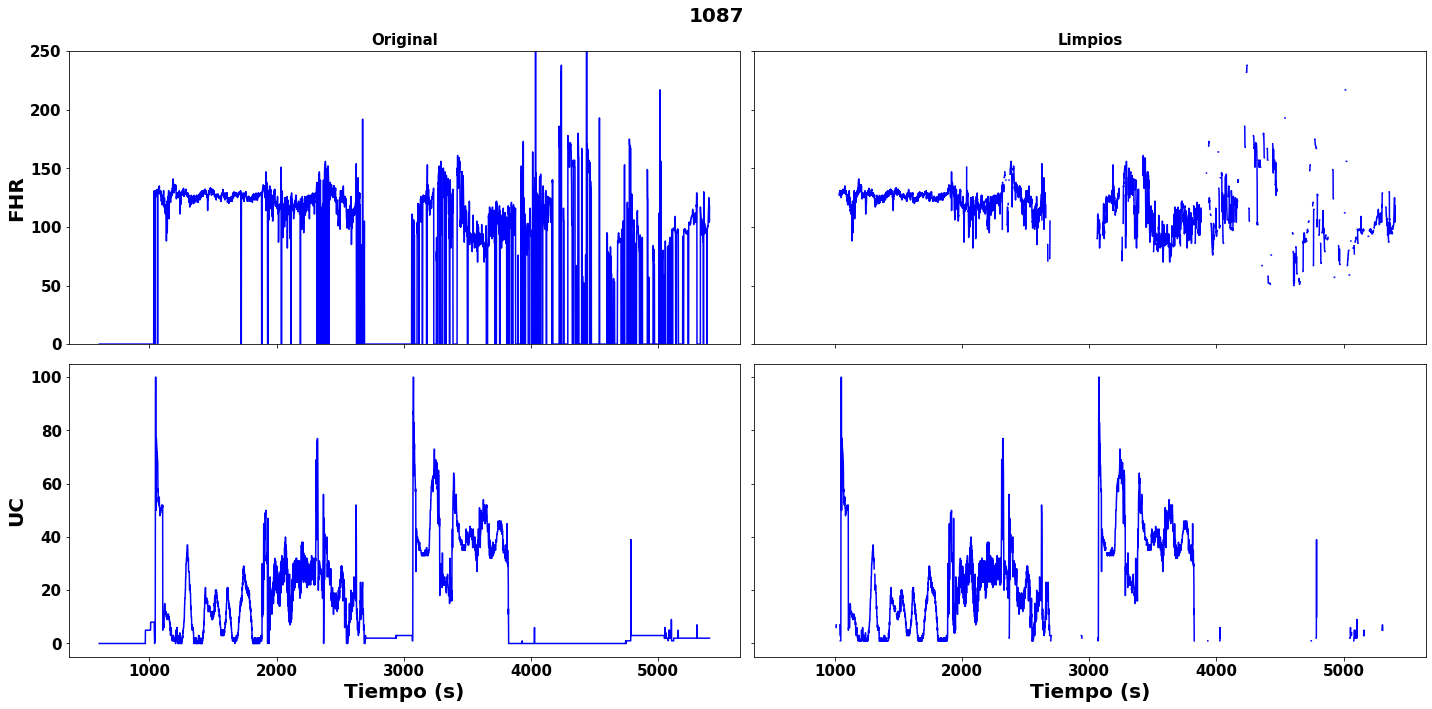

In [262]:
for idx in [1168, 1087]:
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex='all', sharey='row', figsize=(20, 10))
    color = 'blue'

    ax[0, 0].plot(fhr.loc[idx].index, fhr.loc[idx].values, color=color)
    ax[0, 1].plot(fhr_clean.loc[idx].index, fhr_clean.loc[idx].values, color=color)
    for fhr_ax in ax[0]:
        fhr_ax.set_ylim((0, 250))

    ax[1, 0].plot(uc.loc[idx].index, uc.loc[idx].values, color=color)
    ax[1, 1].plot(uc_clean.loc[idx].index, uc_clean.loc[idx].values, color=color)
    # ax[1, 1].plot(shadow_uc.loc[idx].index, shadow_uc.loc[idx].values, color='red')
    for uc_ax in ax[0]:
        uc_ax.set_ylim((0, 250))

    ax[1, 0].set_xlabel('Tiempo (s)', fontsize=xlabel_font_size)
    ax[1, 1].set_xlabel('Tiempo (s)', fontsize=xlabel_font_size)
    ax[0, 0].set_ylabel('FHR', fontsize=xlabel_font_size)
    ax[1, 0].set_ylabel('UC', fontsize=xlabel_font_size)

    ax[0, 0].tick_params(axis='both', which='major', labelsize=both_ticks_label_size)
    ax[1, 0].tick_params(axis='both', which='major', labelsize=both_ticks_label_size)
    ax[1, 1].tick_params(axis='both', which='major', labelsize=both_ticks_label_size)

    ax[0, 0].set_title('Original', fontsize=legend_font_size)
    ax[0, 1].set_title('Limpios', fontsize=legend_font_size)

    fig.suptitle(f'{idx}', fontsize=xlabel_font_size)
    fig.tight_layout()
    fig.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_{idx}_clean_process.pdf")
    plt.show()

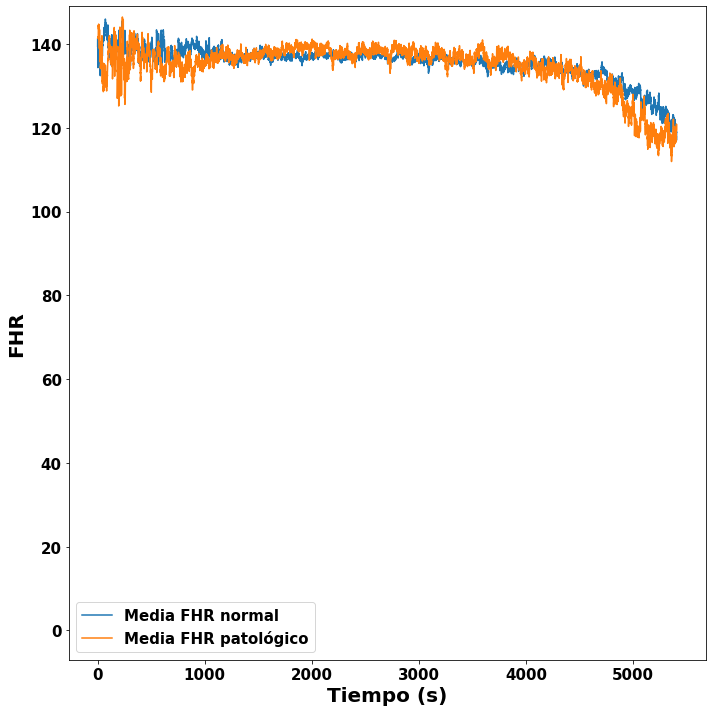

In [271]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.plot(fhr_clean[y_clean == 0].mean().index, fhr_clean[y_clean == 0].mean().values, label='Media FHR normal')
ax.plot(fhr_clean[y_clean == 1].mean().index, fhr_clean[y_clean == 1].mean().values, label='Media FHR patológico')

ax.set_xlabel('Tiempo (s)', fontsize=xlabel_font_size)
ax.set_ylabel('FHR', fontsize=xlabel_font_size)

ax.tick_params(axis='both', which='major', labelsize=both_ticks_label_size)

ax.legend(fontsize=legend_font_size)
ax.set_ylim((-7, 149))

fig.tight_layout()
plt.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_FHR_clean_description.pdf")

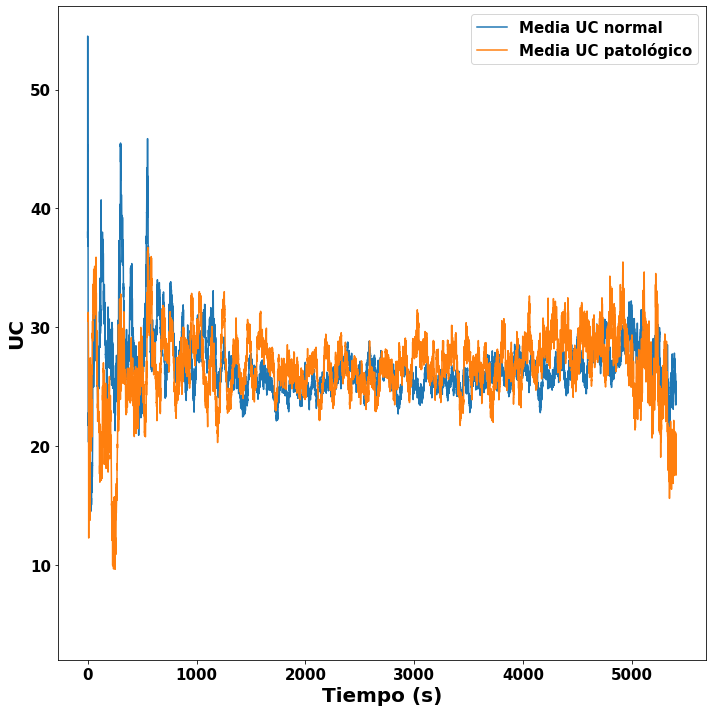

In [276]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

ax.plot(uc_clean[y_clean == 0].mean().index, uc_clean[y_clean == 0].mean().values, label='Media UC normal')
ax.plot(uc_clean[y_clean == 1].mean().index, uc_clean[y_clean == 1].mean().values, label='Media UC patológico')

ax.set_xlabel('Tiempo (s)', fontsize=xlabel_font_size)
ax.set_ylabel('UC', fontsize=xlabel_font_size)
ax.tick_params(axis='both', which='major', labelsize=both_ticks_label_size)

ax.legend(fontsize=legend_font_size)
ax.set_ylim(2, 57)

fig.tight_layout()
plt.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_UC_clean_description.pdf")

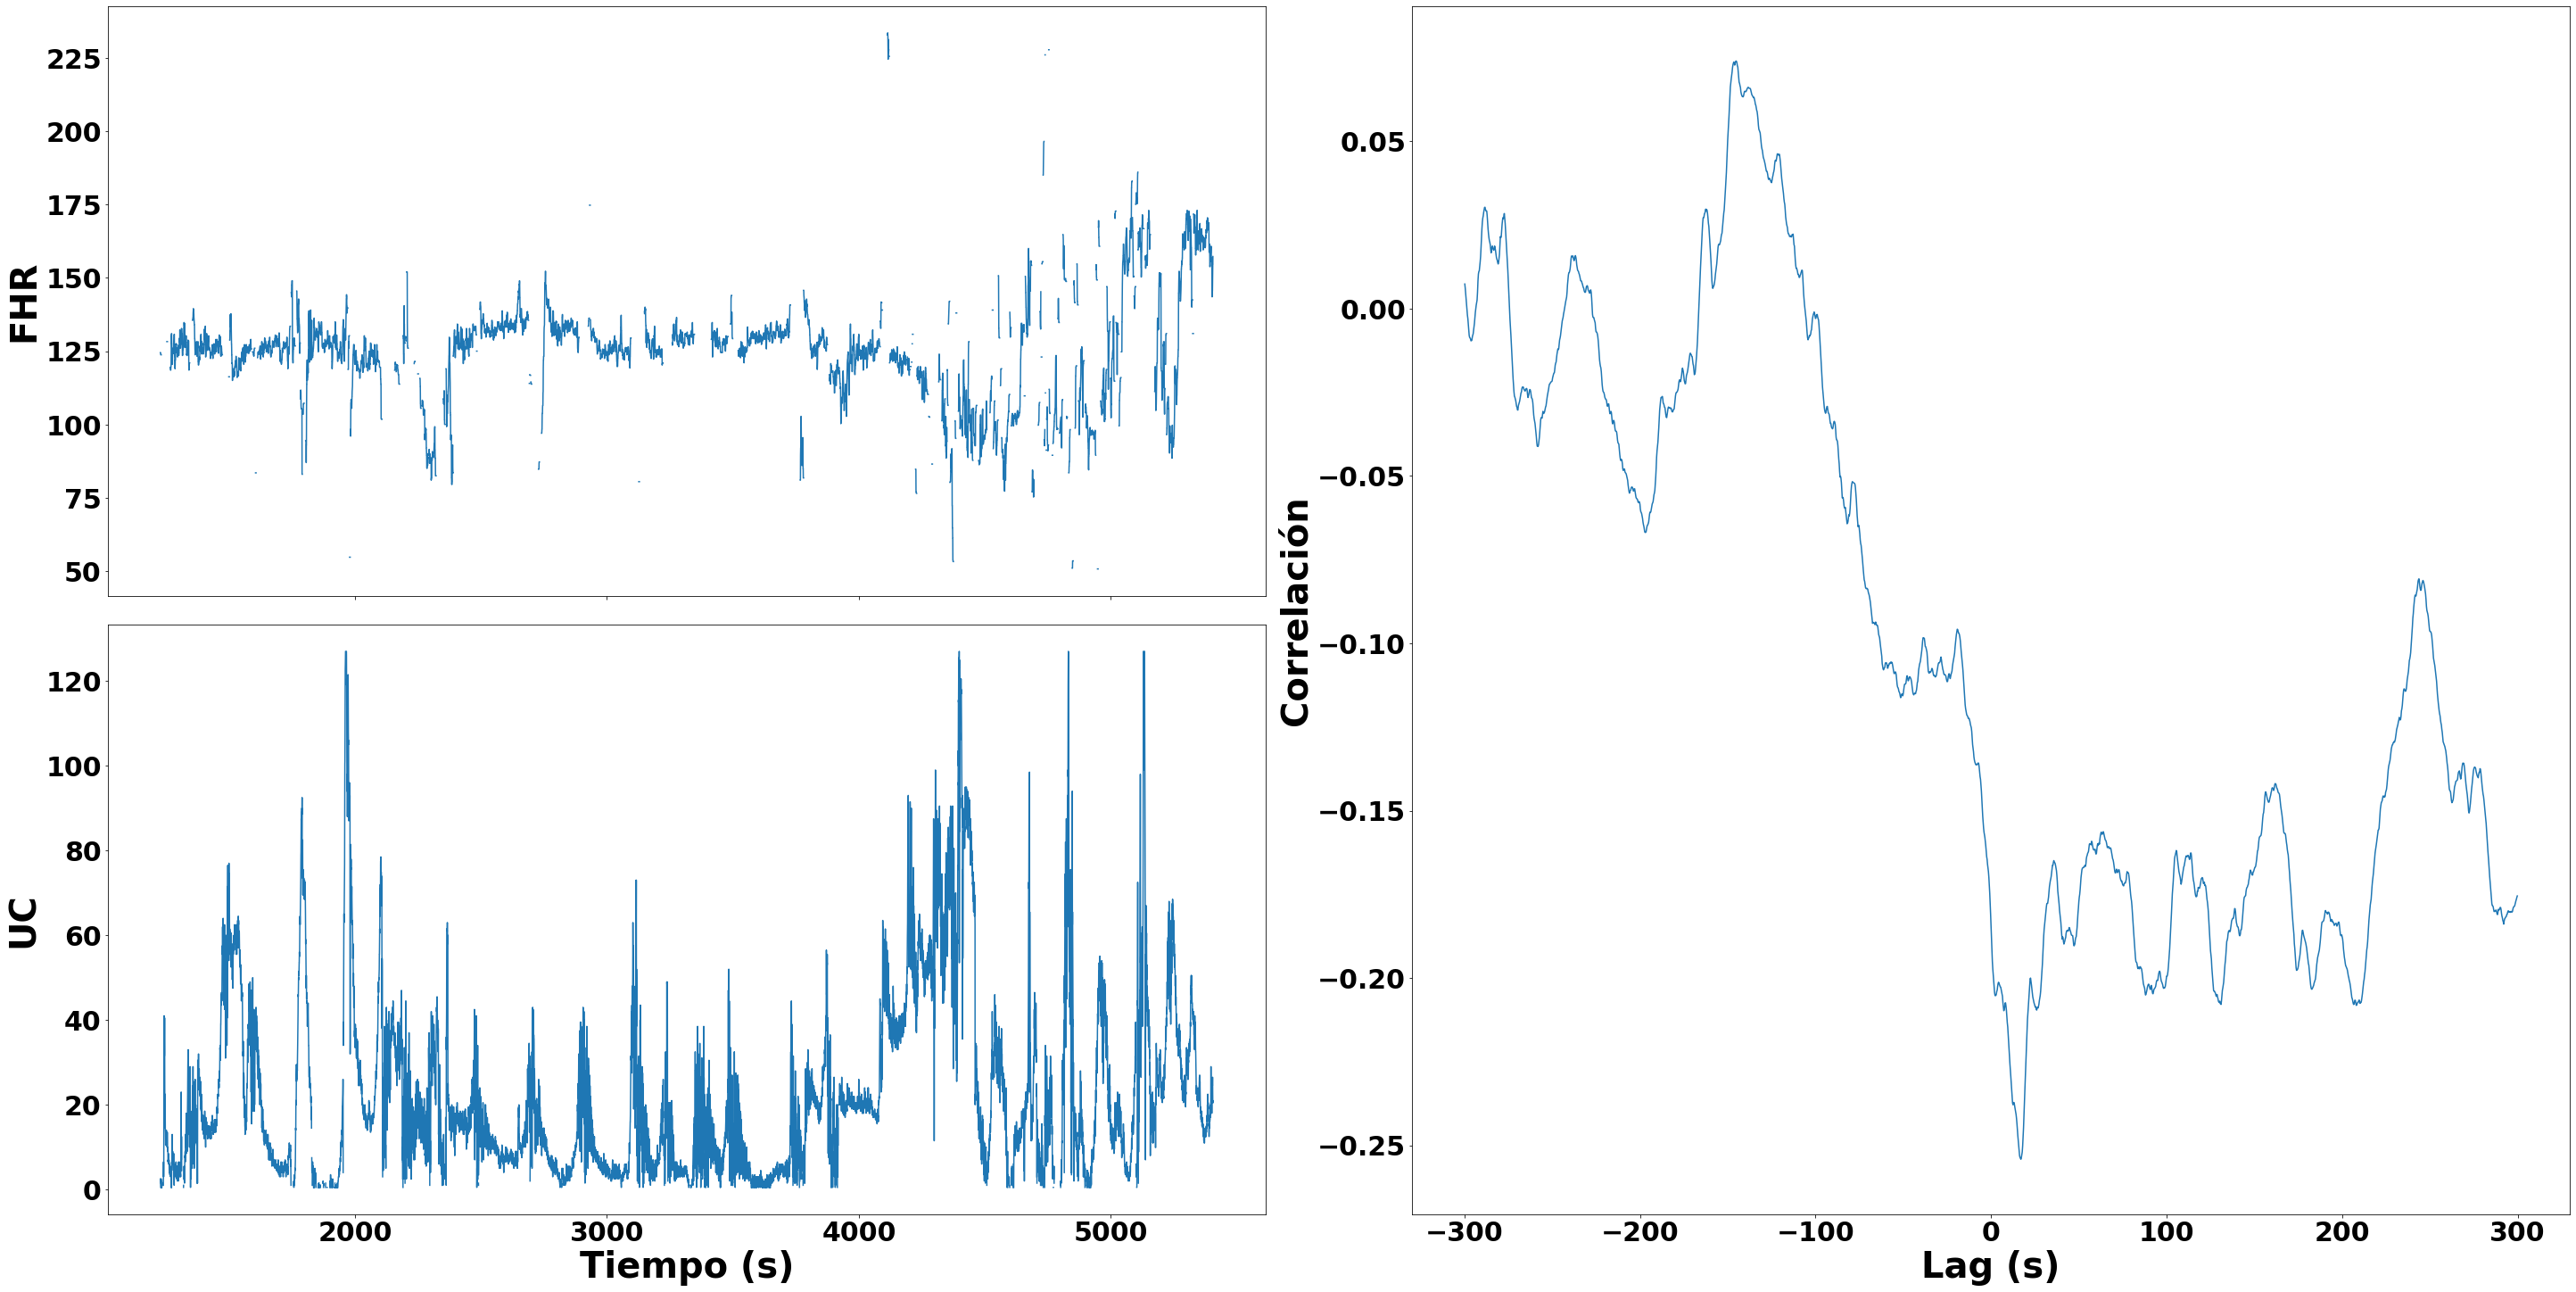

In [309]:
idx = 2043
lags = t_utils.calc_lags(minutes=5)
fhr_signal = fhr_clean.loc[idx]
uc_signal = uc_clean.loc[idx]
y_signal = y_clean.loc[idx]
cc_transformation = joblib.Parallel(n_jobs=8)(
    joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, 3000) for lag in lags
)

cc_signal = pd.Series(cc_transformation, index=lags)

axd = plt.figure(constrained_layout=True, figsize=(40, 20)).subplot_mosaic(
    """
    AACC
    BBCC
    """
)

axd['A'].plot(fhr_signal.index, fhr_signal.values)
axd['B'].plot(uc_signal.index, uc_signal.values)
axd['C'].plot(cc_signal.index / 4, cc_signal.values)

factor_label_font_size = 2
axd['B'].set_xlabel('Tiempo (s)', fontsize=xlabel_font_size * factor_label_font_size)
axd['C'].set_xlabel("Lag (s)", fontsize=xlabel_font_size * factor_label_font_size)
axd['A'].get_shared_x_axes().join(axd['A'], axd['B'])
axd['A'].set_xticklabels([])

axd['A'].set_ylabel('FHR', fontsize=xlabel_font_size * factor_label_font_size)
axd['B'].set_ylabel('UC', fontsize=xlabel_font_size * factor_label_font_size)
axd['C'].set_ylabel('Correlación', fontsize=xlabel_font_size * factor_label_font_size)

factor_both_ticks_label_size = 2
axd['A'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)
axd['B'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)
axd['C'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)

fig = plt.gcf()
fig.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_{idx}_CC_ejemplo.pdf")

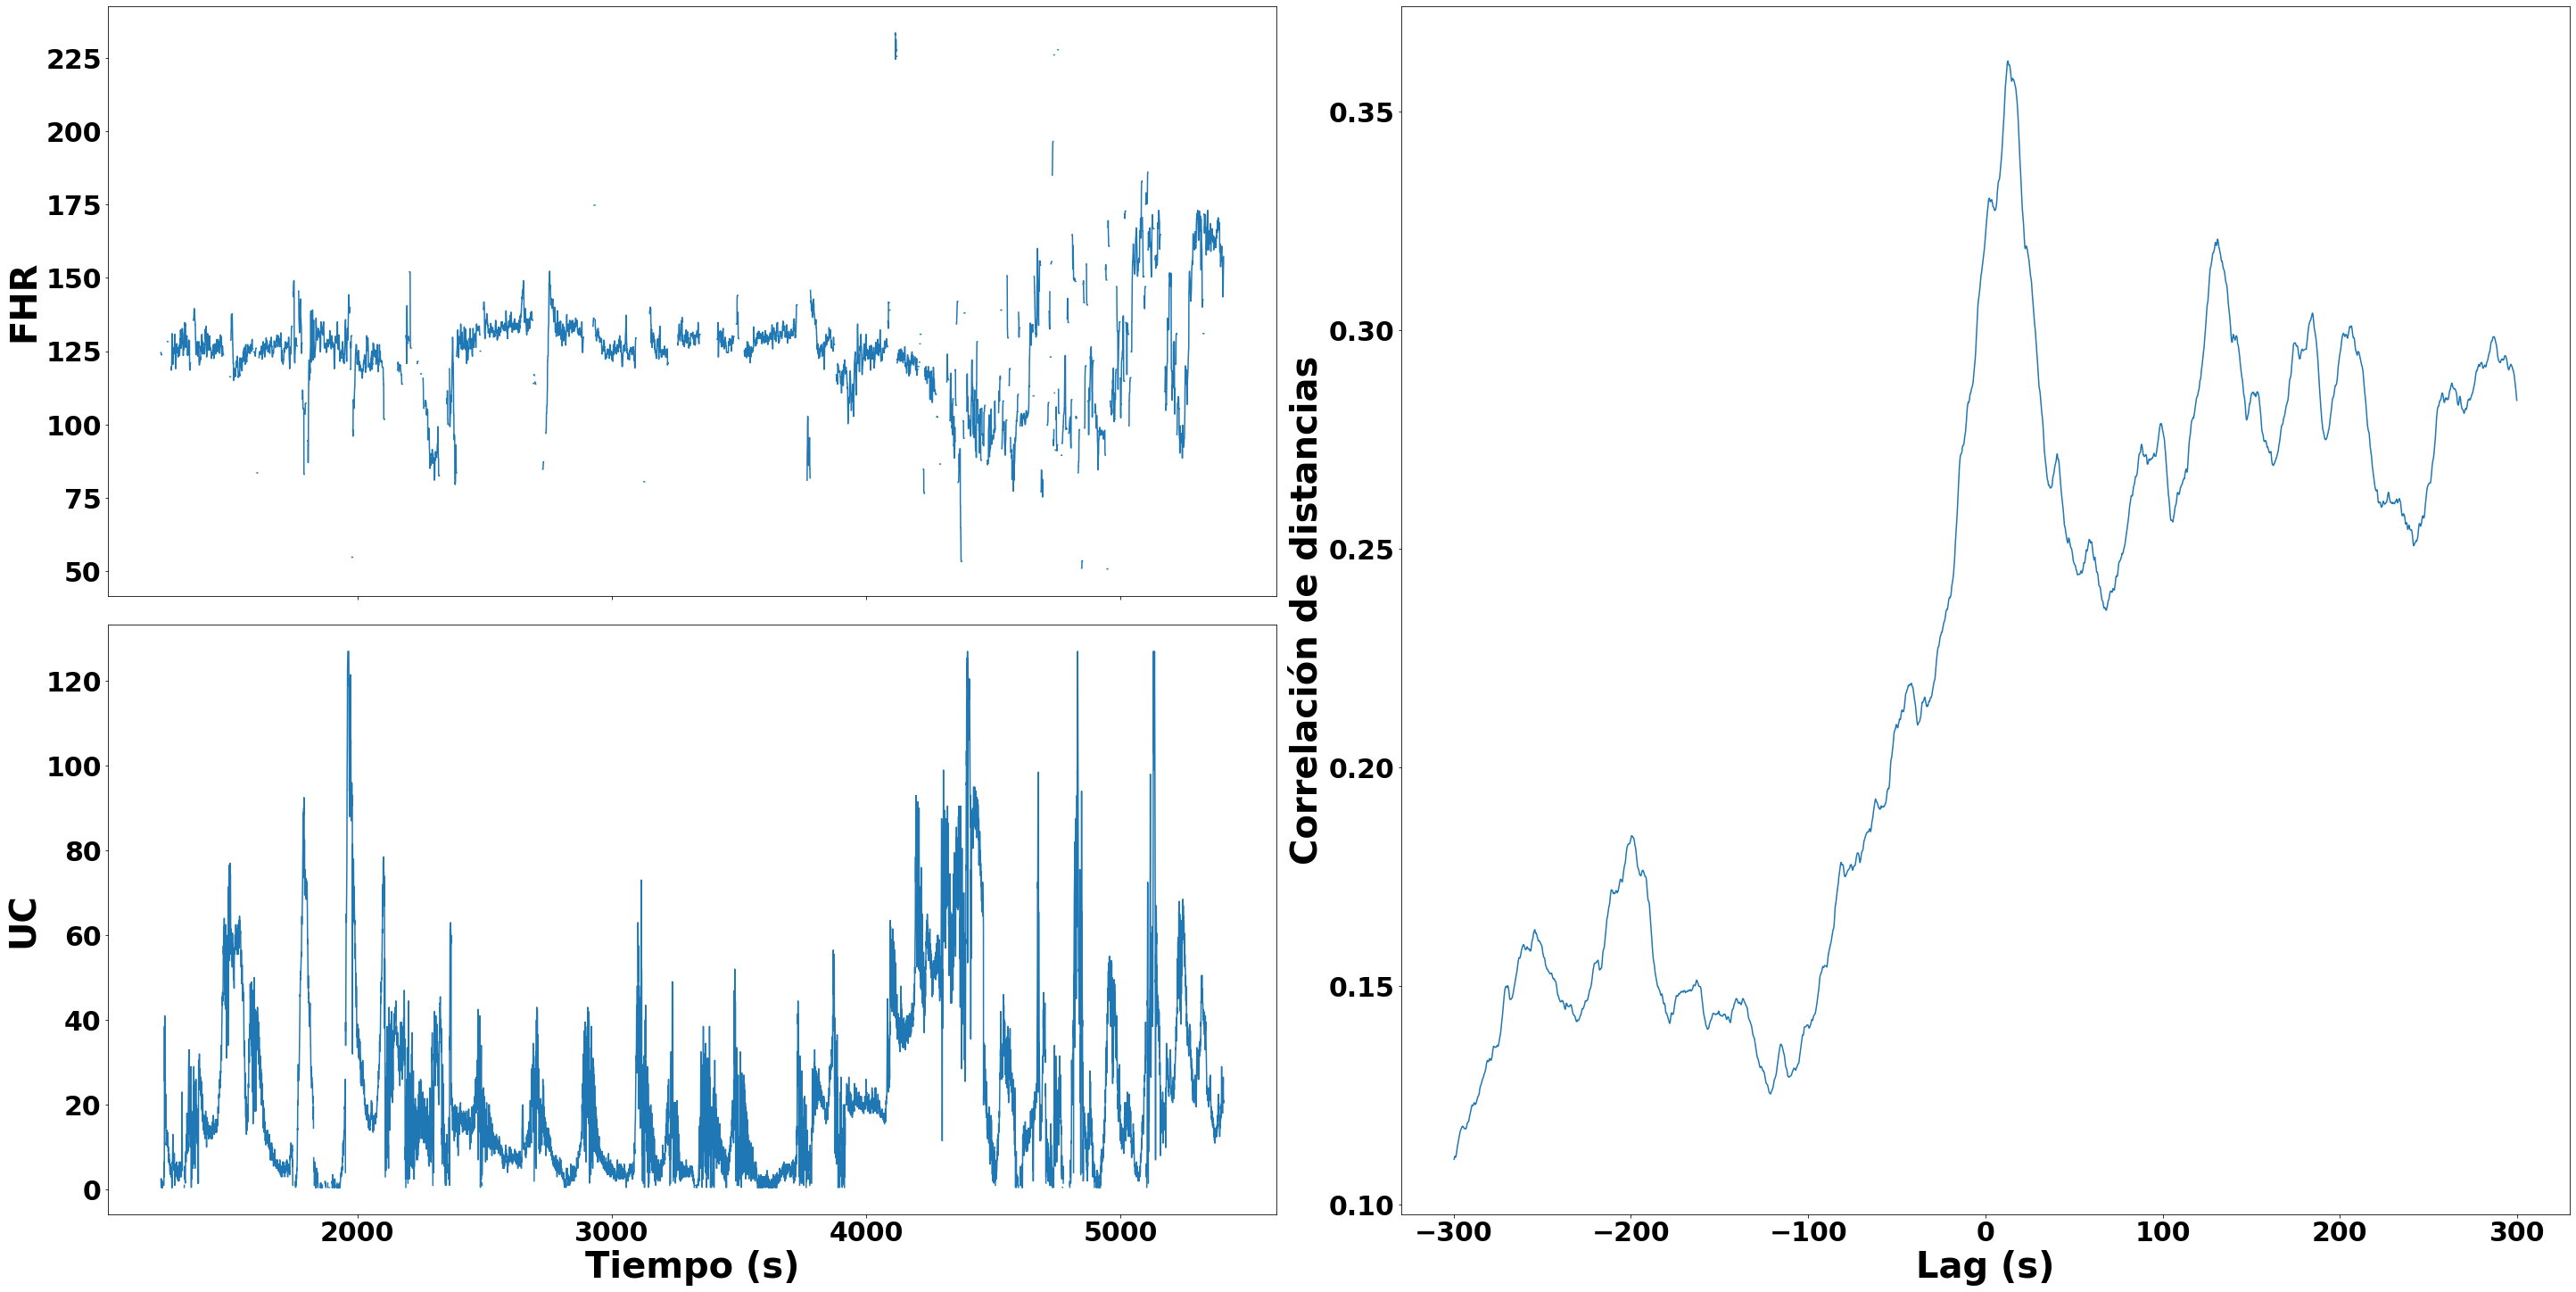

In [310]:
idx = 2043
lags = t_utils.calc_lags(minutes=5)
fhr_signal = fhr_clean.loc[idx]
uc_signal = uc_clean.loc[idx]
y_signal = y_clean.loc[idx]
cdcor_transformation = joblib.Parallel(n_jobs=8)(
    joblib.delayed(t_utils.dcor)(fhr_signal, uc_signal.shift(lag), 3000)
    for lag in lags
)

cdcor_signal = pd.Series(cdcor_transformation, index=lags)

axd = plt.figure(constrained_layout=True, figsize=(40, 20)).subplot_mosaic(
    """
    AACC
    BBCC
    """
)

axd['A'].plot(fhr_signal.index, fhr_signal.values)
axd['B'].plot(uc_signal.index, uc_signal.values)
axd['C'].plot(cdcor_signal.index / 4, cdcor_signal.values)

factor_label_font_size = 2
axd['B'].set_xlabel('Tiempo (s)', fontsize=xlabel_font_size * factor_label_font_size)
axd['C'].set_xlabel("Lag (s)", fontsize=xlabel_font_size * factor_label_font_size)
axd['A'].get_shared_x_axes().join(axd['A'], axd['B'])
axd['A'].set_xticklabels([])

axd['A'].set_ylabel('FHR', fontsize=xlabel_font_size * factor_label_font_size)
axd['B'].set_ylabel('UC', fontsize=xlabel_font_size * factor_label_font_size)
axd['C'].set_ylabel('Correlación de distancias', fontsize=xlabel_font_size * factor_label_font_size)

factor_both_ticks_label_size = 2
axd['A'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)
axd['B'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)
axd['C'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)

fig = plt.gcf()
fig.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_{idx}_DCOR_ejemplo.pdf")

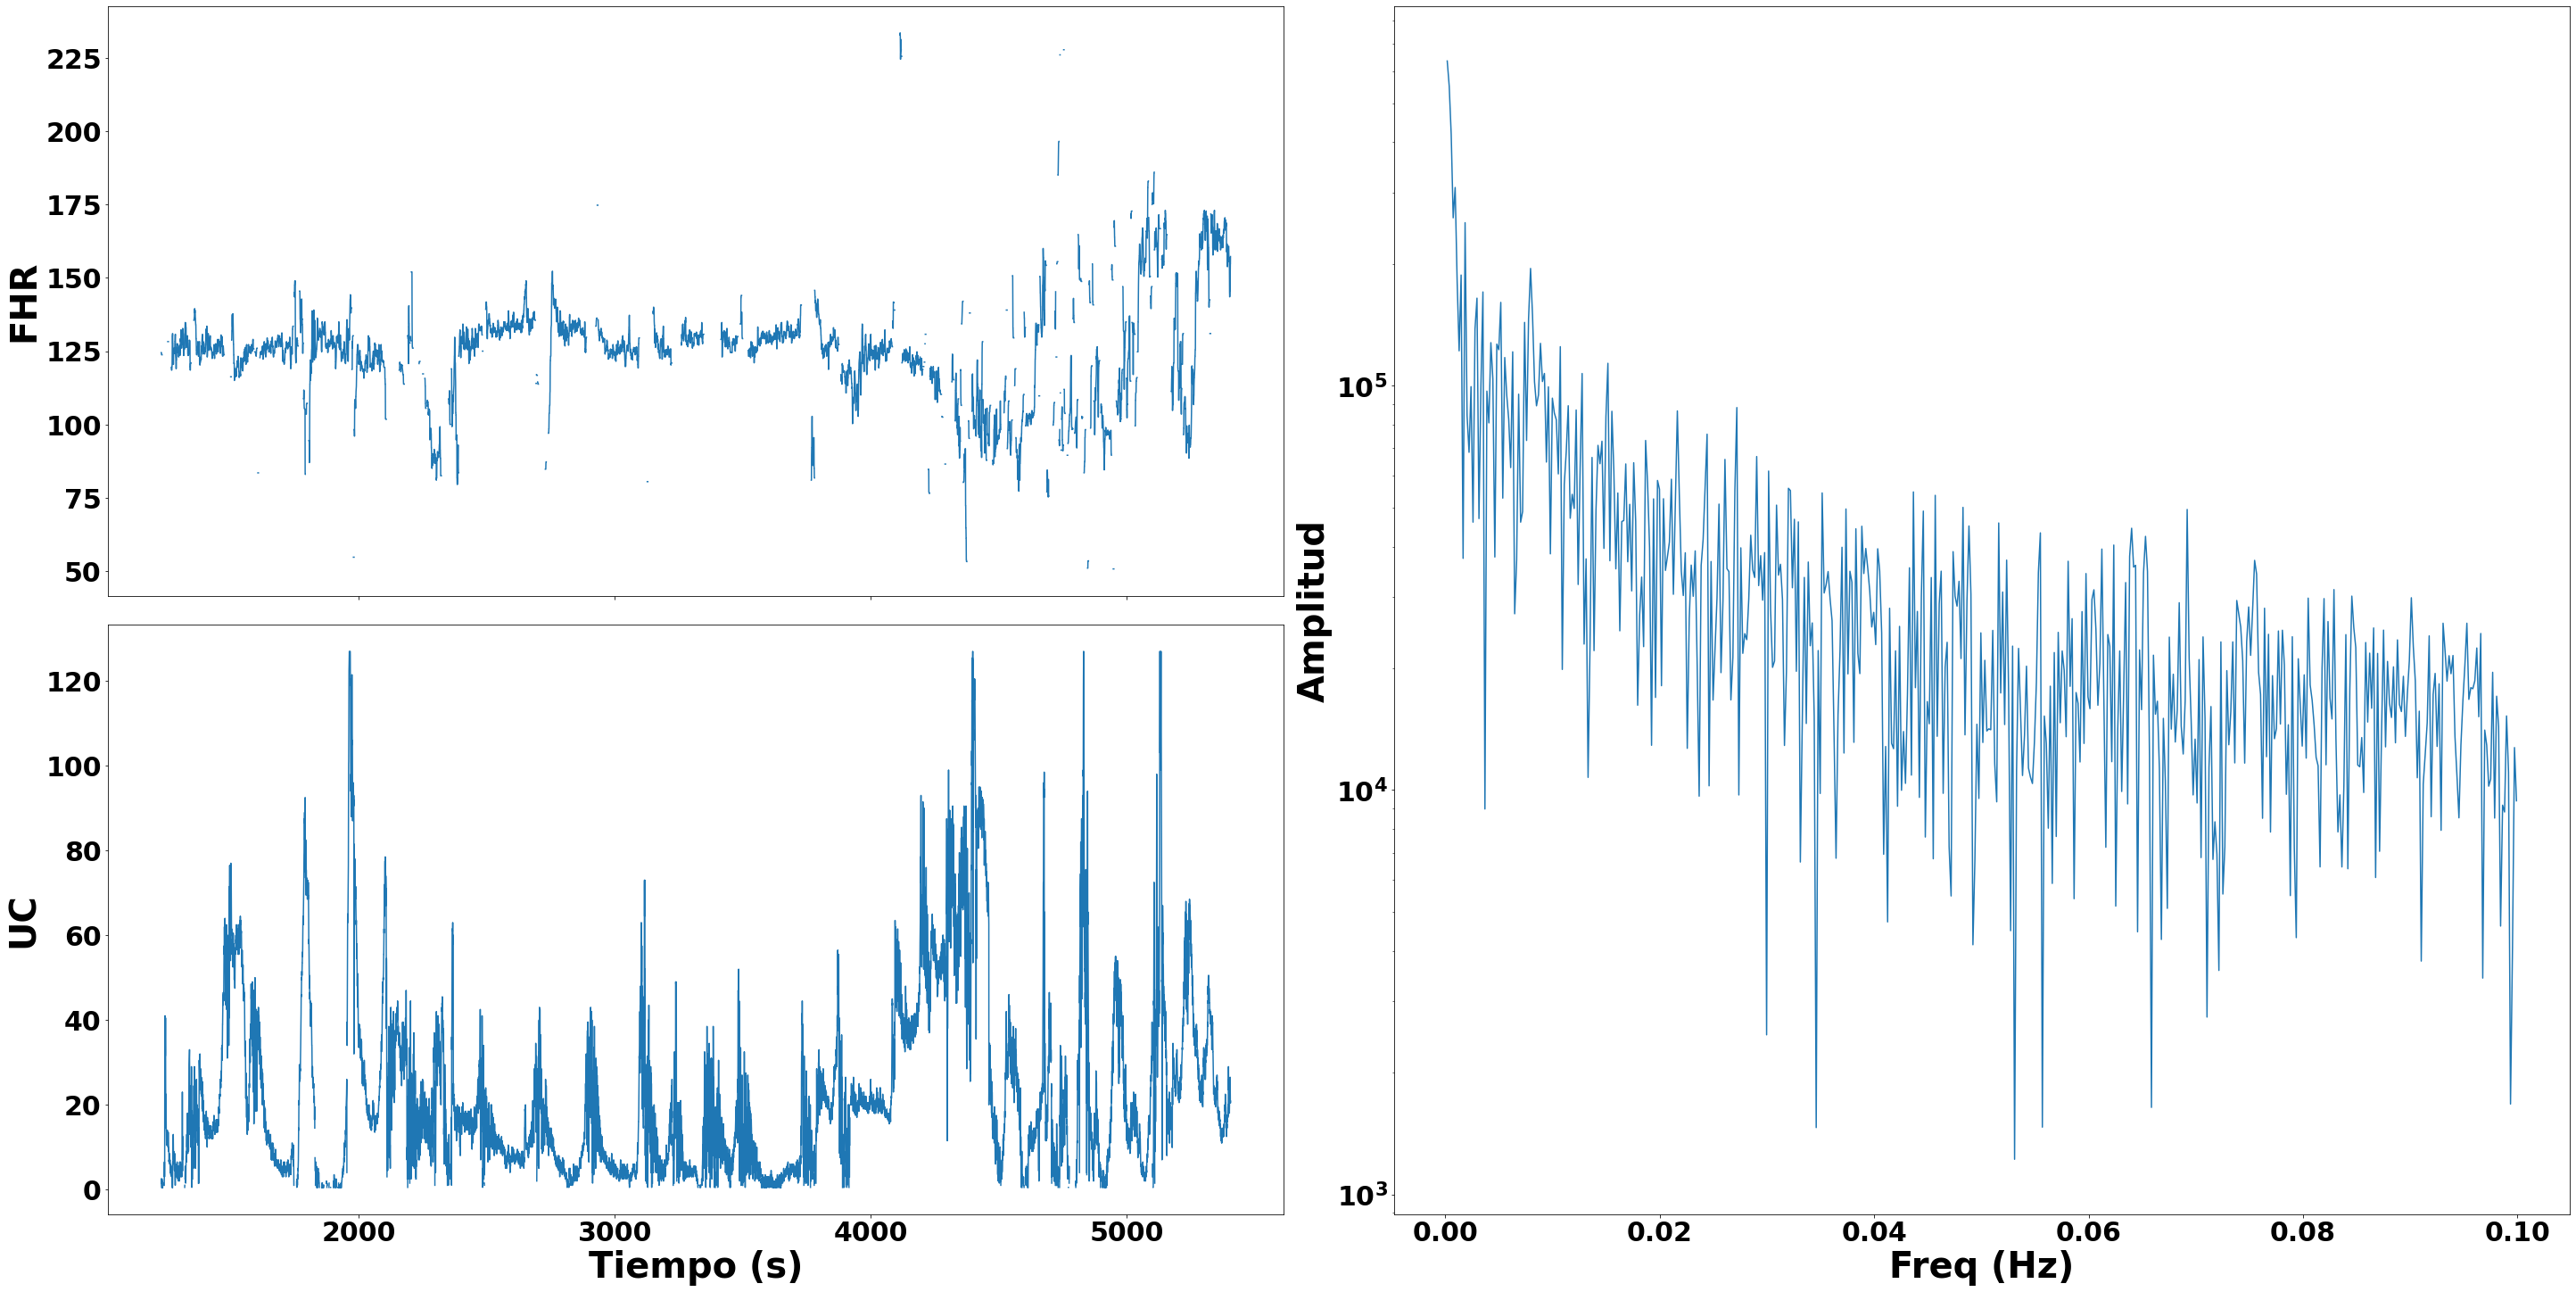

In [132]:
idx = 2043
freqs = t_utils.get_freqs(fhr_signal.shape[-1])
fhr_signal = fhr_clean.loc[idx]
uc_signal = uc_clean.loc[idx]
y_signal = y_clean.loc[idx]
fft_transformation = t_utils.nan_save_fft(fhr_signal, freqs)

fft_signal = pd.Series(fft_transformation, index=freqs)

fft_signal = fft_signal.loc[freqs <= 0.1]
fft_signal = fft_signal.iloc[1:]

axd = plt.figure(constrained_layout=True, figsize=(40, 20)).subplot_mosaic(
    """
    AACC
    BBCC
    """
)

axd['A'].plot(fhr_signal.index, fhr_signal.values)
axd['B'].plot(uc_signal.index, uc_signal.values)
axd['C'].plot(fft_signal.index, fft_signal.values)

factor_label_font_size = 2
axd['B'].set_xlabel('Tiempo (s)', fontsize=xlabel_font_size * factor_label_font_size)
axd['C'].set_xlabel("Freq (Hz)", fontsize=xlabel_font_size * factor_label_font_size)
axd['A'].get_shared_x_axes().join(axd['A'], axd['B'])
axd['A'].set_xticklabels([])

axd['A'].set_ylabel('FHR', fontsize=xlabel_font_size * factor_label_font_size)
axd['B'].set_ylabel('UC', fontsize=xlabel_font_size * factor_label_font_size)
axd['C'].set_ylabel('Amplitud', fontsize=xlabel_font_size * factor_label_font_size)

axd['C'].set_yscale('log')
# axd['C'].set_xlim((0,0.1))

factor_both_ticks_label_size = 2
axd['A'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)
axd['B'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)
axd['C'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)

fig = plt.gcf()
fig.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_{idx}_FFT_ejemplo.pdf")

In [325]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(zip(fhr_clean.copy().iterrows(), uc_clean.copy().iterrows()),
                                                 total=len(uc)):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, min_num_points=None) for lag in lags
    )
cc_df = pd.DataFrame(cc_data).T
cc_df.columns = lags
cc_df

  0%|          | 0/552 [00:00<?, ?it/s]

-1199     -1198     -1197     -1196     -1195     -1194     -1193  \
1001 -0.143611 -0.143392 -0.143133 -0.143069 -0.143331 -0.143864 -0.144430   
1002  0.051316  0.048979  0.046630  0.043732  0.040791  0.037558  0.034548   
1003 -0.169003 -0.167530 -0.165941 -0.164509 -0.163056 -0.161751 -0.160551   
1004  0.011775  0.010709  0.009421  0.007845  0.006370  0.005518  0.005287   
1005 -0.126280 -0.126069 -0.125784 -0.125867 -0.125825 -0.125499 -0.124934   
...        ...       ...       ...       ...       ...       ...       ...   
2042 -0.079467 -0.077935 -0.076384 -0.074798 -0.073322 -0.071966 -0.070564   
2043  0.007374  0.006142  0.004517  0.002829  0.001037 -0.000626 -0.001970   
2044  0.009746  0.009735  0.009070  0.008440  0.007824  0.007105  0.006719   
2045  0.033712  0.032558  0.030776  0.028386  0.025563  0.022178  0.018981   
2046  0.043211  0.042579  0.042363  0.042874  0.043826  0.044717  0.045597   

         -1192     -1191     -1190  ...      1190      1191      1192  \
1001 -0.144705 -0.145320 -0.145763  ... -0.071019 -0.072023 -0.073669   
1002  0.032020  0.030232  0.027842  ...  0.075747  0.077366  0.078866   
1003 -0.160393 -0.160192 -0.159970  ...  0.019217  0.019540  0.019278   
1004  0.004886  0.004552  0.004915  ... -0.135158 -0.134690 -0.133797   
1005 -0.124543 -0.123750 -0.123181  ... -0.006627 -0.006341 -0.005711   
...        ...       ...       ...  ...       ...       ...       ...   
2042 -0.069252 -0.067818 -0.066883  ... -0.209855 -0.210246 -0.210503   
2043 -0.002984 -0.004611 -0.006215  ... -0.178921 -0.178776 -0.178597   
2044  0.005917  0.005915  0.006205  ...  0.157561  0.158602  0.159348   
2045  0.015537  0.012145  0.008431  ...  0.157266  0.157449  0.157424   
2046  0.045308  0.044611  0.042035  ...  0.000893 -0.001472 -0.003552   

          1193      1194      1195      1196      1197      1198      1199  
1001 -0.075269 -0.076692 -0.077778 -0.078876 -0.079965 -0.081177 -0.082298  
1002  0.080367  0.081703  0.082672  0.083245  0.083386  0.082942  0.081982  
1003  0.019167  0.018870  0.018258  0.017509  0.016931  0.016199  0.015650  
1004 -0.133298 -0.132531 -0.131928 -0.131086 -0.130169 -0.129447 -0.128523  
1005 -0.005226 -0.005344 -0.005489 -0.005640 -0.005584 -0.005516 -0.005679  
...        ...       ...       ...       ...       ...       ...       ...  
2042 -0.211309 -0.211807 -0.212266 -0.213027 -0.213783 -0.214986 -0.215639  
2043 -0.178450 -0.177884 -0.177448 -0.176855 -0.176449 -0.175893 -0.175490  
2044  0.160350  0.160821  0.161080  0.161083  0.160907  0.161083  0.161616  
2045  0.157303  0.157174  0.156988  0.156626  0.156216  0.155449  0.154729  
2046 -0.006192 -0.008633 -0.011695 -0.014785 -0.017795 -0.021046 -0.023533  

[552 rows x 2399 columns]

In [326]:
bad_idx = cc_df.index[cc_df.isna().sum(axis=1) != 0]
bad_idx

Int64Index([1104, 1119, 1155, 1188, 1258], dtype='int64')

In [332]:
cc_df = cc_df.drop(bad_idx)
cc_df

-1199     -1198     -1197     -1196     -1195     -1194     -1193  \
1001 -0.143611 -0.143392 -0.143133 -0.143069 -0.143331 -0.143864 -0.144430   
1002  0.051316  0.048979  0.046630  0.043732  0.040791  0.037558  0.034548   
1003 -0.169003 -0.167530 -0.165941 -0.164509 -0.163056 -0.161751 -0.160551   
1004  0.011775  0.010709  0.009421  0.007845  0.006370  0.005518  0.005287   
1005 -0.126280 -0.126069 -0.125784 -0.125867 -0.125825 -0.125499 -0.124934   
...        ...       ...       ...       ...       ...       ...       ...   
2042 -0.079467 -0.077935 -0.076384 -0.074798 -0.073322 -0.071966 -0.070564   
2043  0.007374  0.006142  0.004517  0.002829  0.001037 -0.000626 -0.001970   
2044  0.009746  0.009735  0.009070  0.008440  0.007824  0.007105  0.006719   
2045  0.033712  0.032558  0.030776  0.028386  0.025563  0.022178  0.018981   
2046  0.043211  0.042579  0.042363  0.042874  0.043826  0.044717  0.045597   

         -1192     -1191     -1190  ...      1190      1191      1192  \
1001 -0.144705 -0.145320 -0.145763  ... -0.071019 -0.072023 -0.073669   
1002  0.032020  0.030232  0.027842  ...  0.075747  0.077366  0.078866   
1003 -0.160393 -0.160192 -0.159970  ...  0.019217  0.019540  0.019278   
1004  0.004886  0.004552  0.004915  ... -0.135158 -0.134690 -0.133797   
1005 -0.124543 -0.123750 -0.123181  ... -0.006627 -0.006341 -0.005711   
...        ...       ...       ...  ...       ...       ...       ...   
2042 -0.069252 -0.067818 -0.066883  ... -0.209855 -0.210246 -0.210503   
2043 -0.002984 -0.004611 -0.006215  ... -0.178921 -0.178776 -0.178597   
2044  0.005917  0.005915  0.006205  ...  0.157561  0.158602  0.159348   
2045  0.015537  0.012145  0.008431  ...  0.157266  0.157449  0.157424   
2046  0.045308  0.044611  0.042035  ...  0.000893 -0.001472 -0.003552   

          1193      1194      1195      1196      1197      1198      1199  
1001 -0.075269 -0.076692 -0.077778 -0.078876 -0.079965 -0.081177 -0.082298  
1002  0.080367  0.081703  0.082672  0.083245  0.083386  0.082942  0.081982  
1003  0.019167  0.018870  0.018258  0.017509  0.016931  0.016199  0.015650  
1004 -0.133298 -0.132531 -0.131928 -0.131086 -0.130169 -0.129447 -0.128523  
1005 -0.005226 -0.005344 -0.005489 -0.005640 -0.005584 -0.005516 -0.005679  
...        ...       ...       ...       ...       ...       ...       ...  
2042 -0.211309 -0.211807 -0.212266 -0.213027 -0.213783 -0.214986 -0.215639  
2043 -0.178450 -0.177884 -0.177448 -0.176855 -0.176449 -0.175893 -0.175490  
2044  0.160350  0.160821  0.161080  0.161083  0.160907  0.161083  0.161616  
2045  0.157303  0.157174  0.156988  0.156626  0.156216  0.155449  0.154729  
2046 -0.006192 -0.008633 -0.011695 -0.014785 -0.017795 -0.021046 -0.023533  

[547 rows x 2399 columns]

In [328]:
cc_data = dict()
lags = t_utils.calc_lags(minutes=5)

for (idx_fhr, fhr_row), (idx_uc, uc_row) in tqdm(
        zip(fhr.drop(bad_idx).copy().iterrows(), uc.drop(bad_idx).copy().iterrows()), total=len(uc.drop(bad_idx))):
    fhr_signal = pd.Series(fhr_row.values)
    uc_signal = pd.Series(uc_row.values)

    cc_data[idx_fhr] = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, min_num_points=None) for lag in lags
    )
non_clean_cc_df = pd.DataFrame(cc_data).T
non_clean_cc_df.columns = lags
non_clean_cc_df

  0%|          | 0/547 [00:00<?, ?it/s]

-1199     -1198     -1197     -1196     -1195     -1194     -1193  \
1001  0.203899  0.204320  0.204594  0.204909  0.205335  0.205808  0.206377   
1002  0.264957  0.265623  0.266425  0.267236  0.268041  0.269065  0.270351   
1003  0.104550  0.105075  0.105593  0.106181  0.106772  0.107368  0.107965   
1004  0.111149  0.110784  0.110453  0.109917  0.109409  0.108790  0.108150   
1005  0.146539  0.146062  0.145677  0.145206  0.144624  0.144248  0.143852   
...        ...       ...       ...       ...       ...       ...       ...   
2042  0.004424  0.004127  0.003922  0.003782  0.003701  0.003717  0.003657   
2043  0.049533  0.049630  0.049640  0.049585  0.049759  0.049873  0.050096   
2044  0.060393  0.060049  0.060470  0.060876  0.060927  0.060205  0.059695   
2045  0.207467  0.206775  0.205974  0.205108  0.204379  0.203592  0.202926   
2046  0.217657  0.218039  0.218648  0.219257  0.220003  0.220713  0.221427   

         -1192     -1191     -1190  ...      1190      1191      1192  \
1001  0.206877  0.207305  0.207595  ...  0.181668  0.181988  0.182197   
1002  0.271684  0.272732  0.273522  ...  0.070500  0.070941  0.071334   
1003  0.108549  0.109145  0.109740  ...  0.312409  0.312237  0.312033   
1004  0.107407  0.106780  0.106051  ... -0.033573 -0.034640 -0.035762   
1005  0.143544  0.143378  0.143419  ...  0.179612  0.179725  0.179715   
...        ...       ...       ...  ...       ...       ...       ...   
2042  0.003539  0.003202  0.002747  ...  0.029749  0.029241  0.028844   
2043  0.050283  0.050457  0.051345  ... -0.021011 -0.020578 -0.020271   
2044  0.059727  0.059722  0.059826  ...  0.058025  0.059100  0.060341   
2045  0.202308  0.201653  0.201206  ... -0.051730 -0.052242 -0.052844   
2046  0.221854  0.222199  0.222149  ...  0.087601  0.087290  0.086969   

          1193      1194      1195      1196      1197      1198      1199  
1001  0.181986  0.181802  0.181703  0.181409  0.181055  0.180491  0.180025  
1002  0.071634  0.072046  0.072649  0.073117  0.073561  0.073842  0.073819  
1003  0.311871  0.311668  0.311502  0.311313  0.311134  0.310957  0.310781  
1004 -0.037099 -0.038595 -0.040210 -0.041733 -0.043148 -0.044403 -0.045658  
1005  0.179812  0.179932  0.179885  0.179753  0.179996  0.180148  0.180187  
...        ...       ...       ...       ...       ...       ...       ...  
2042  0.028087  0.027567  0.027844  0.027684  0.027334  0.026773  0.026812  
2043 -0.020395 -0.020675 -0.020583 -0.020562 -0.020911 -0.021183 -0.022040  
2044  0.061429  0.062233  0.063035  0.063667  0.064035  0.064423  0.065099  
2045 -0.053485 -0.054009 -0.054633 -0.055229 -0.055864 -0.056643 -0.057420  
2046  0.086492  0.086032  0.085321  0.084588  0.083566  0.082206  0.081091  

[547 rows x 2399 columns]

In [329]:
non_clean_bad_idx = non_clean_cc_df.index[non_clean_cc_df.isna().sum(axis=1) != 0]
non_clean_bad_idx

Int64Index([], dtype='int64')

In [341]:
((cc_df - non_clean_cc_df) ** 2).sum(axis=1).idxmax()

1198

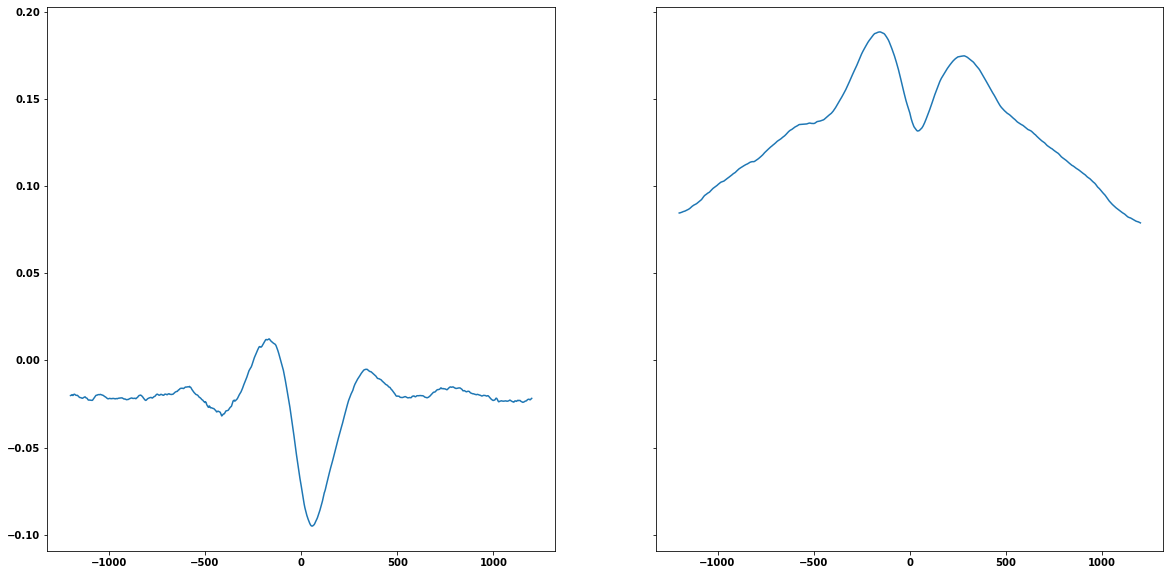

In [352]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10), sharey=True)
ax[0].plot(cc_df.mean().index, cc_df.mean().values)
ax[1].plot(non_clean_cc_df.mean().index, non_clean_cc_df.mean().values)

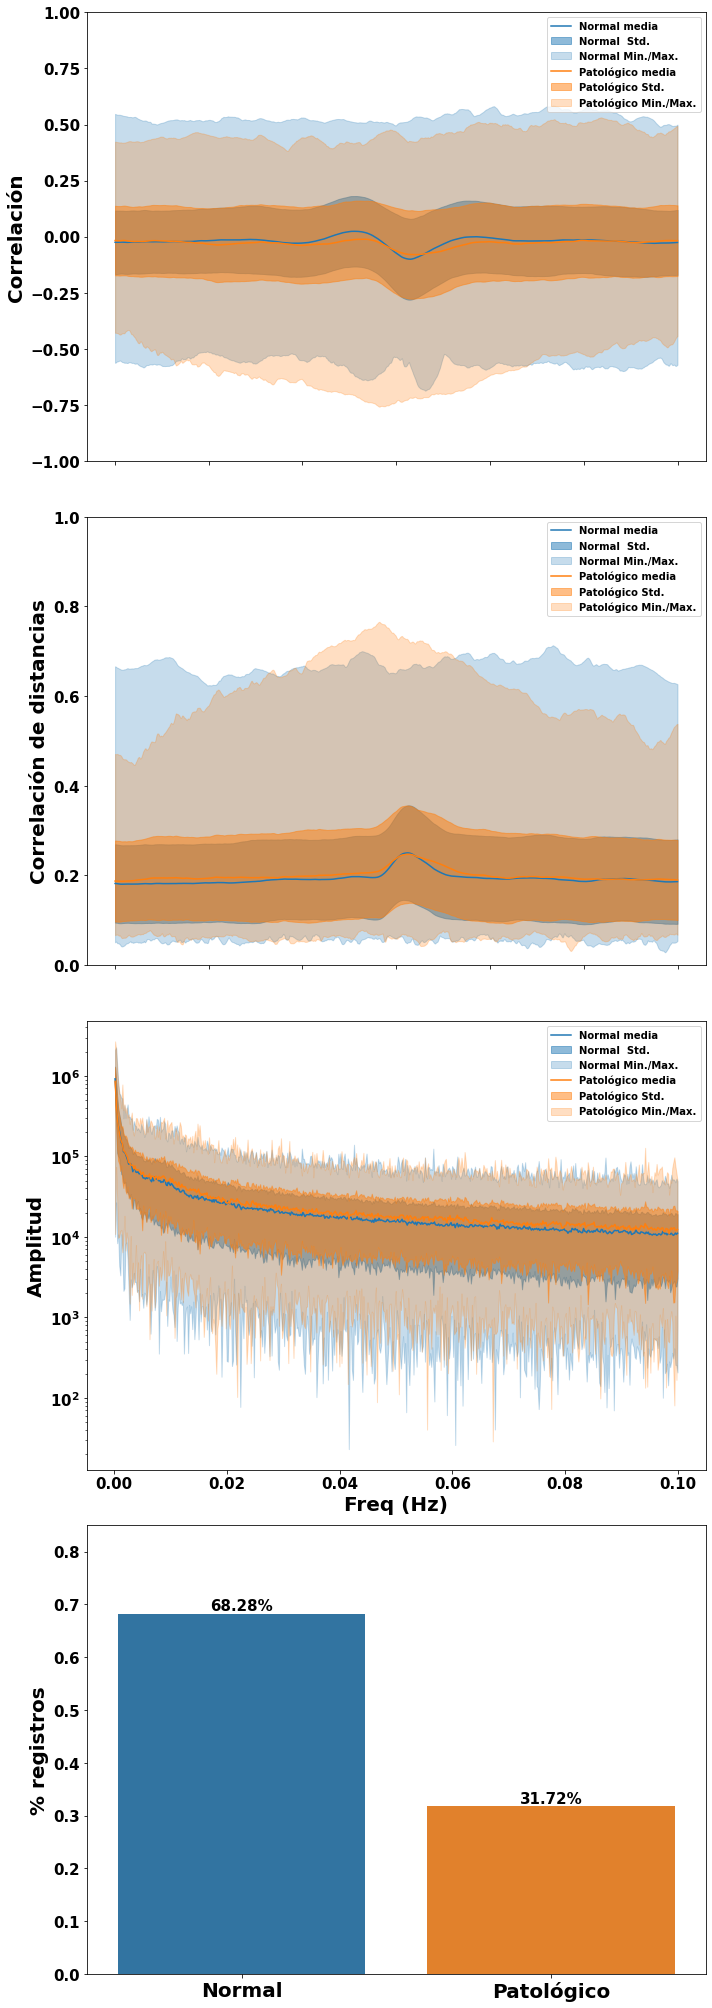

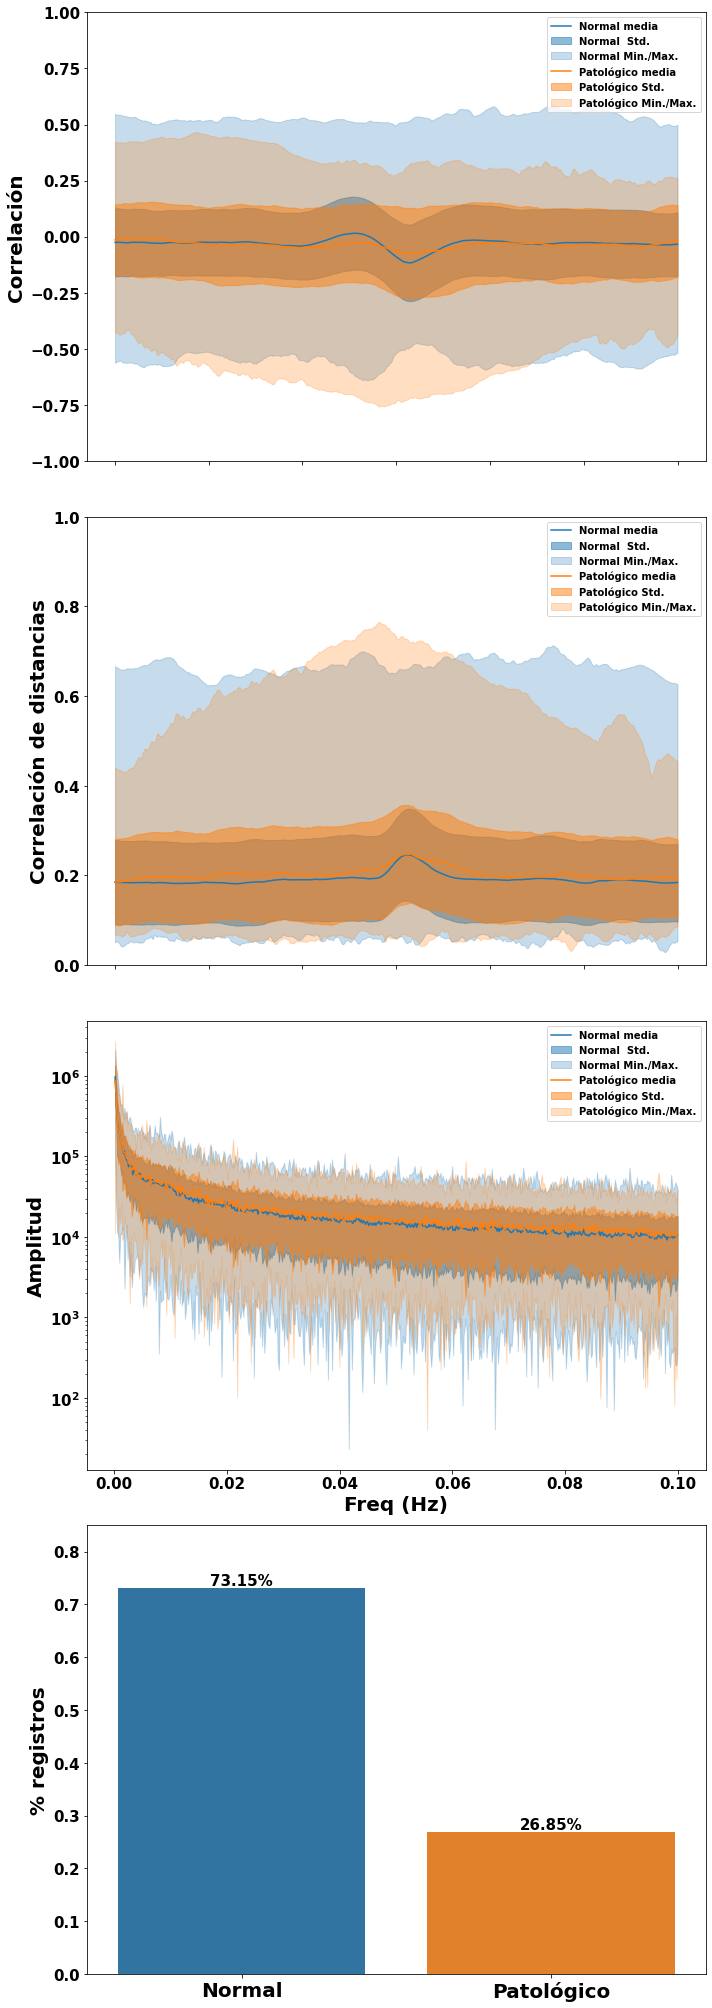

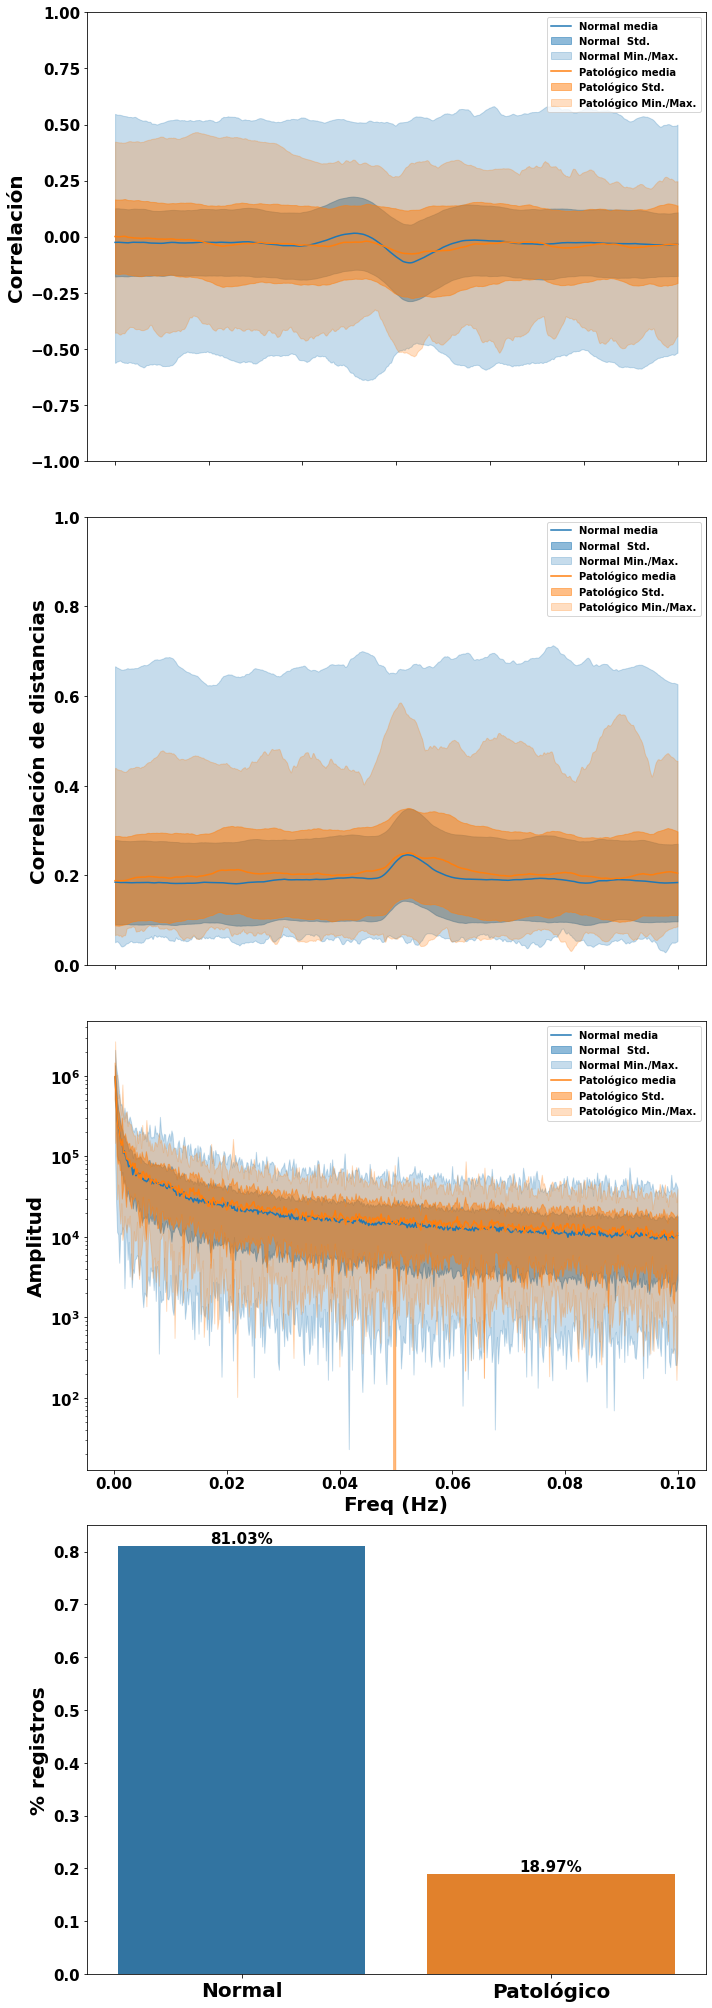

In [185]:
for filter_set in ['base', 'filtered', 'easy']:
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 28))
    for i, dataset in enumerate(['CC', 'DCOR', 'FFT']):
        tt, X, y = common_functions.load_data(dataset, filter_data=filter_set == 'filtered',
                                              easy_data=filter_set == 'easy')
        fourier = dataset == 'FFT'
        X_0 = X[y == 0].copy()
        mean_0 = X_0.mean().values
        std_0 = X_0.std().values
        max_0 = X_0.max().values
        min_0 = X_0.min().values

        X_1 = X[y == 1].copy()
        mean_1 = X_1.mean().values
        std_1 = X_1.std().values
        max_1 = X_1.max().values
        min_1 = X_1.min().values

        if not fourier:
            tt /= 4
        ax[i].plot(tt, mean_0, label='Normal media', color=COLORS[0])
        ax[i].fill_between(tt, mean_0 - std_0, mean_0 + std_0, label='Normal  Std.', alpha=0.5, color=COLORS[0])
        ax[i].fill_between(tt, min_0, max_0, label='Normal Min./Max.', alpha=0.25, color=COLORS[0])

        ax[i].plot(tt, mean_1, label='Patológico media', color=COLORS[1])
        ax[i].fill_between(tt, mean_1 - std_1, mean_1 + std_1, label='Patológico Std.', alpha=0.5, color=COLORS[1])
        ax[i].fill_between(tt, min_1, max_1, label='Patológico Min./Max.', alpha=0.25, color=COLORS[1])

        ax[i].legend(loc='best')
        # ax.set_title(f"{title}")
        if dataset == 'CC':
            ax[i].set_ylabel(f"Correlación", fontsize=xlabel_font_size)
            ax[i].set_ylim((-1, 1))
        elif dataset == 'DCOR':
            ax[i].set_ylabel(f"Correlación de distancias", fontsize=xlabel_font_size)
            ax[i].set_ylim((0, 1))
        else:
            ax[i].set_ylabel(f"Amplitud", fontsize=xlabel_font_size)
        if not fourier:
            if i == 2:
                ax[i].set_xlabel("Lag (s)", fontsize=xlabel_font_size)
        else:
            ax[i].set_xlabel("Freq (Hz)", fontsize=xlabel_font_size)
            ax[i].set_yscale('log')

        ax[i].tick_params(axis='both', which='major', labelsize=both_ticks_label_size)

    sns.barplot(x='index', y='ph', data=pd.DataFrame(y.value_counts(normalize=True)).reset_index(), ax=ax[3])
    ax[3].set_ylabel('% registros', fontsize=xlabel_font_size)
    ax[3].tick_params(axis='both', which='major', labelsize=both_ticks_label_size)
    ax[3].set_xticklabels(['Normal', 'Patológico'], fontsize=xlabel_font_size)
    ax[3].set(xlabel=None)
    ax[3].set_ylim((0, 0.85))

    ax[3].bar_label(ax[3].containers[0],
                    labels=[f'{x*100:.2f}%' for x in ax[3].containers[0].datavalues],
                    fontsize=legend_font_size)

    ax[0].get_shared_x_axes().join(ax[0], ax[1])
    ax[1].get_shared_x_axes().join(ax[0], ax[1])
    ax[0].set_xticklabels([])
    ax[1].set_xticklabels([])

    fig.tight_layout()
    fig.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_{filter_set}_data_description.pdf")

['68.28', '31.72']

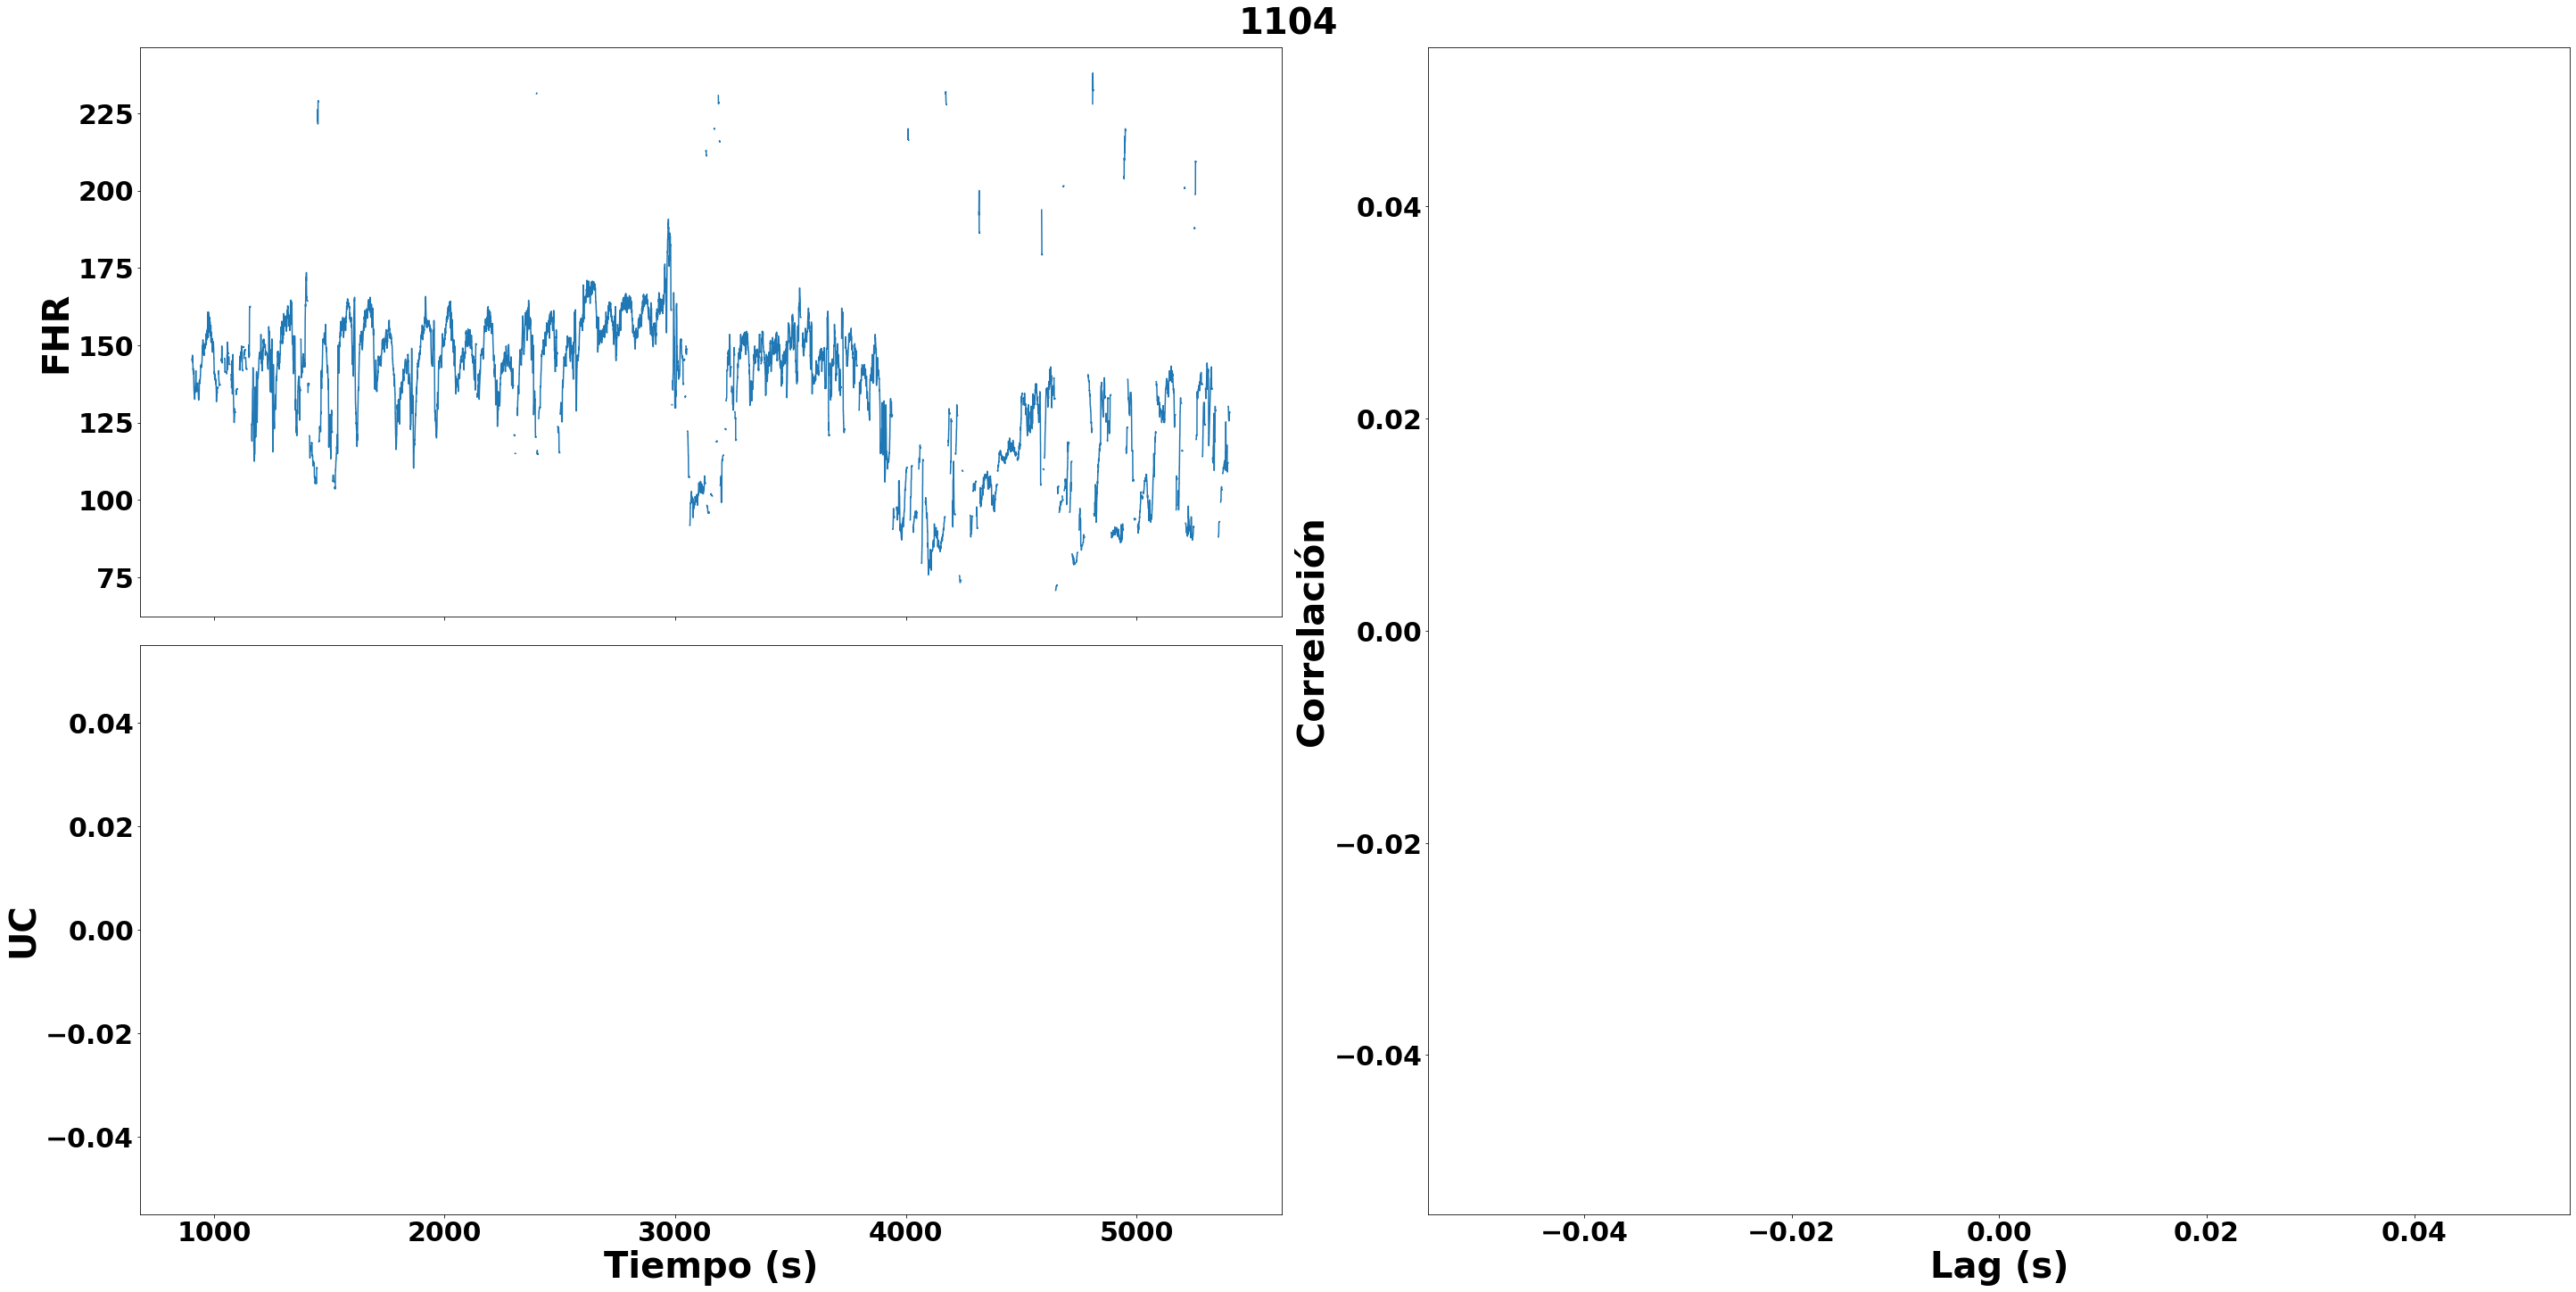

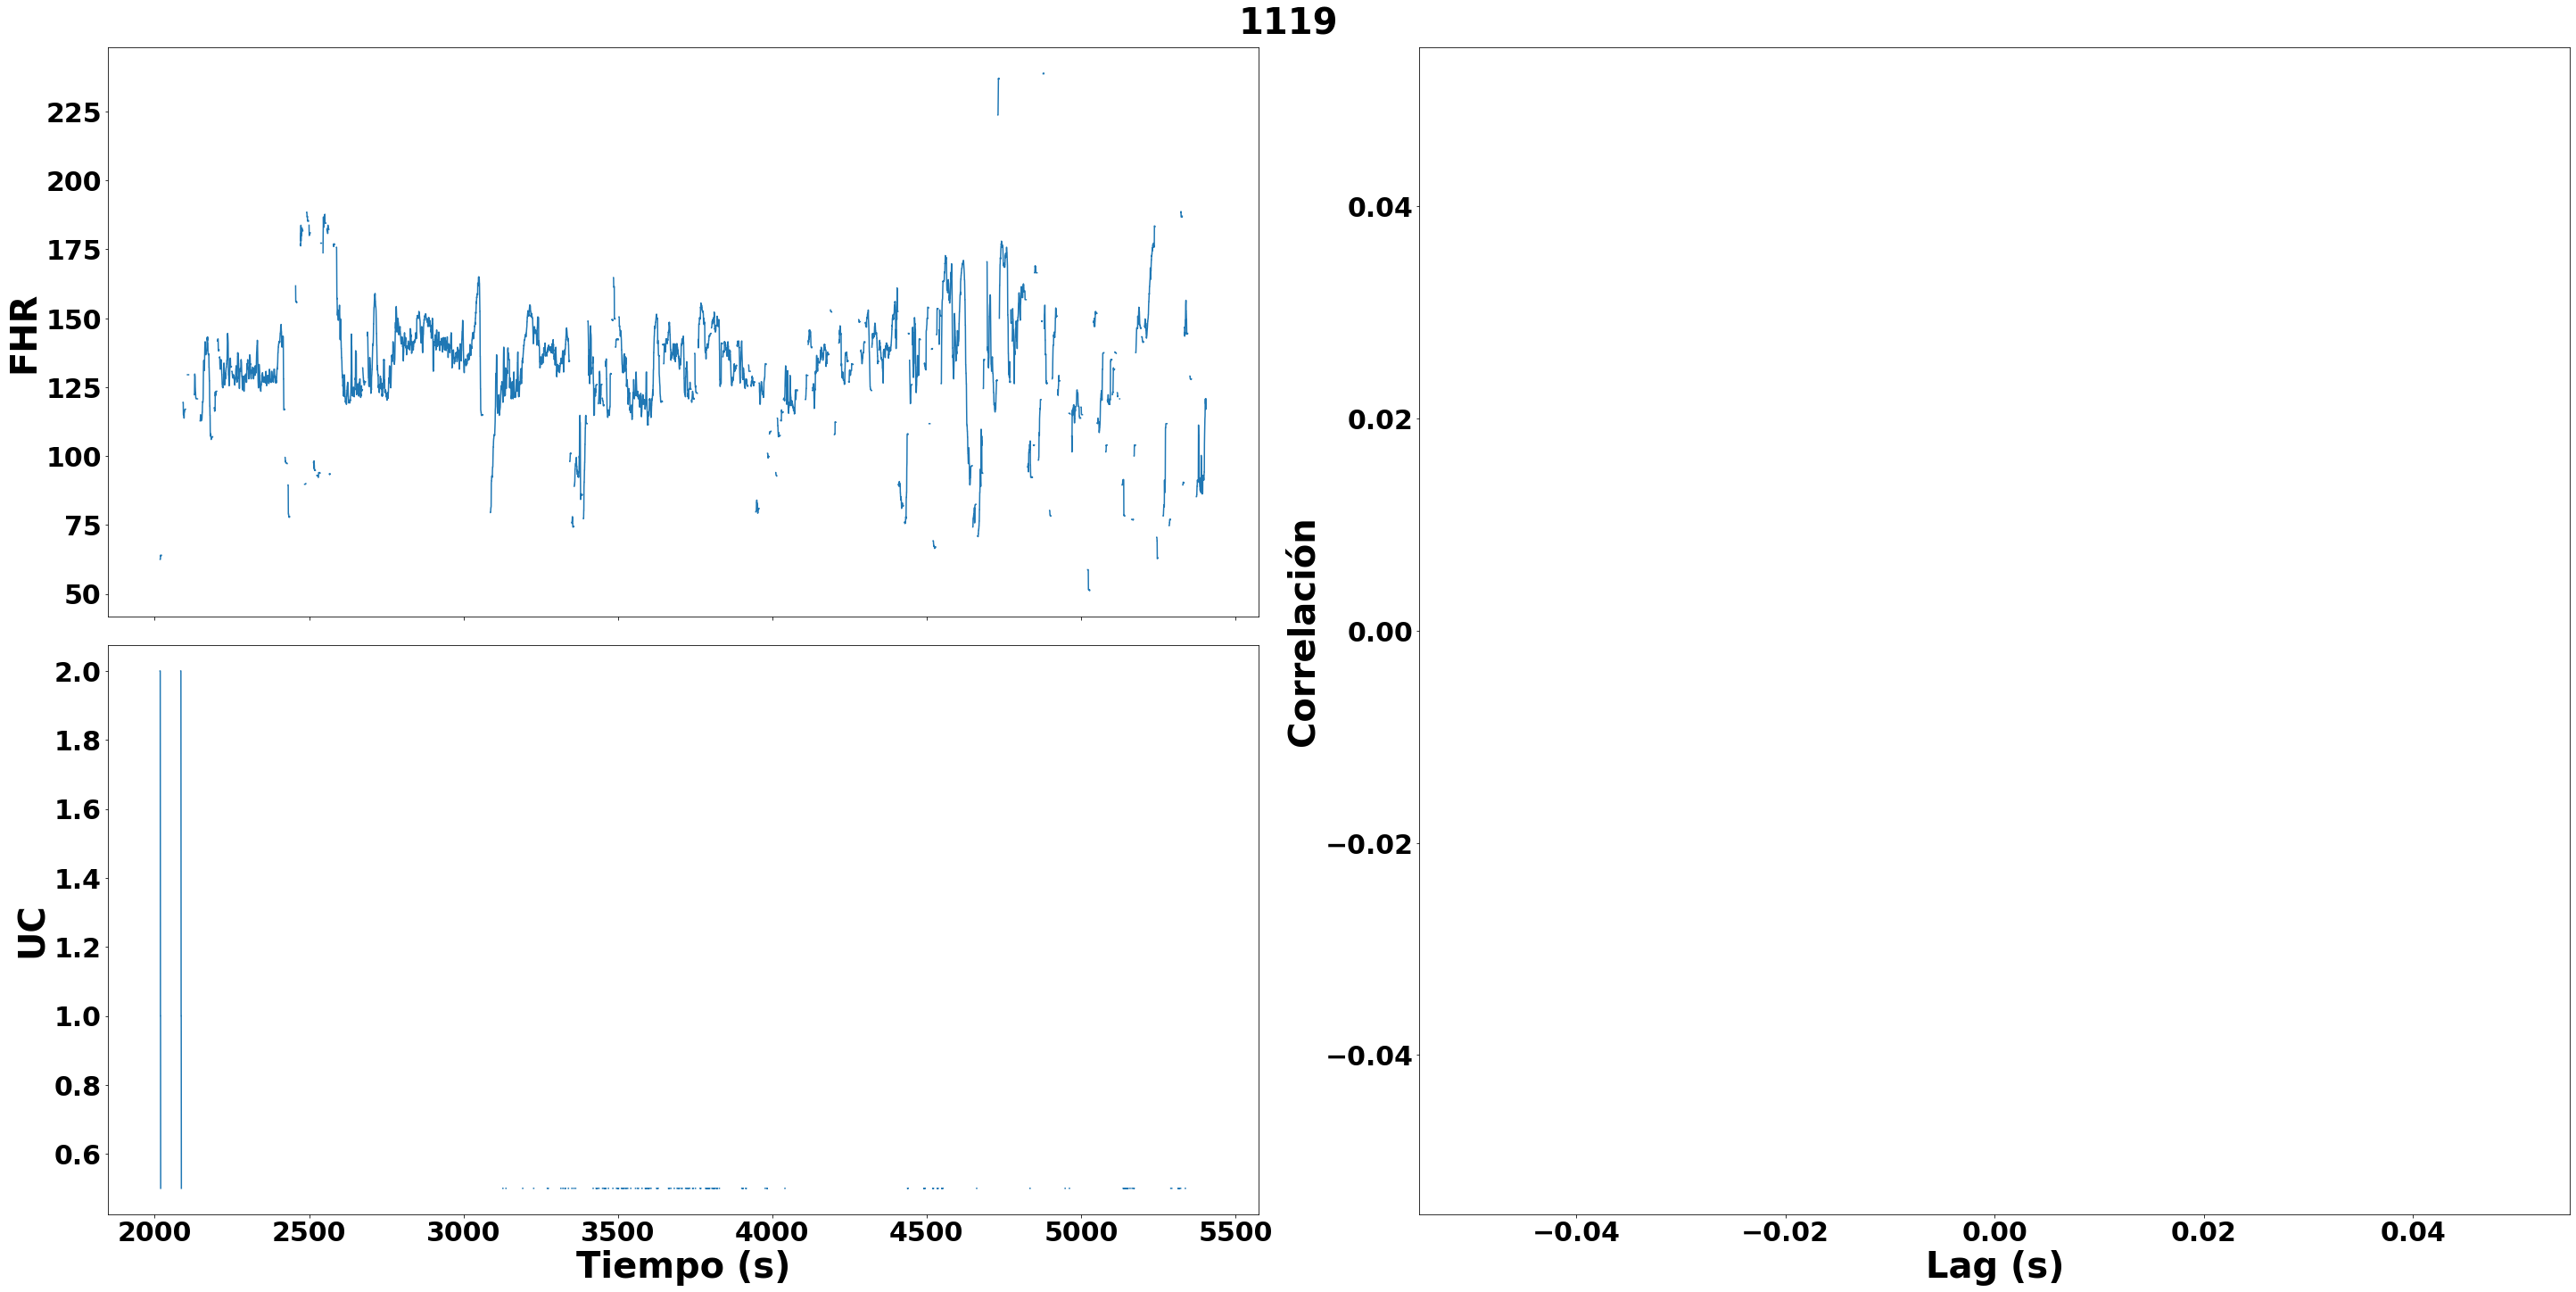

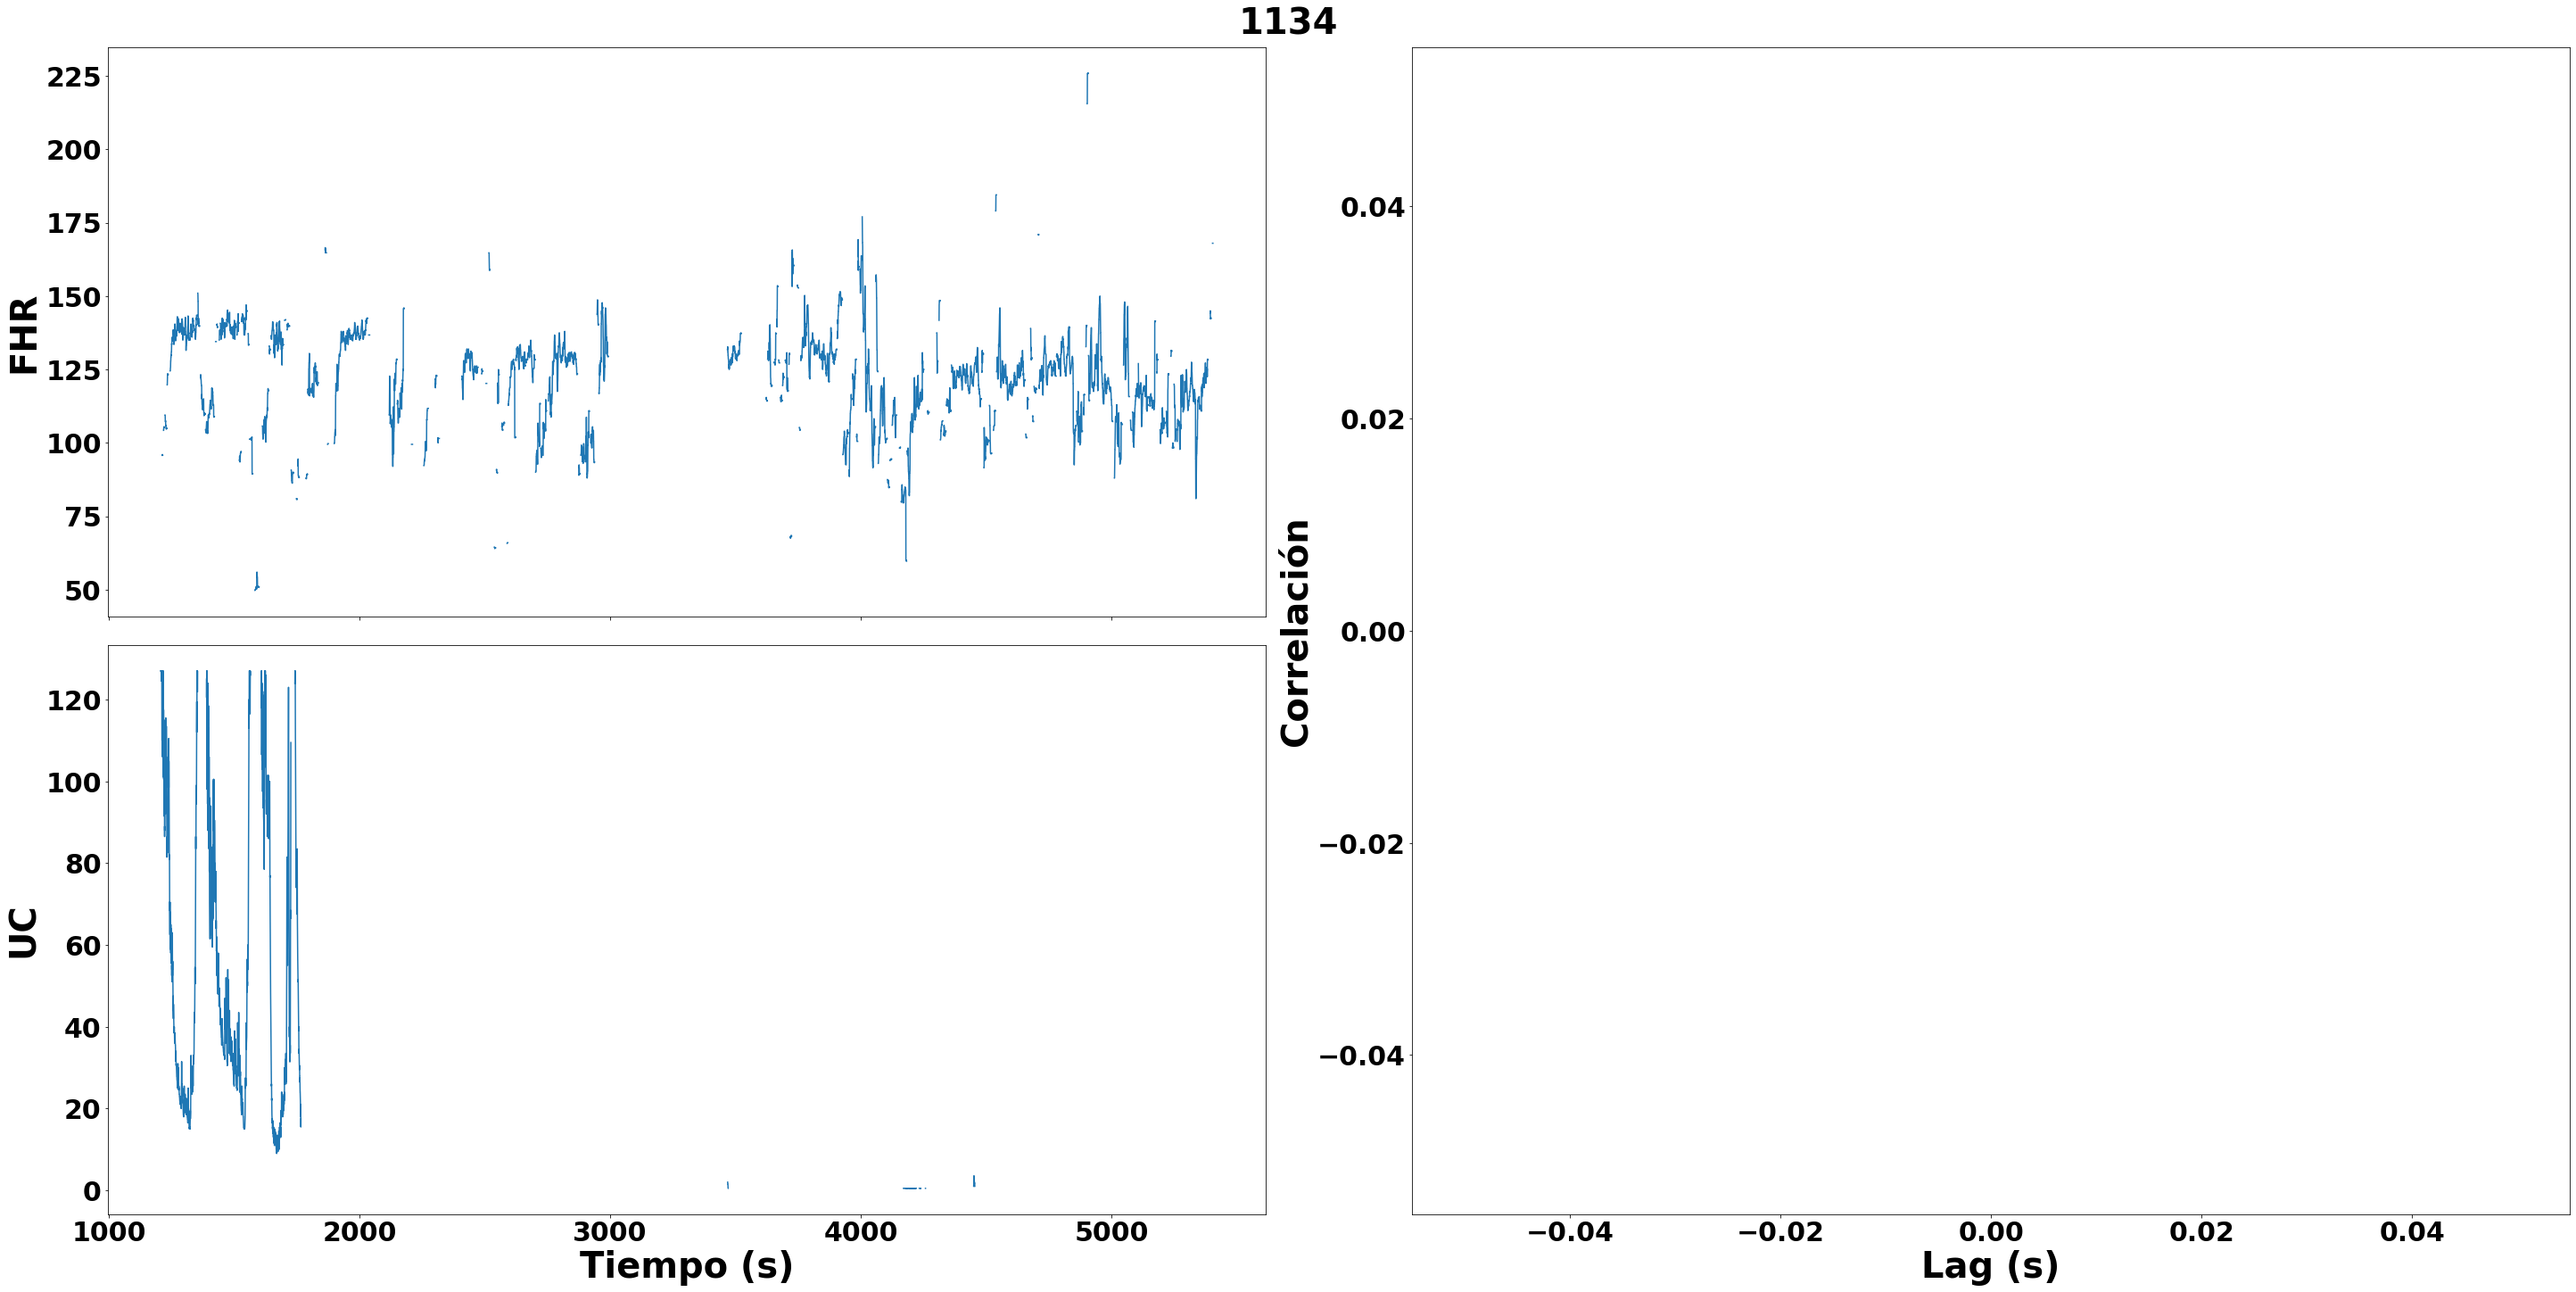

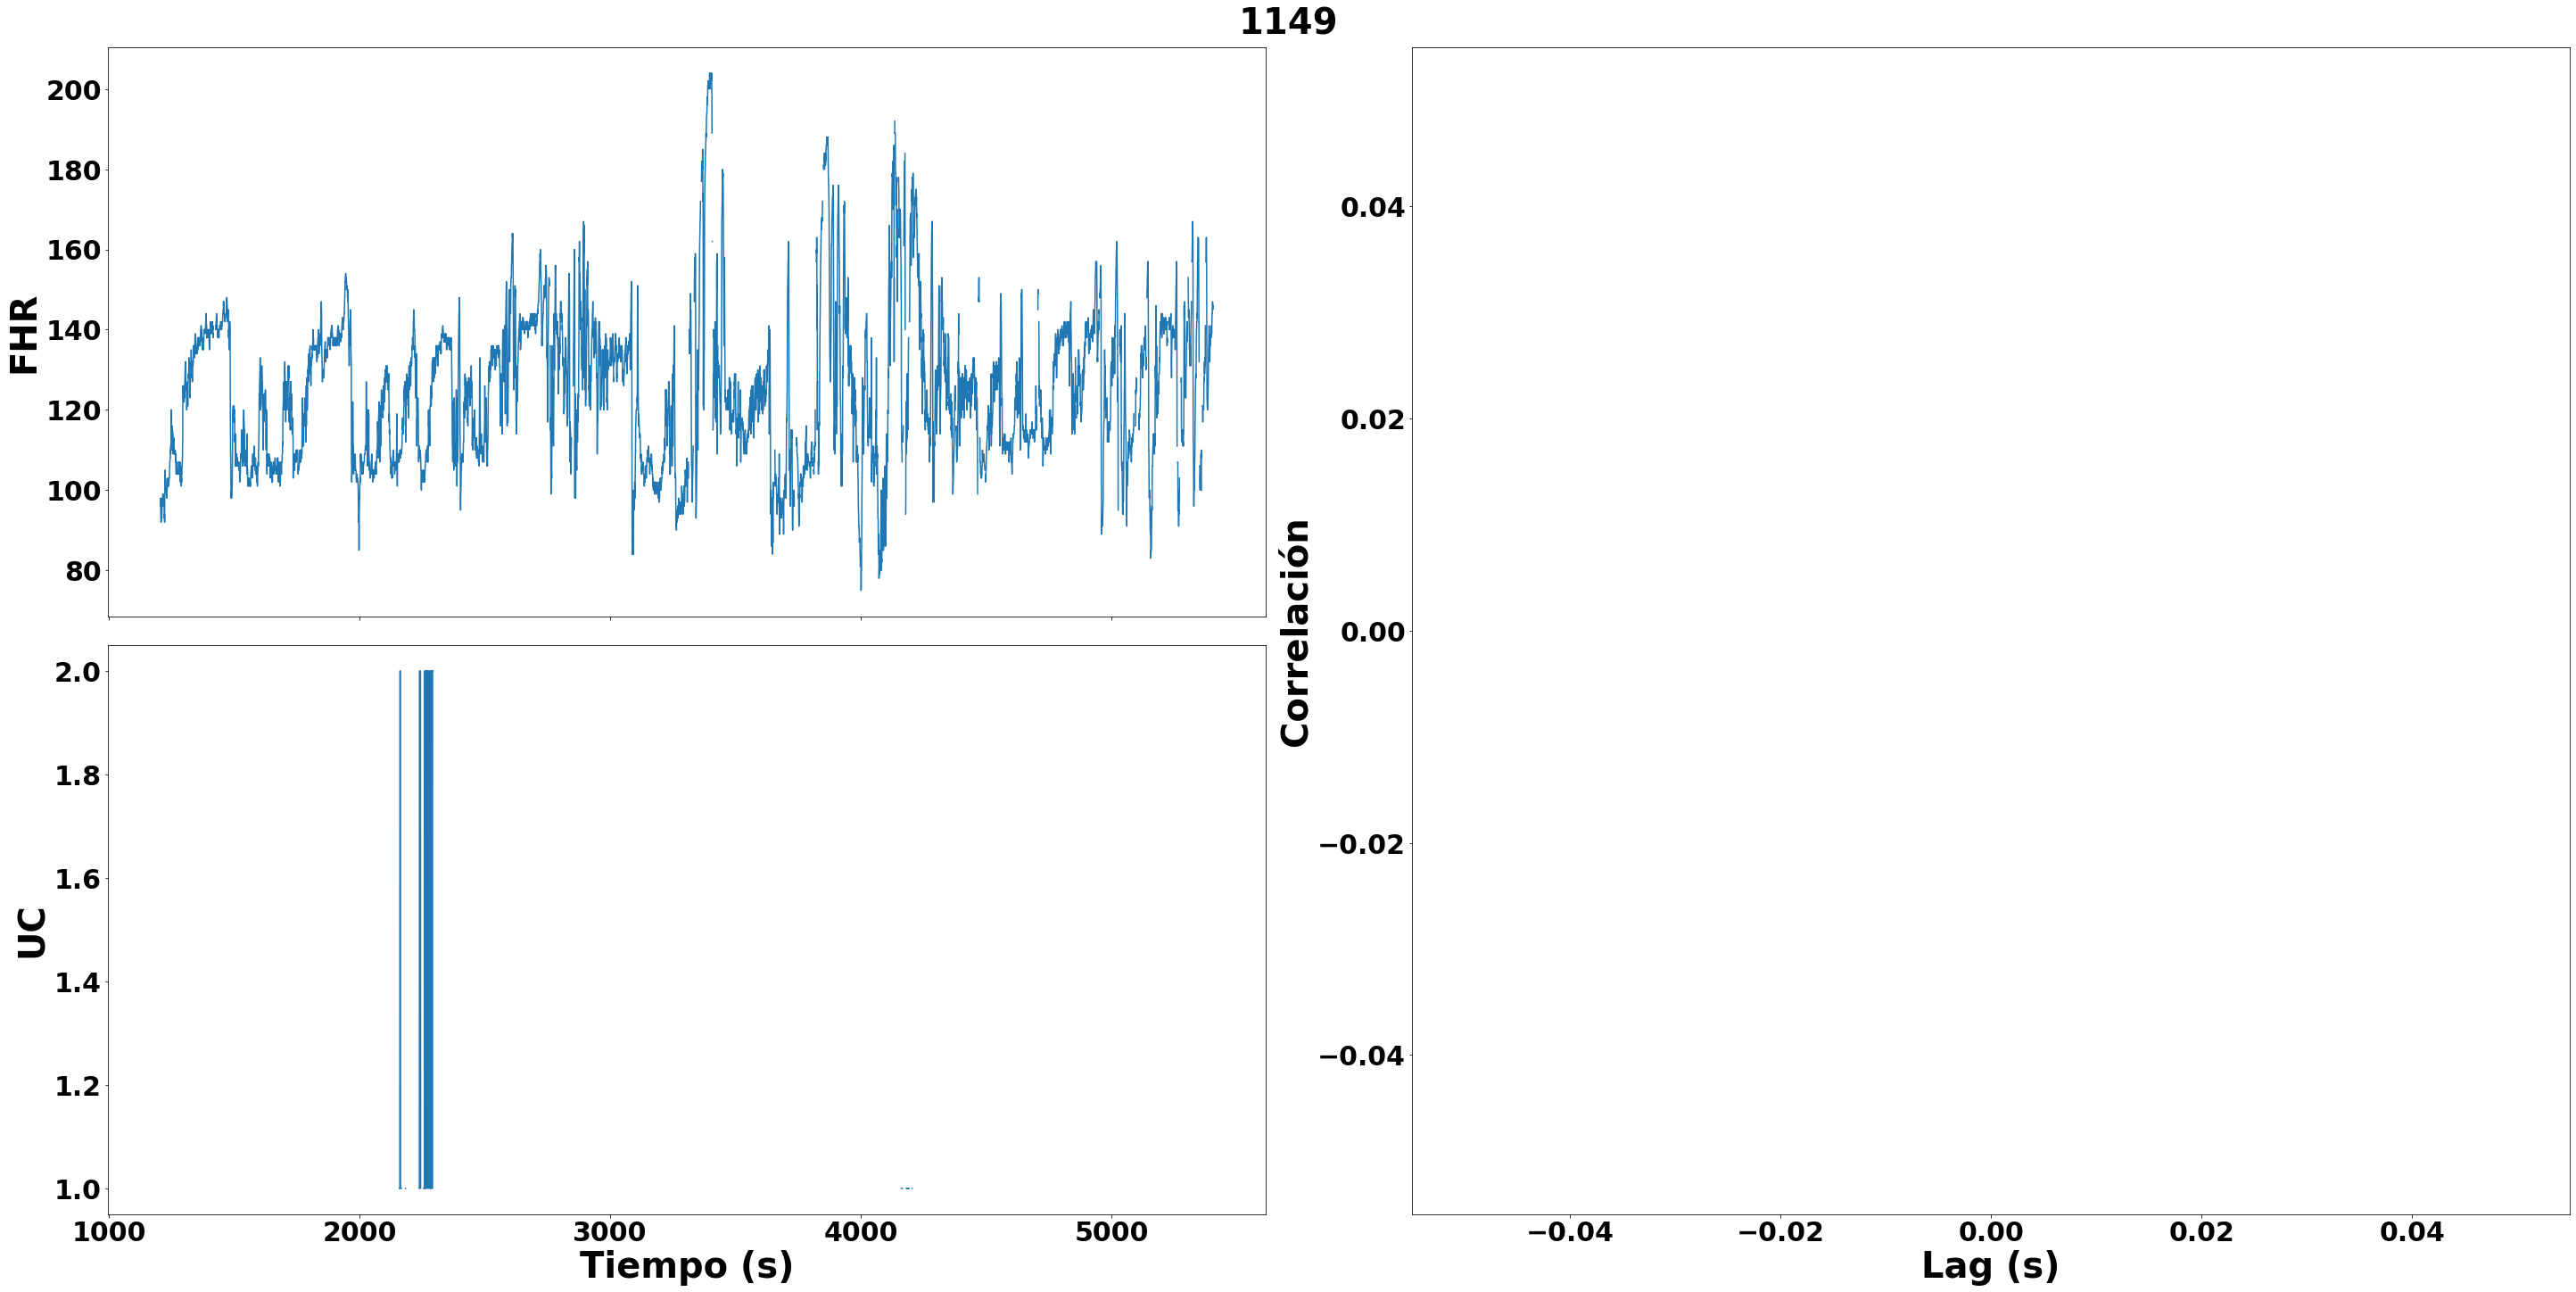

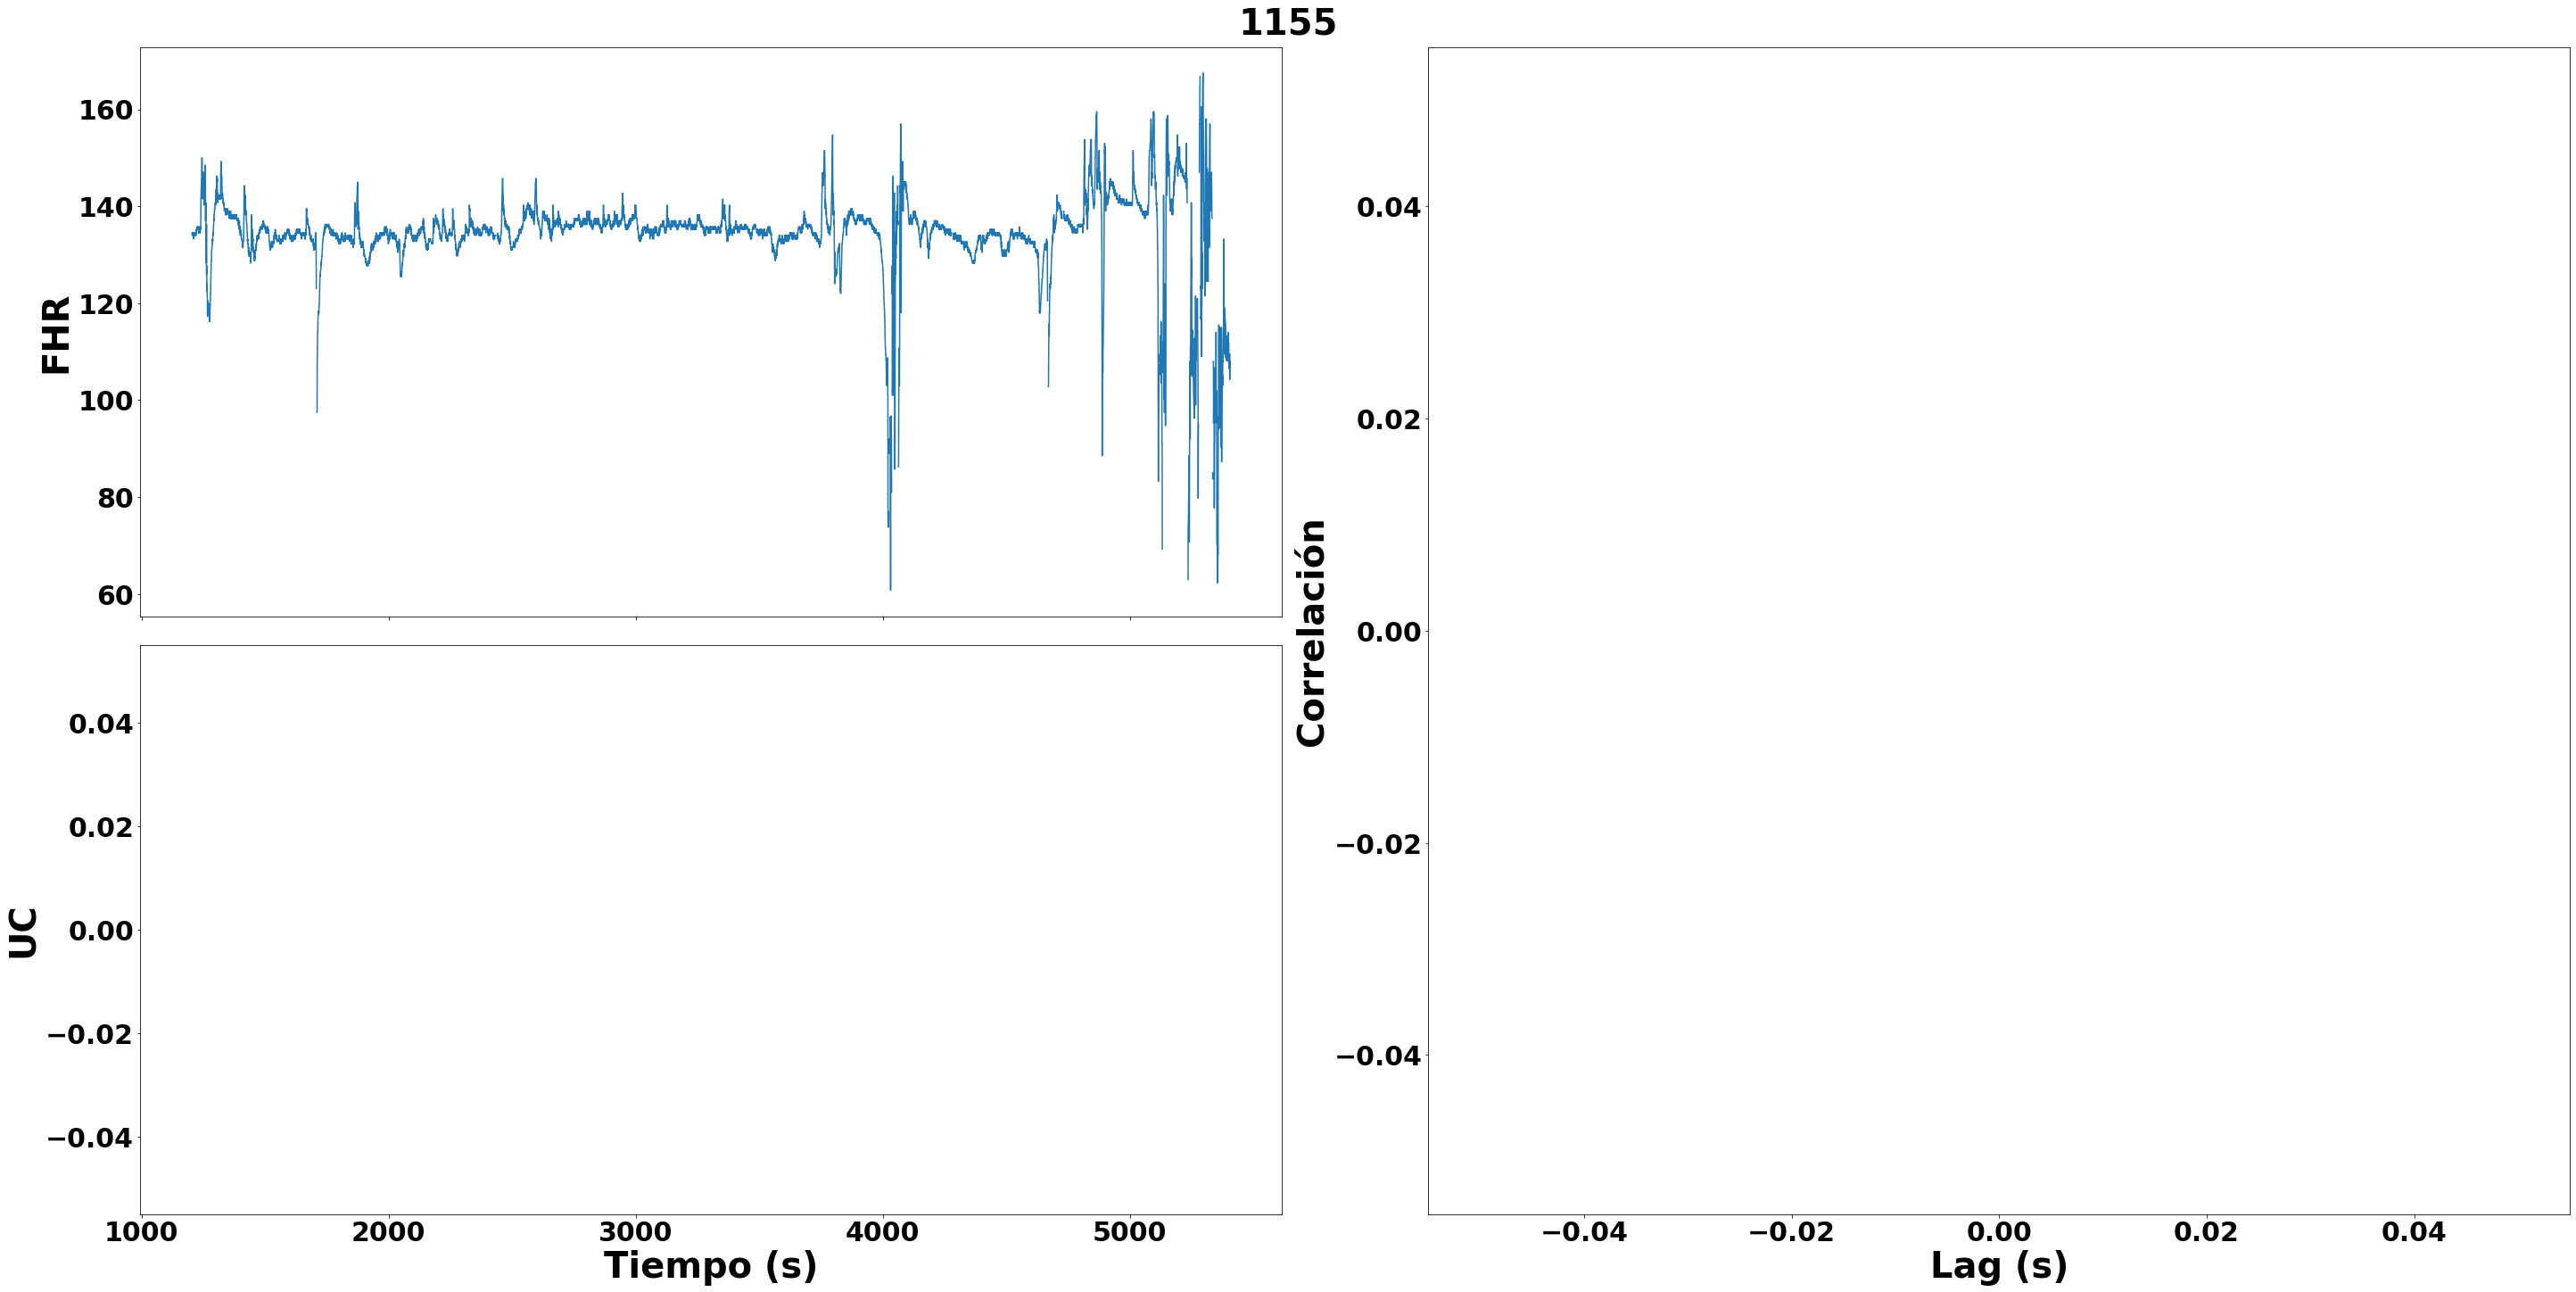

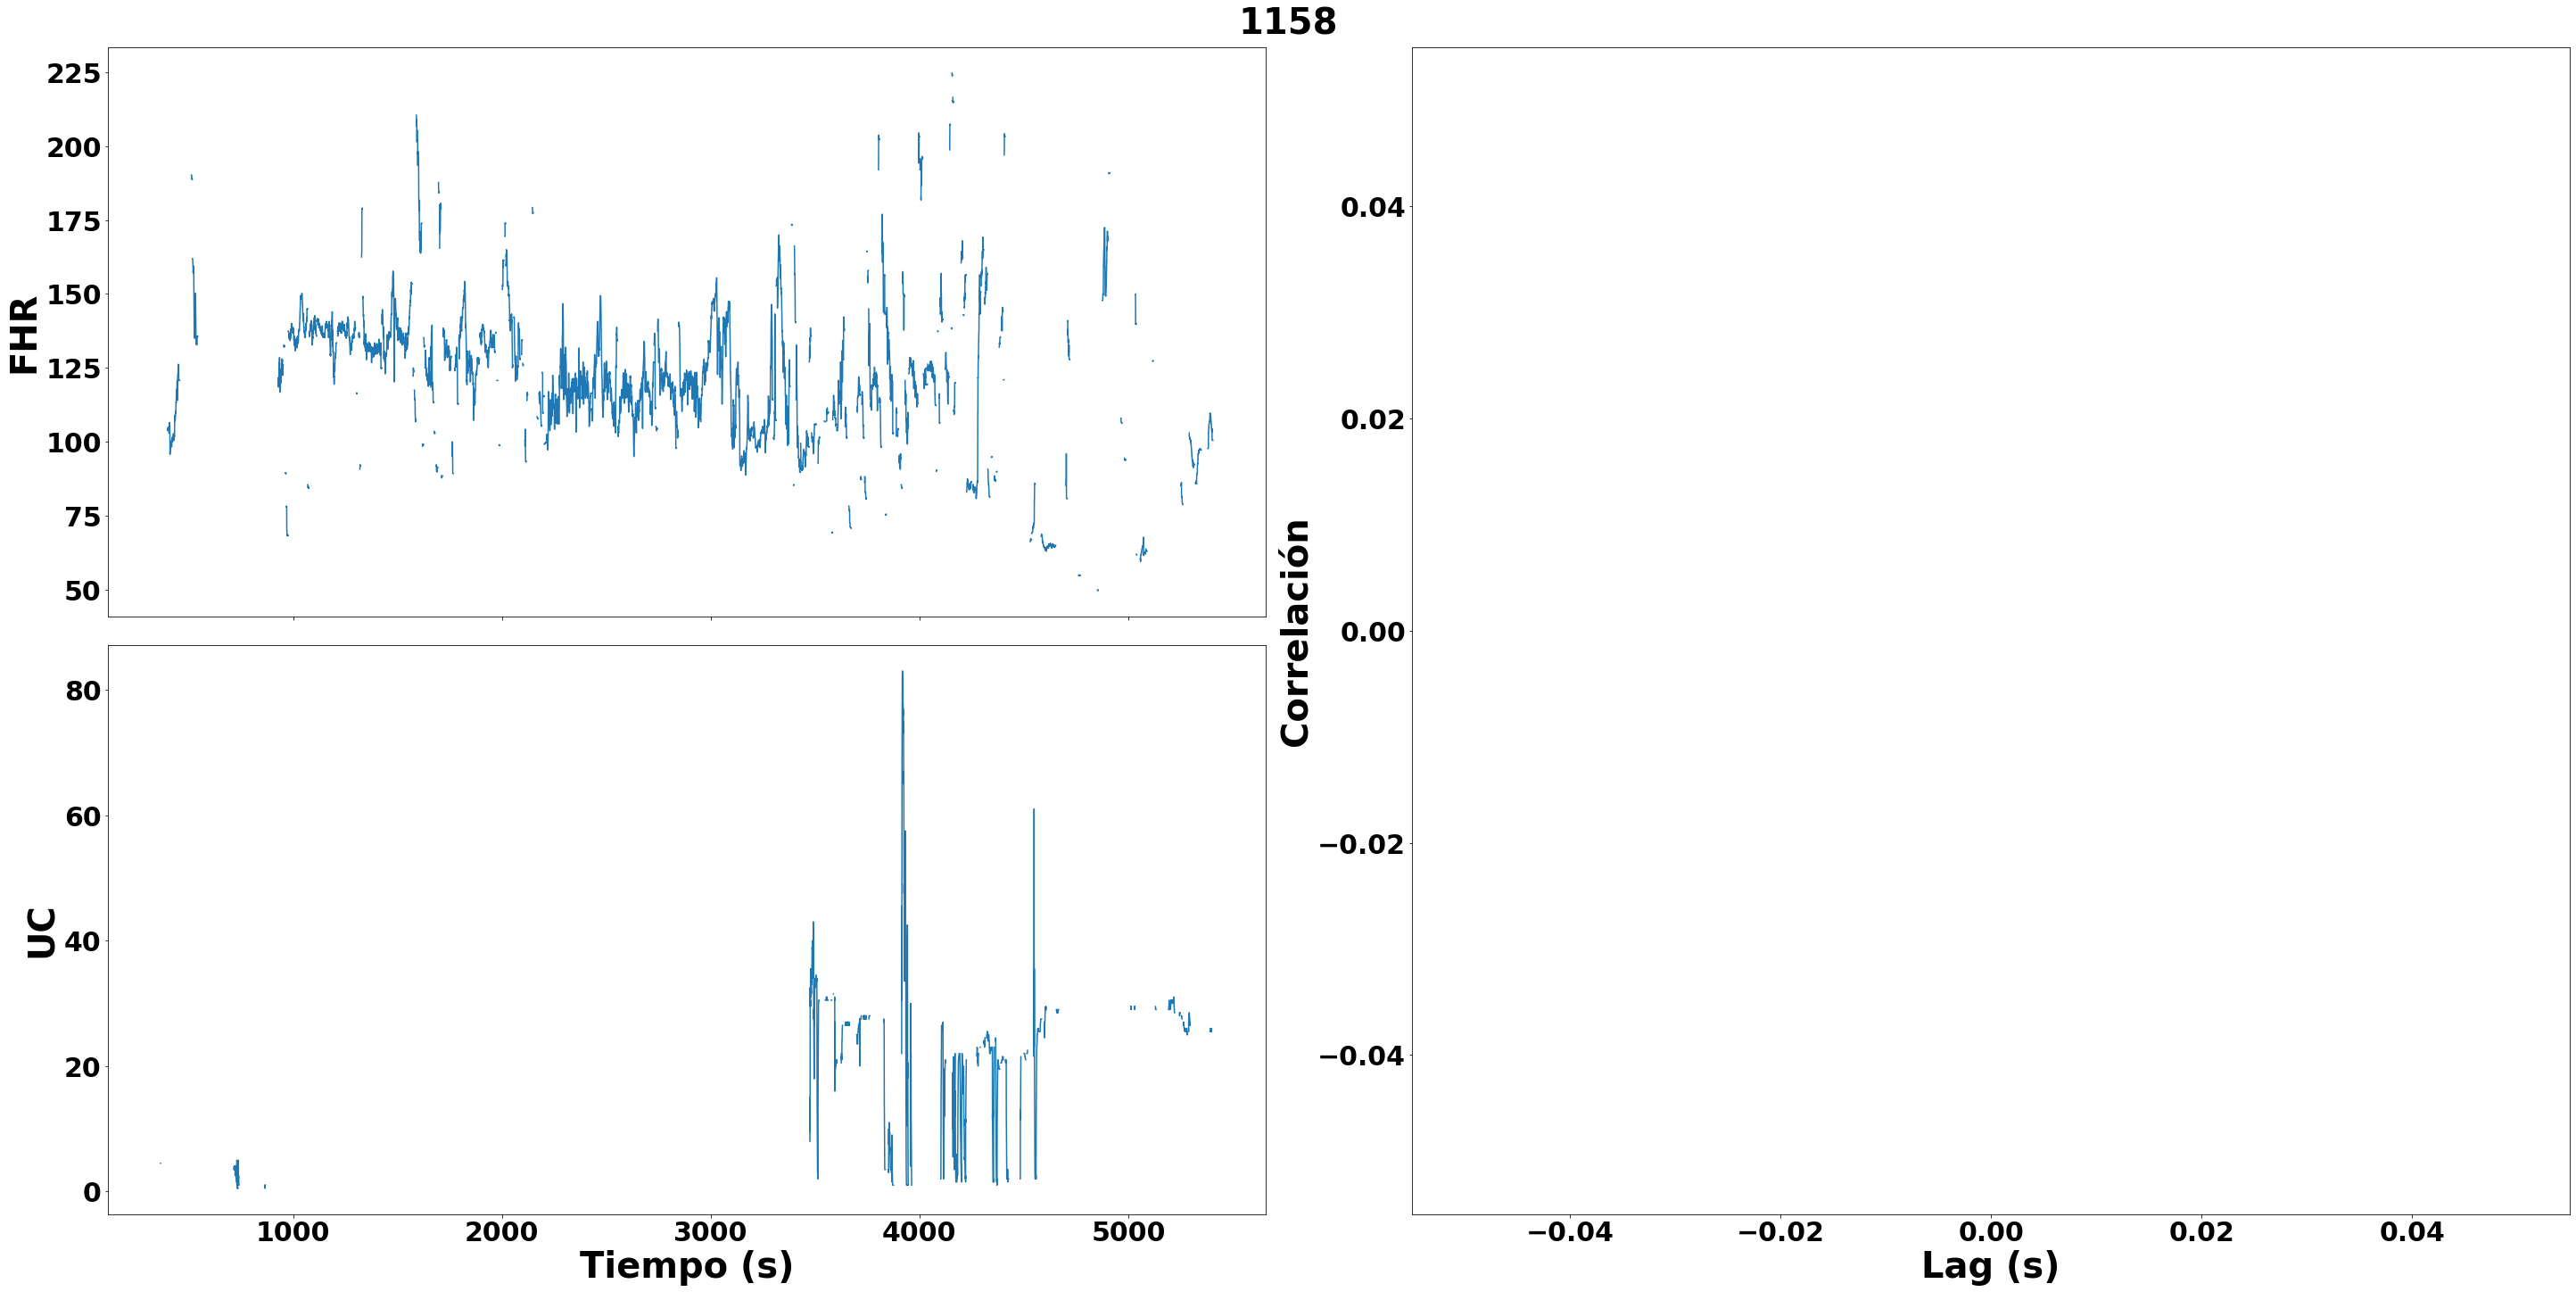

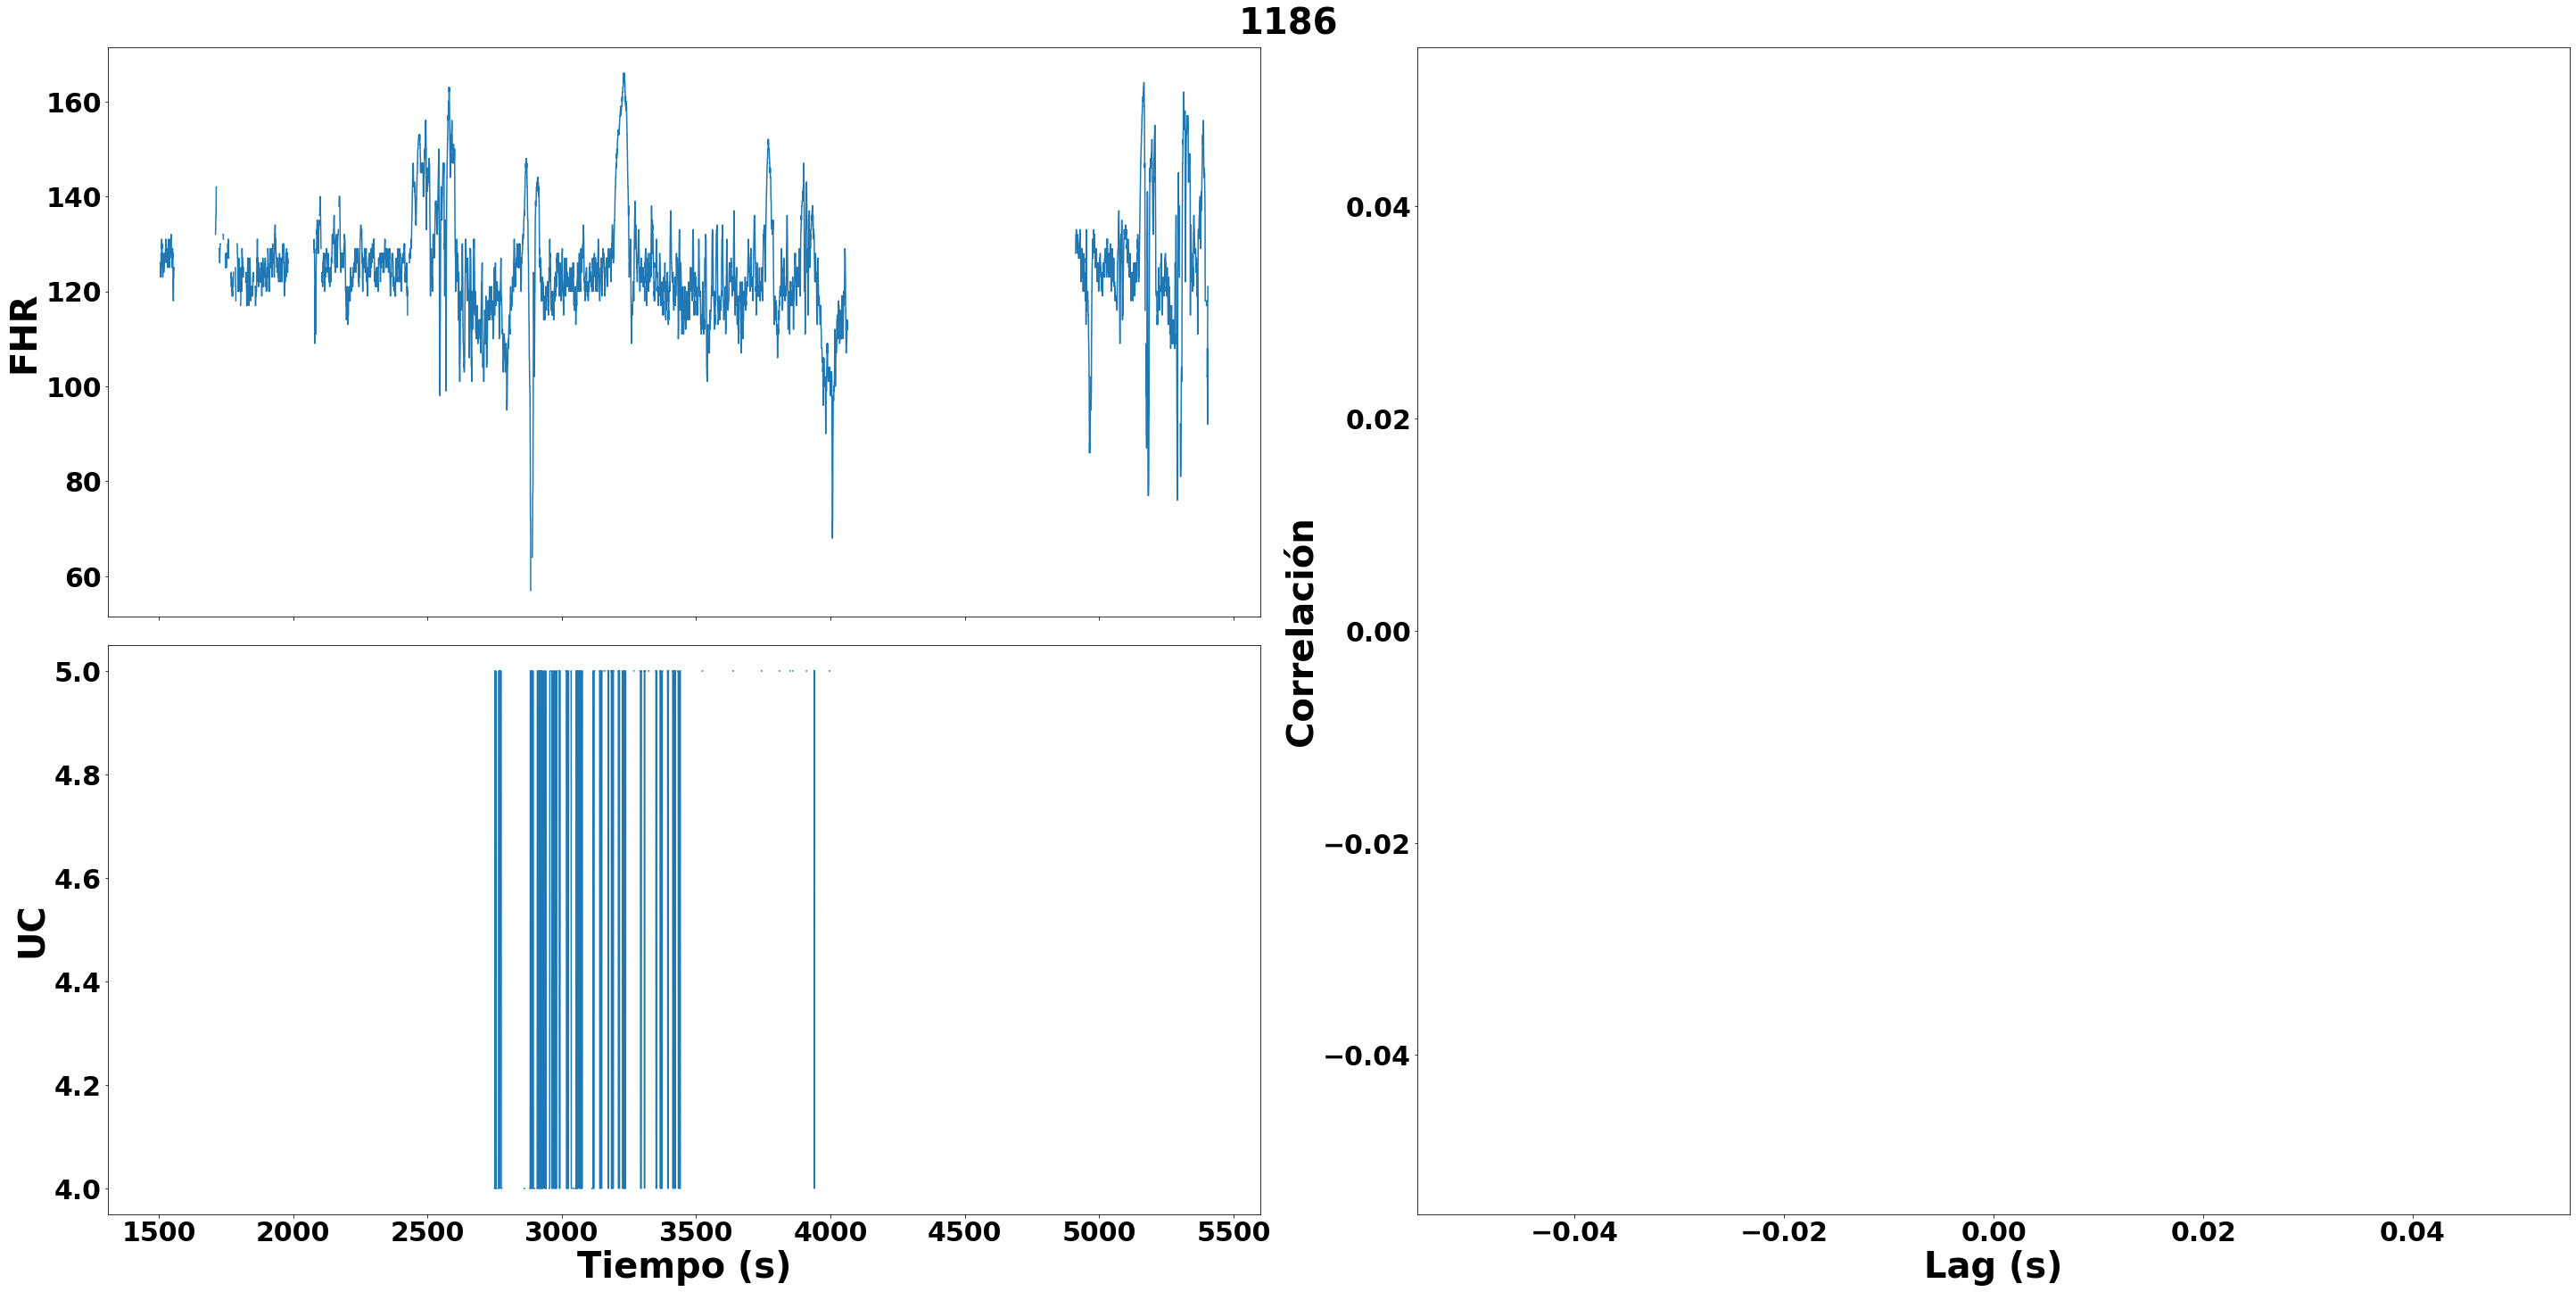

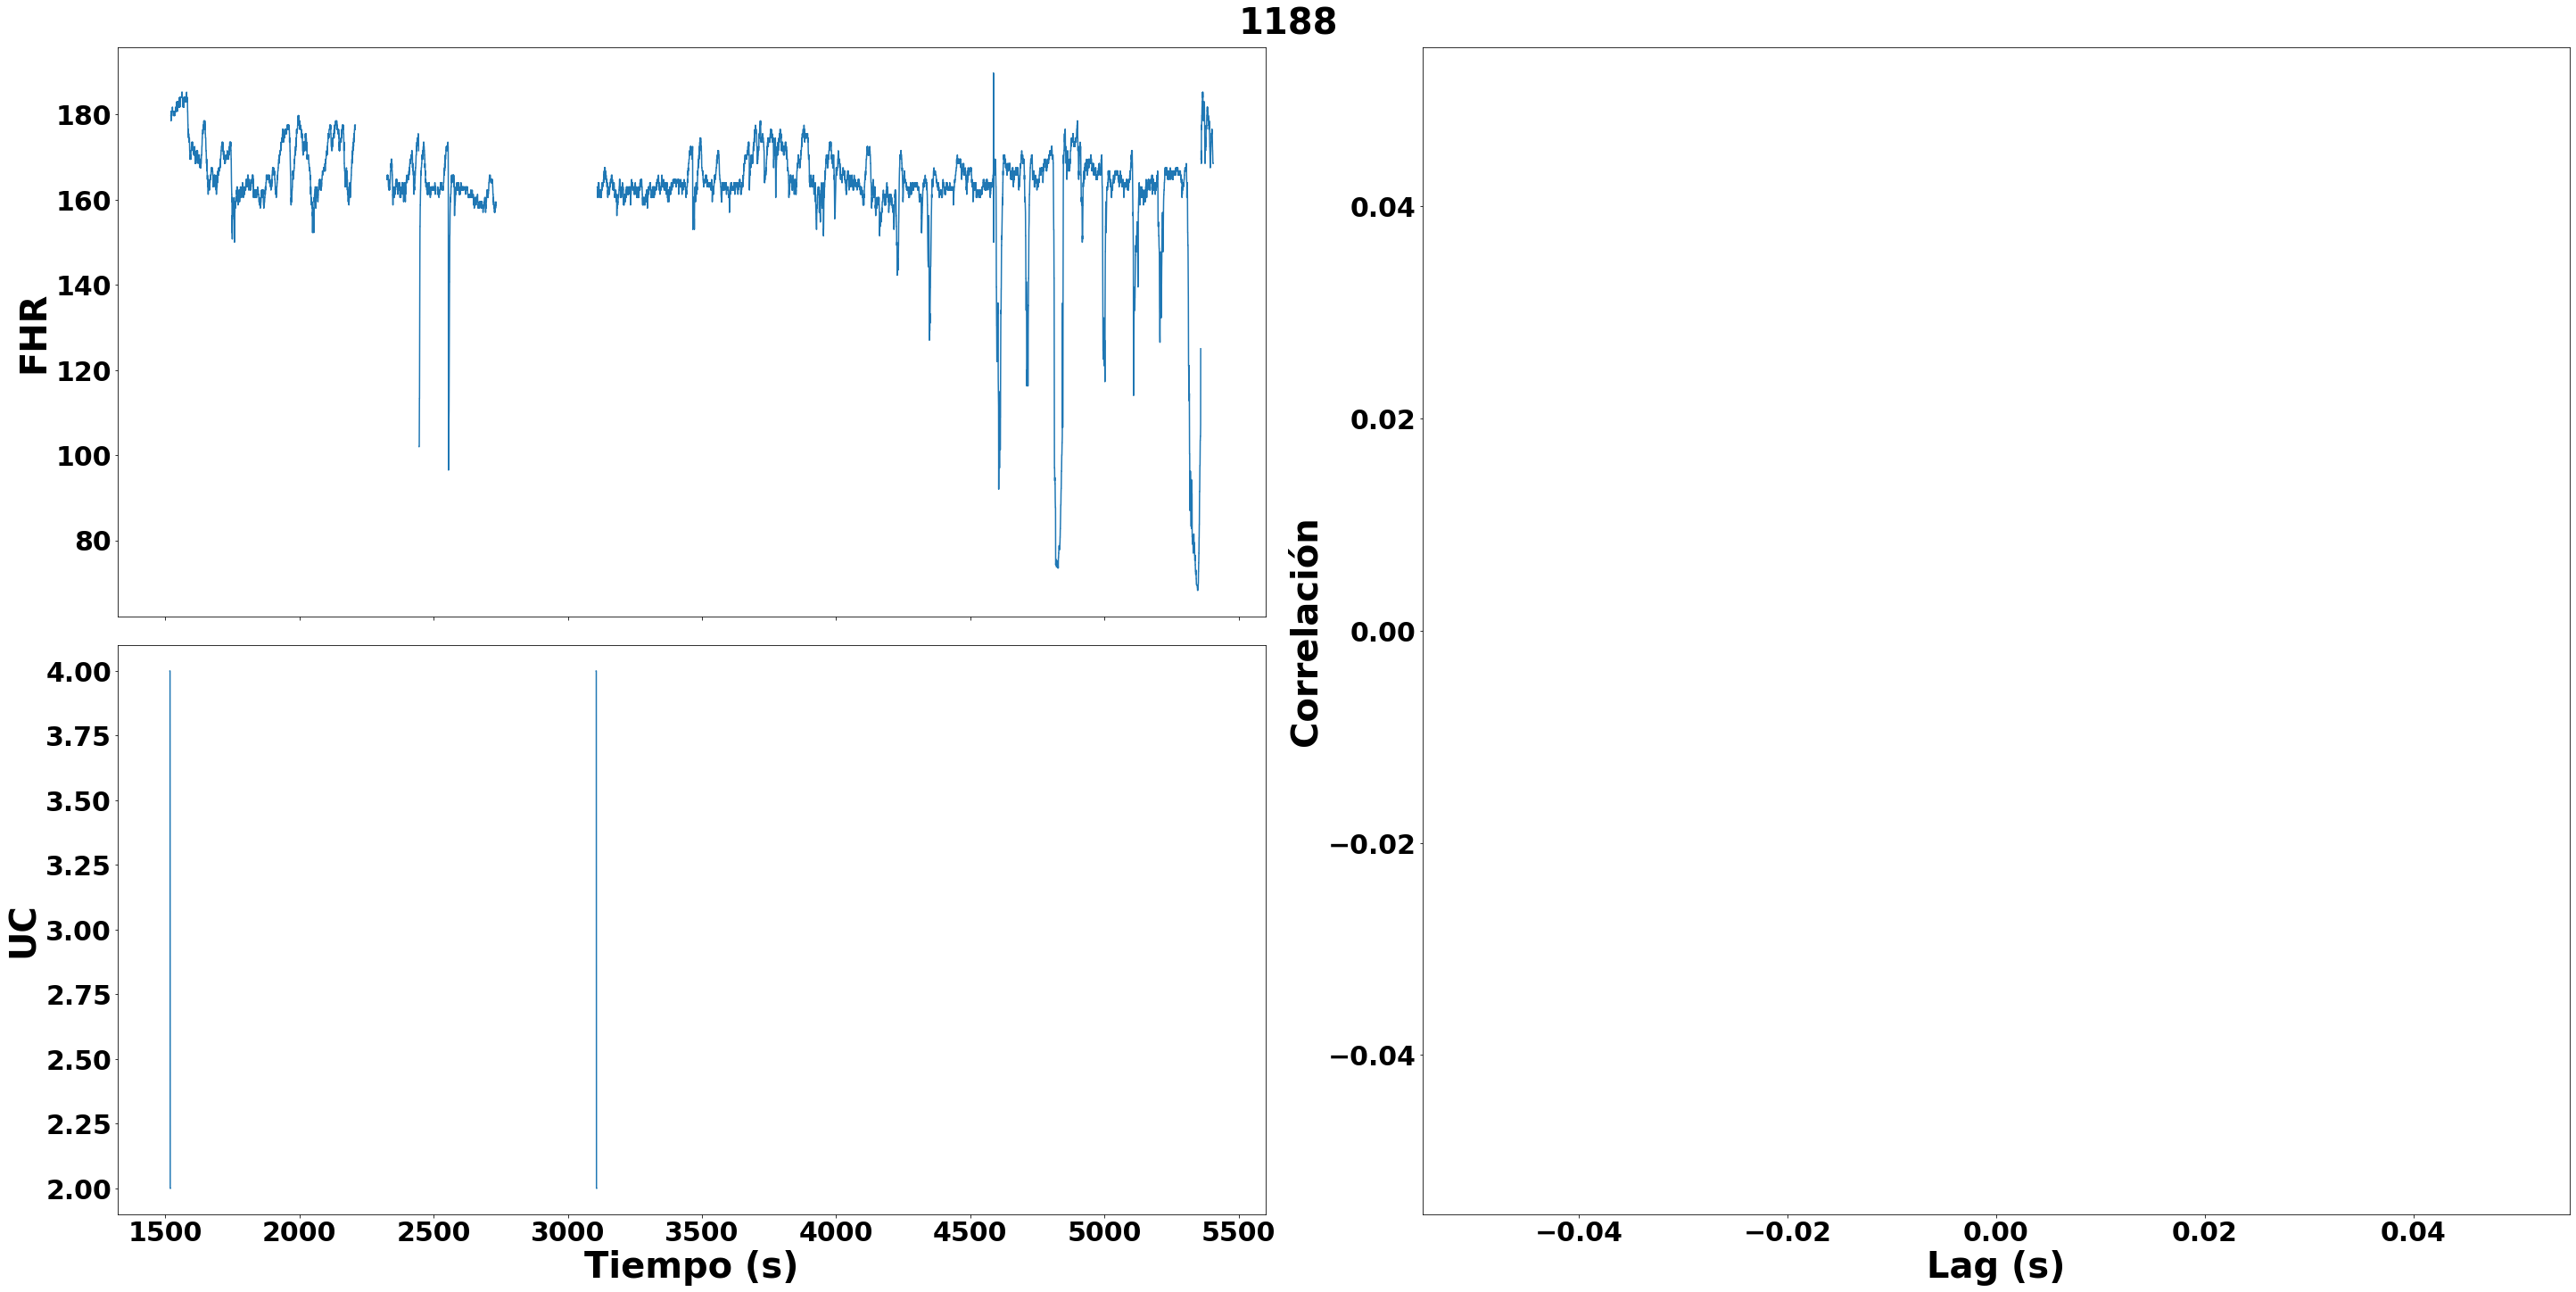

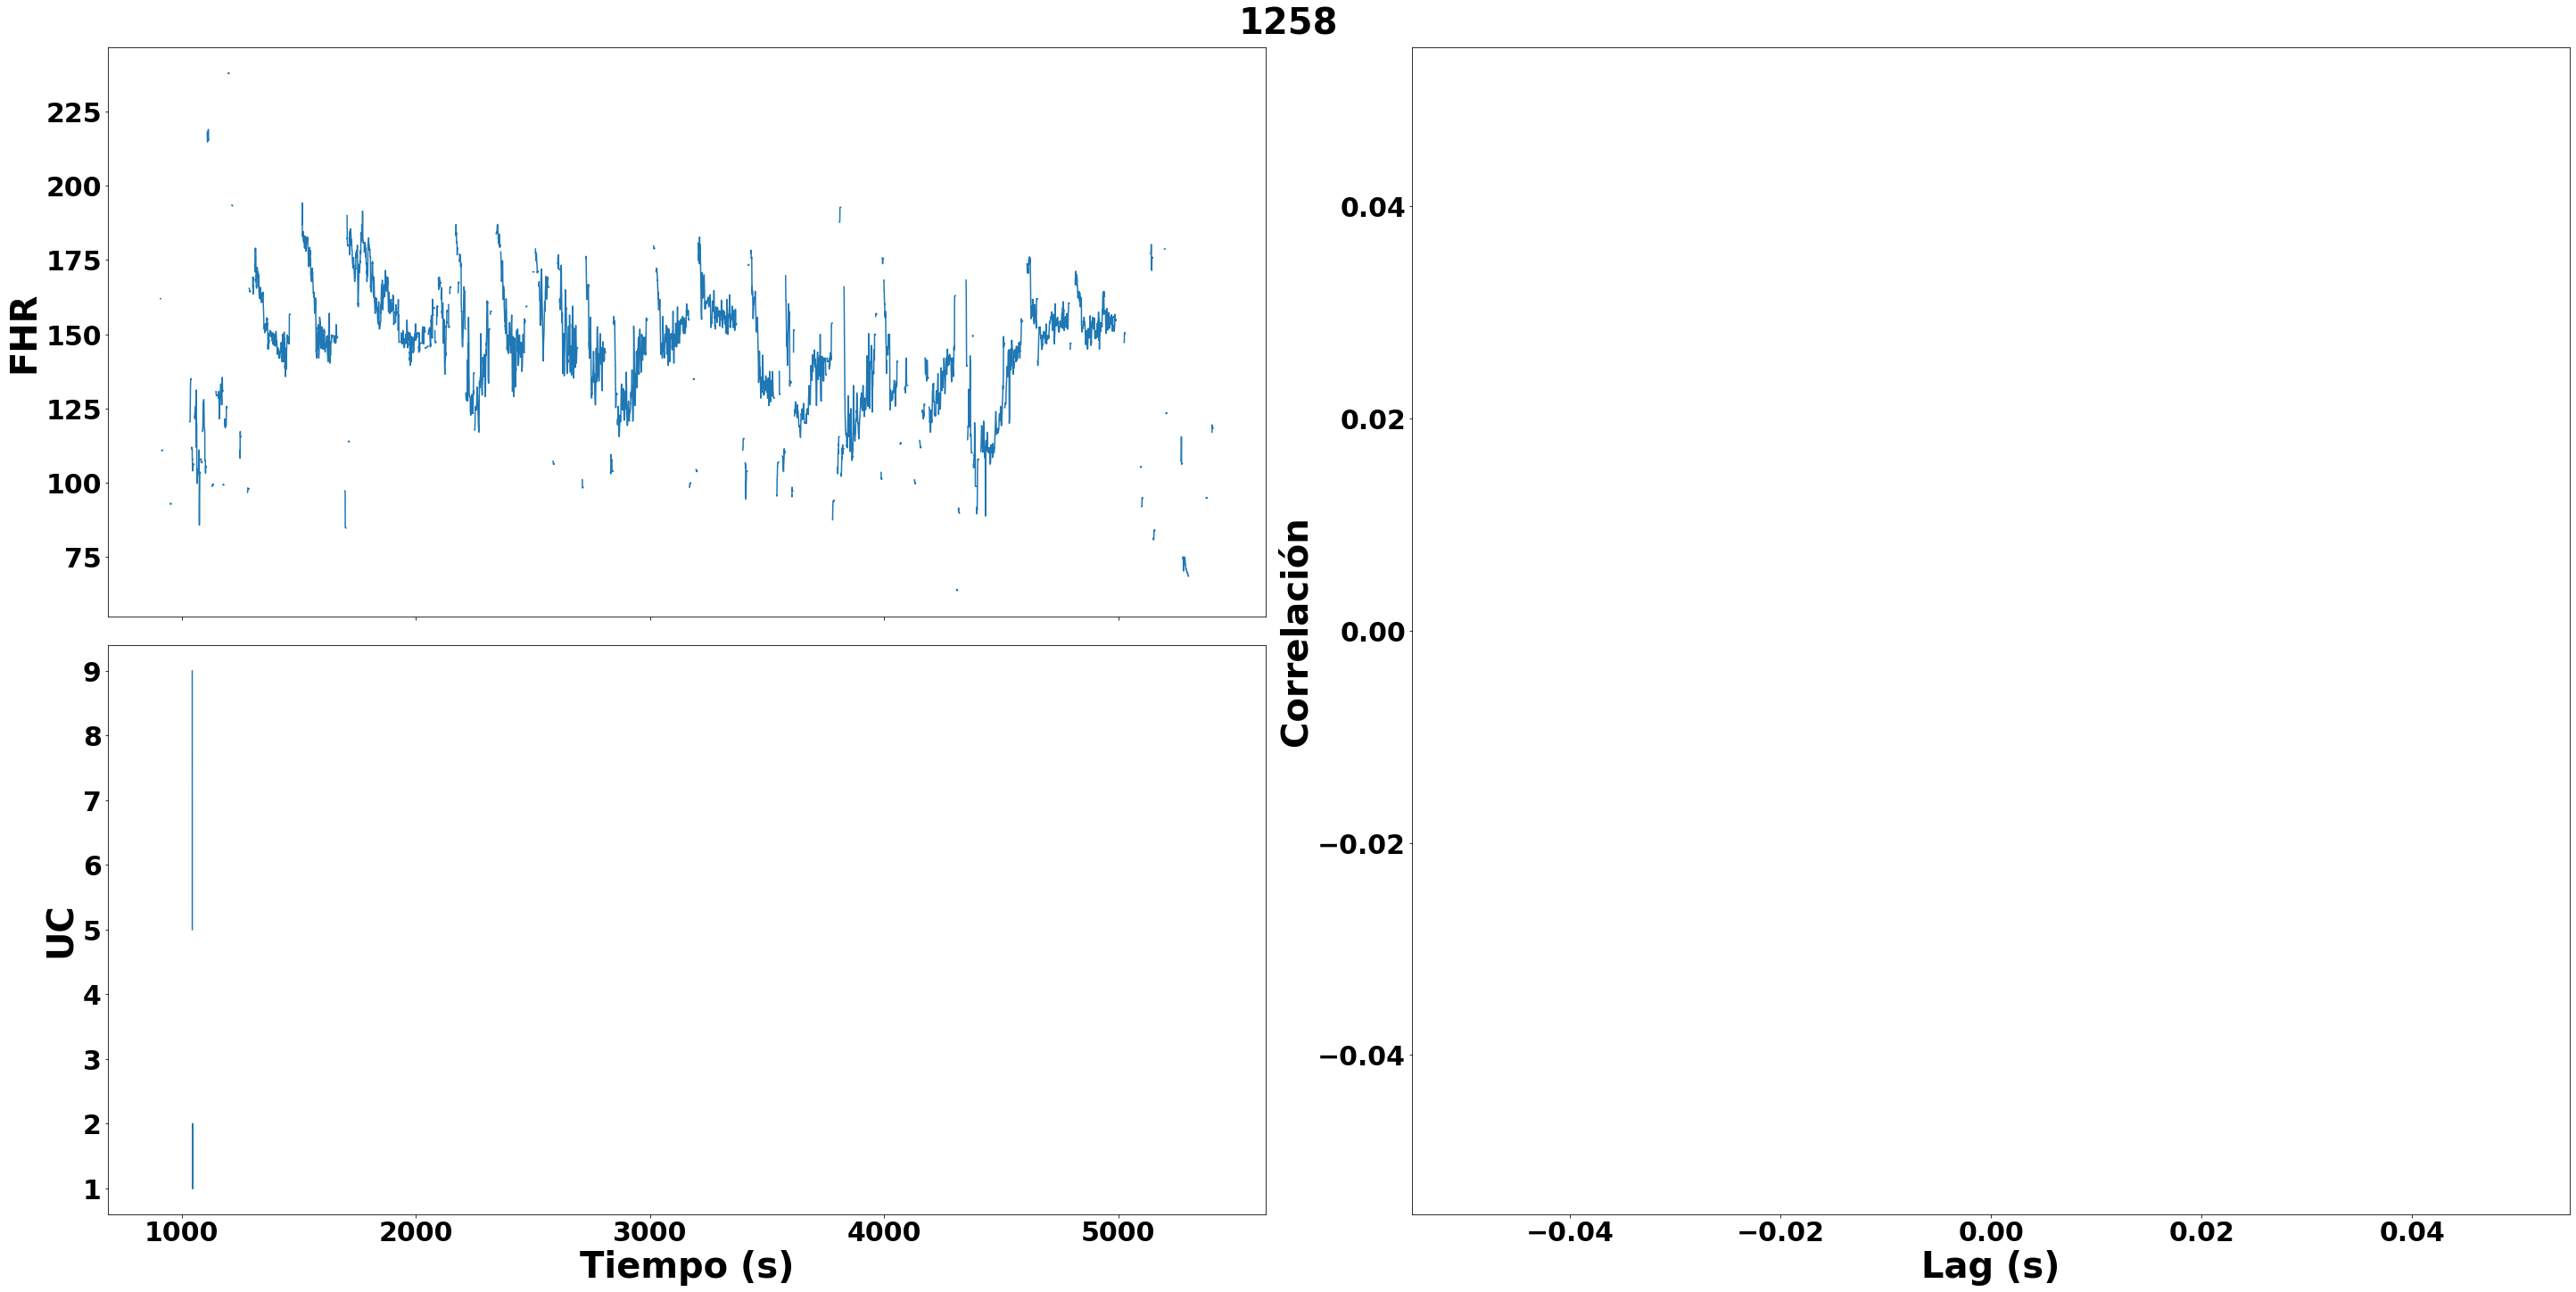

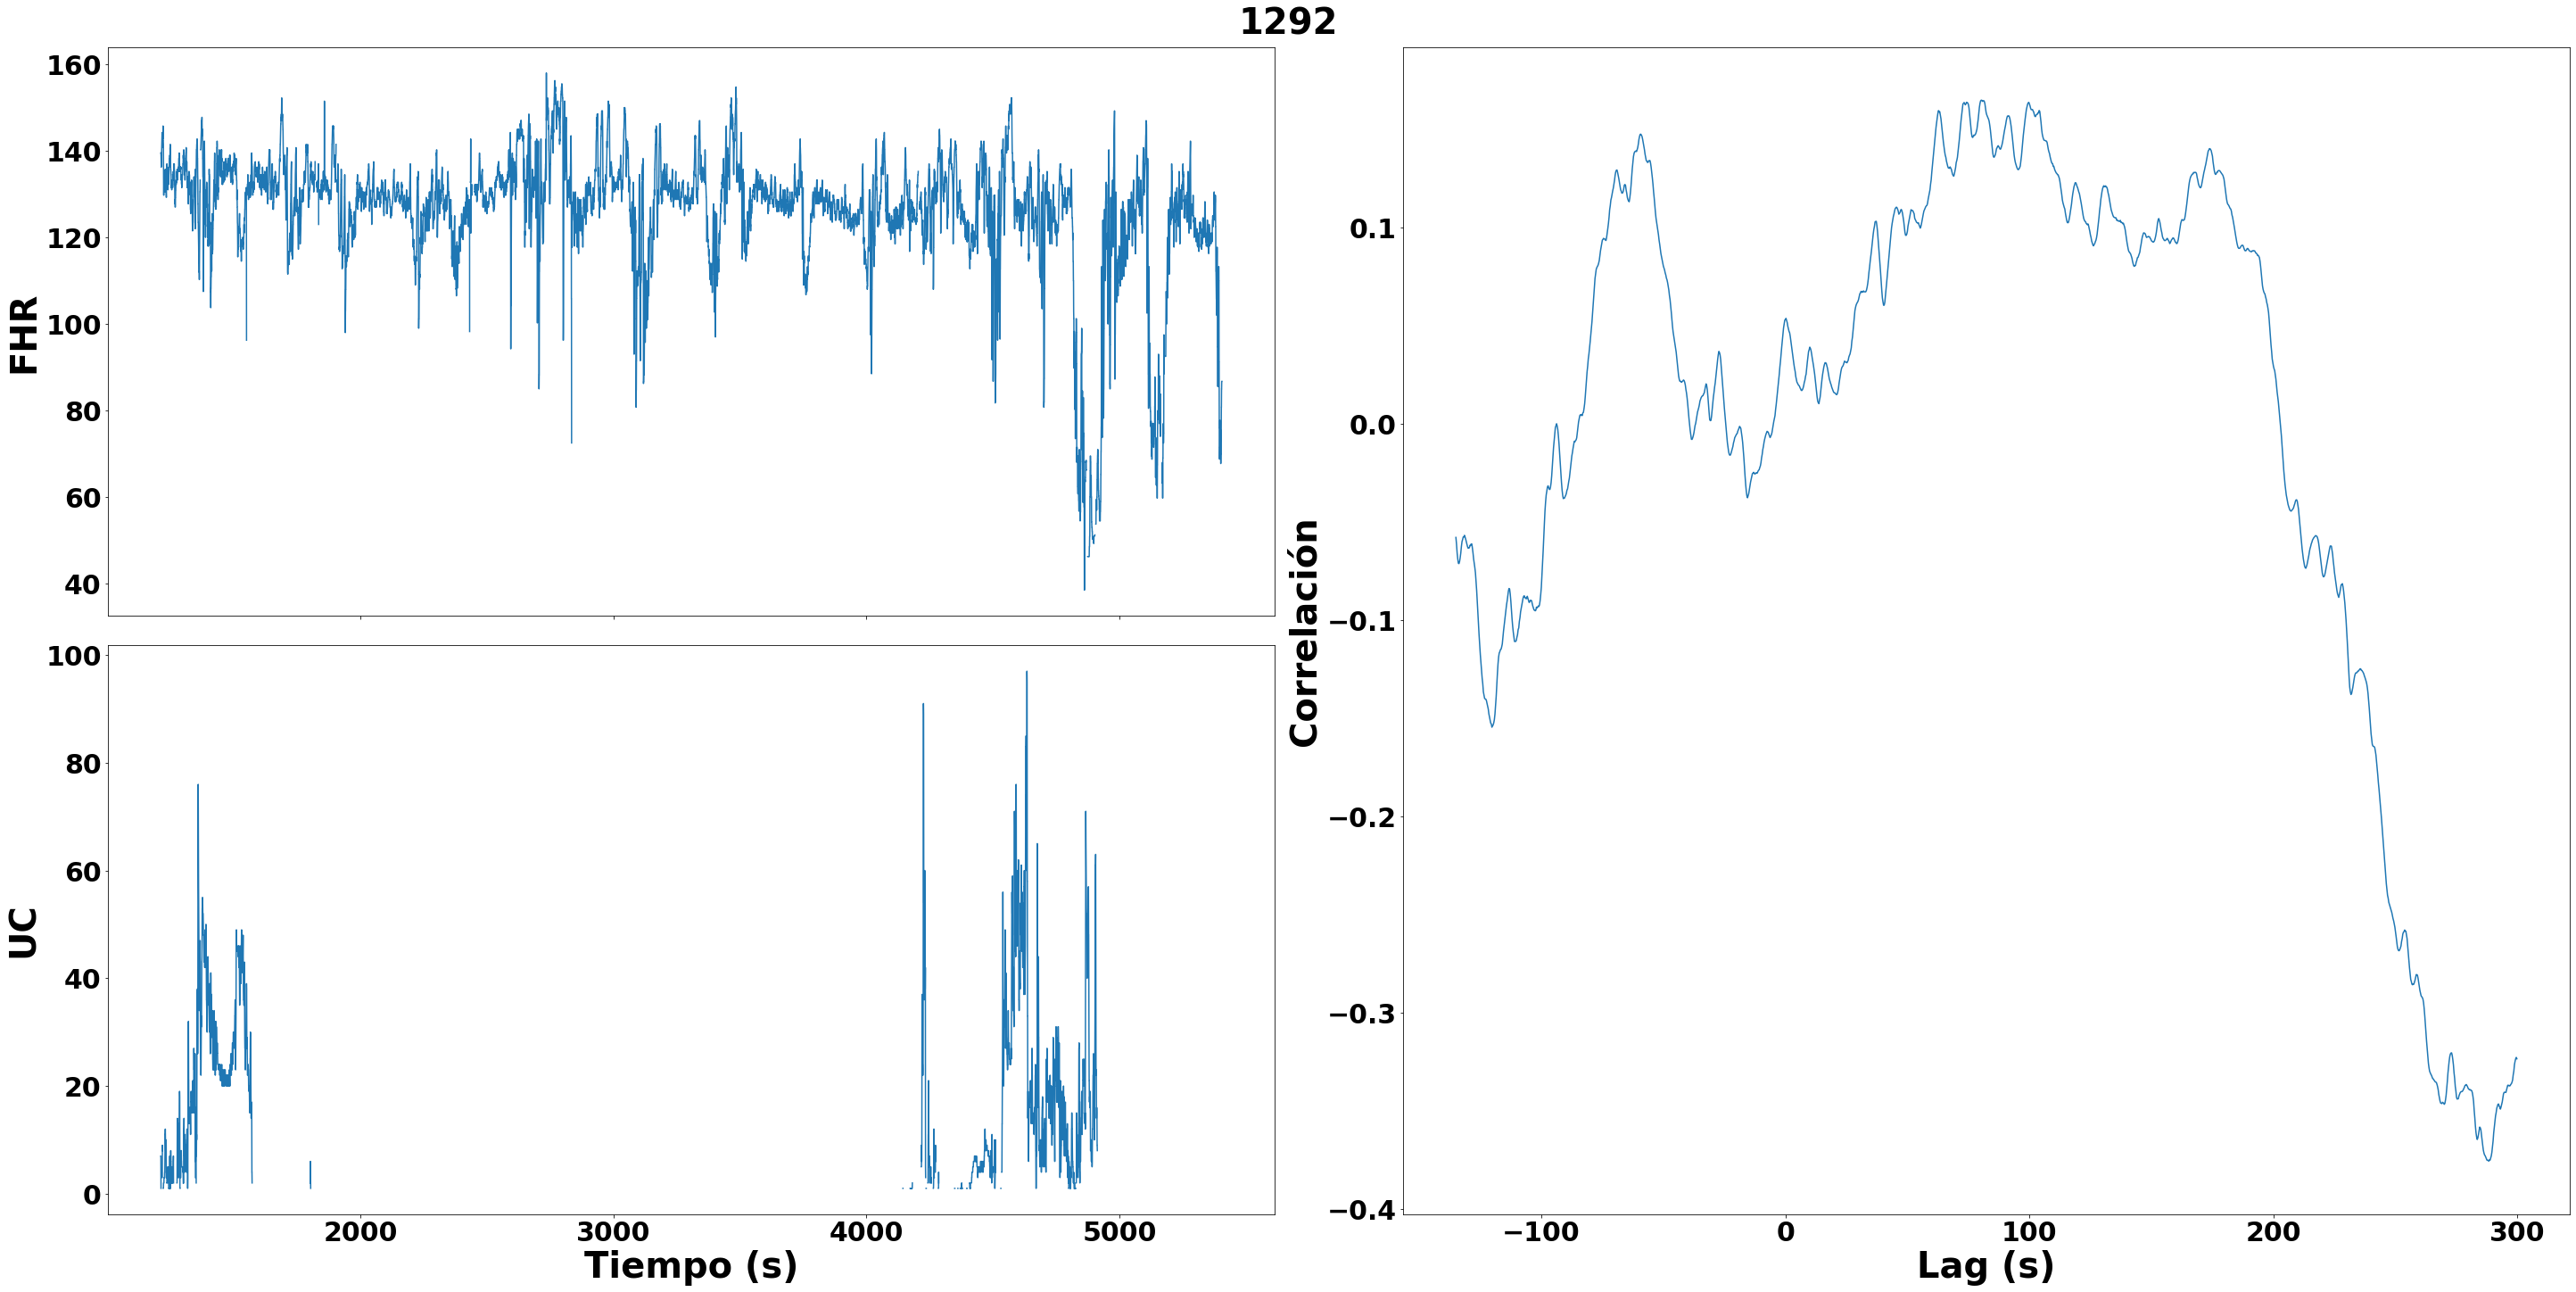

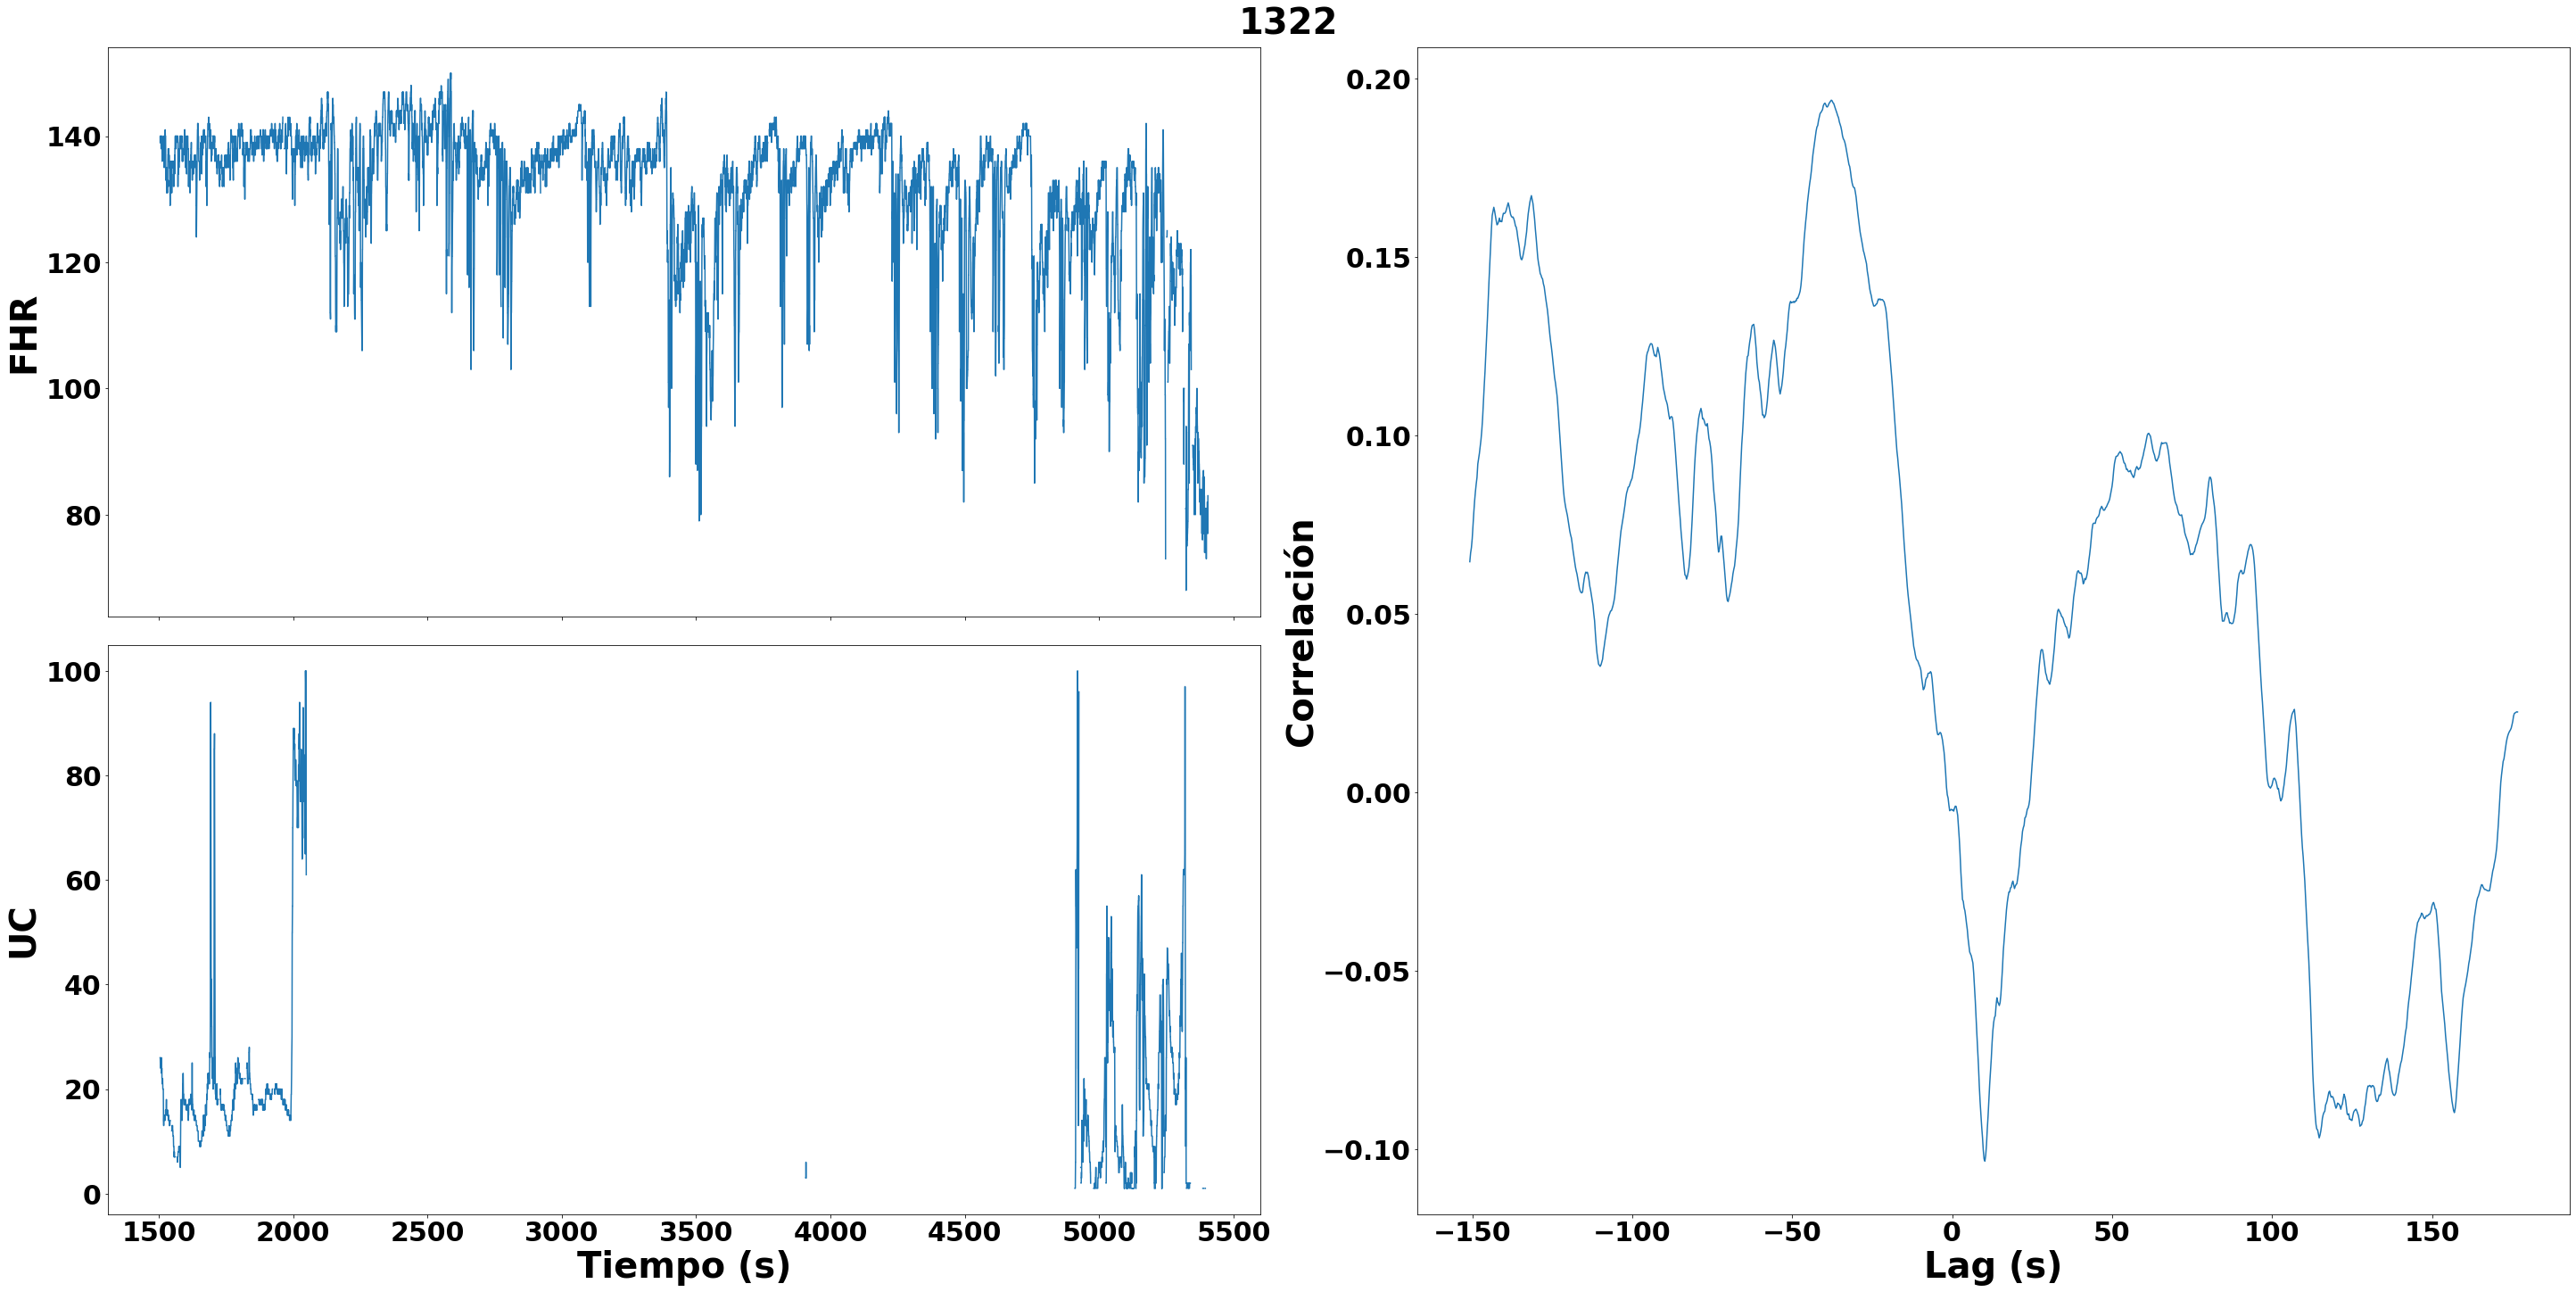

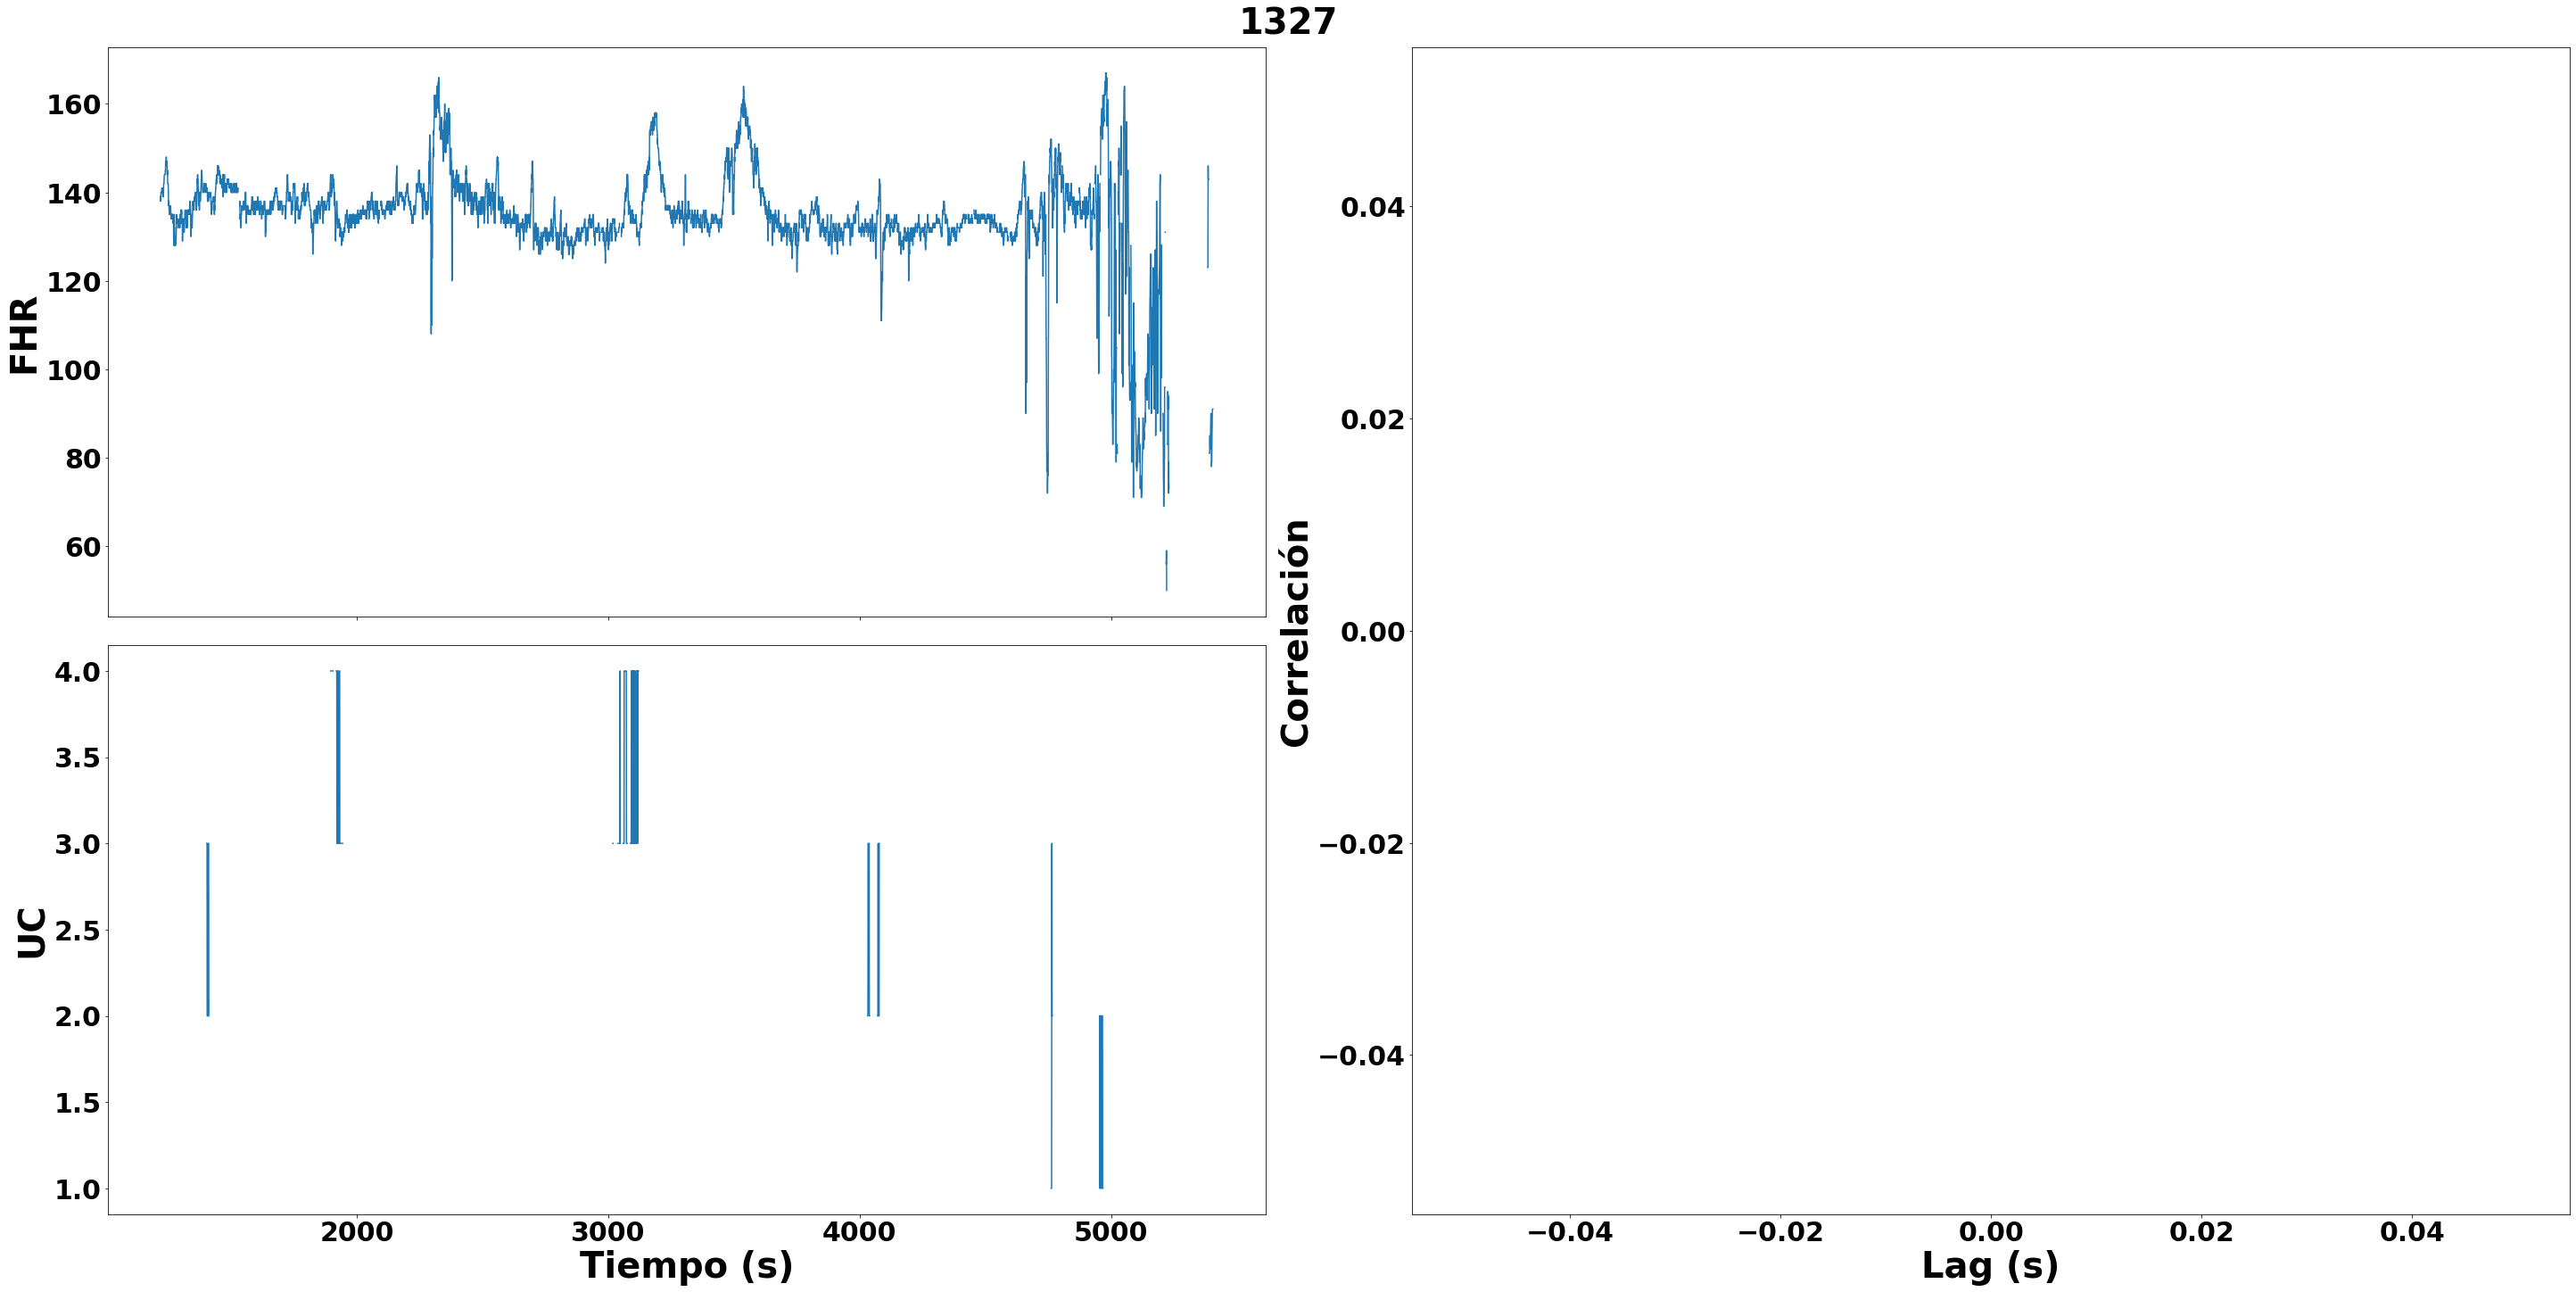

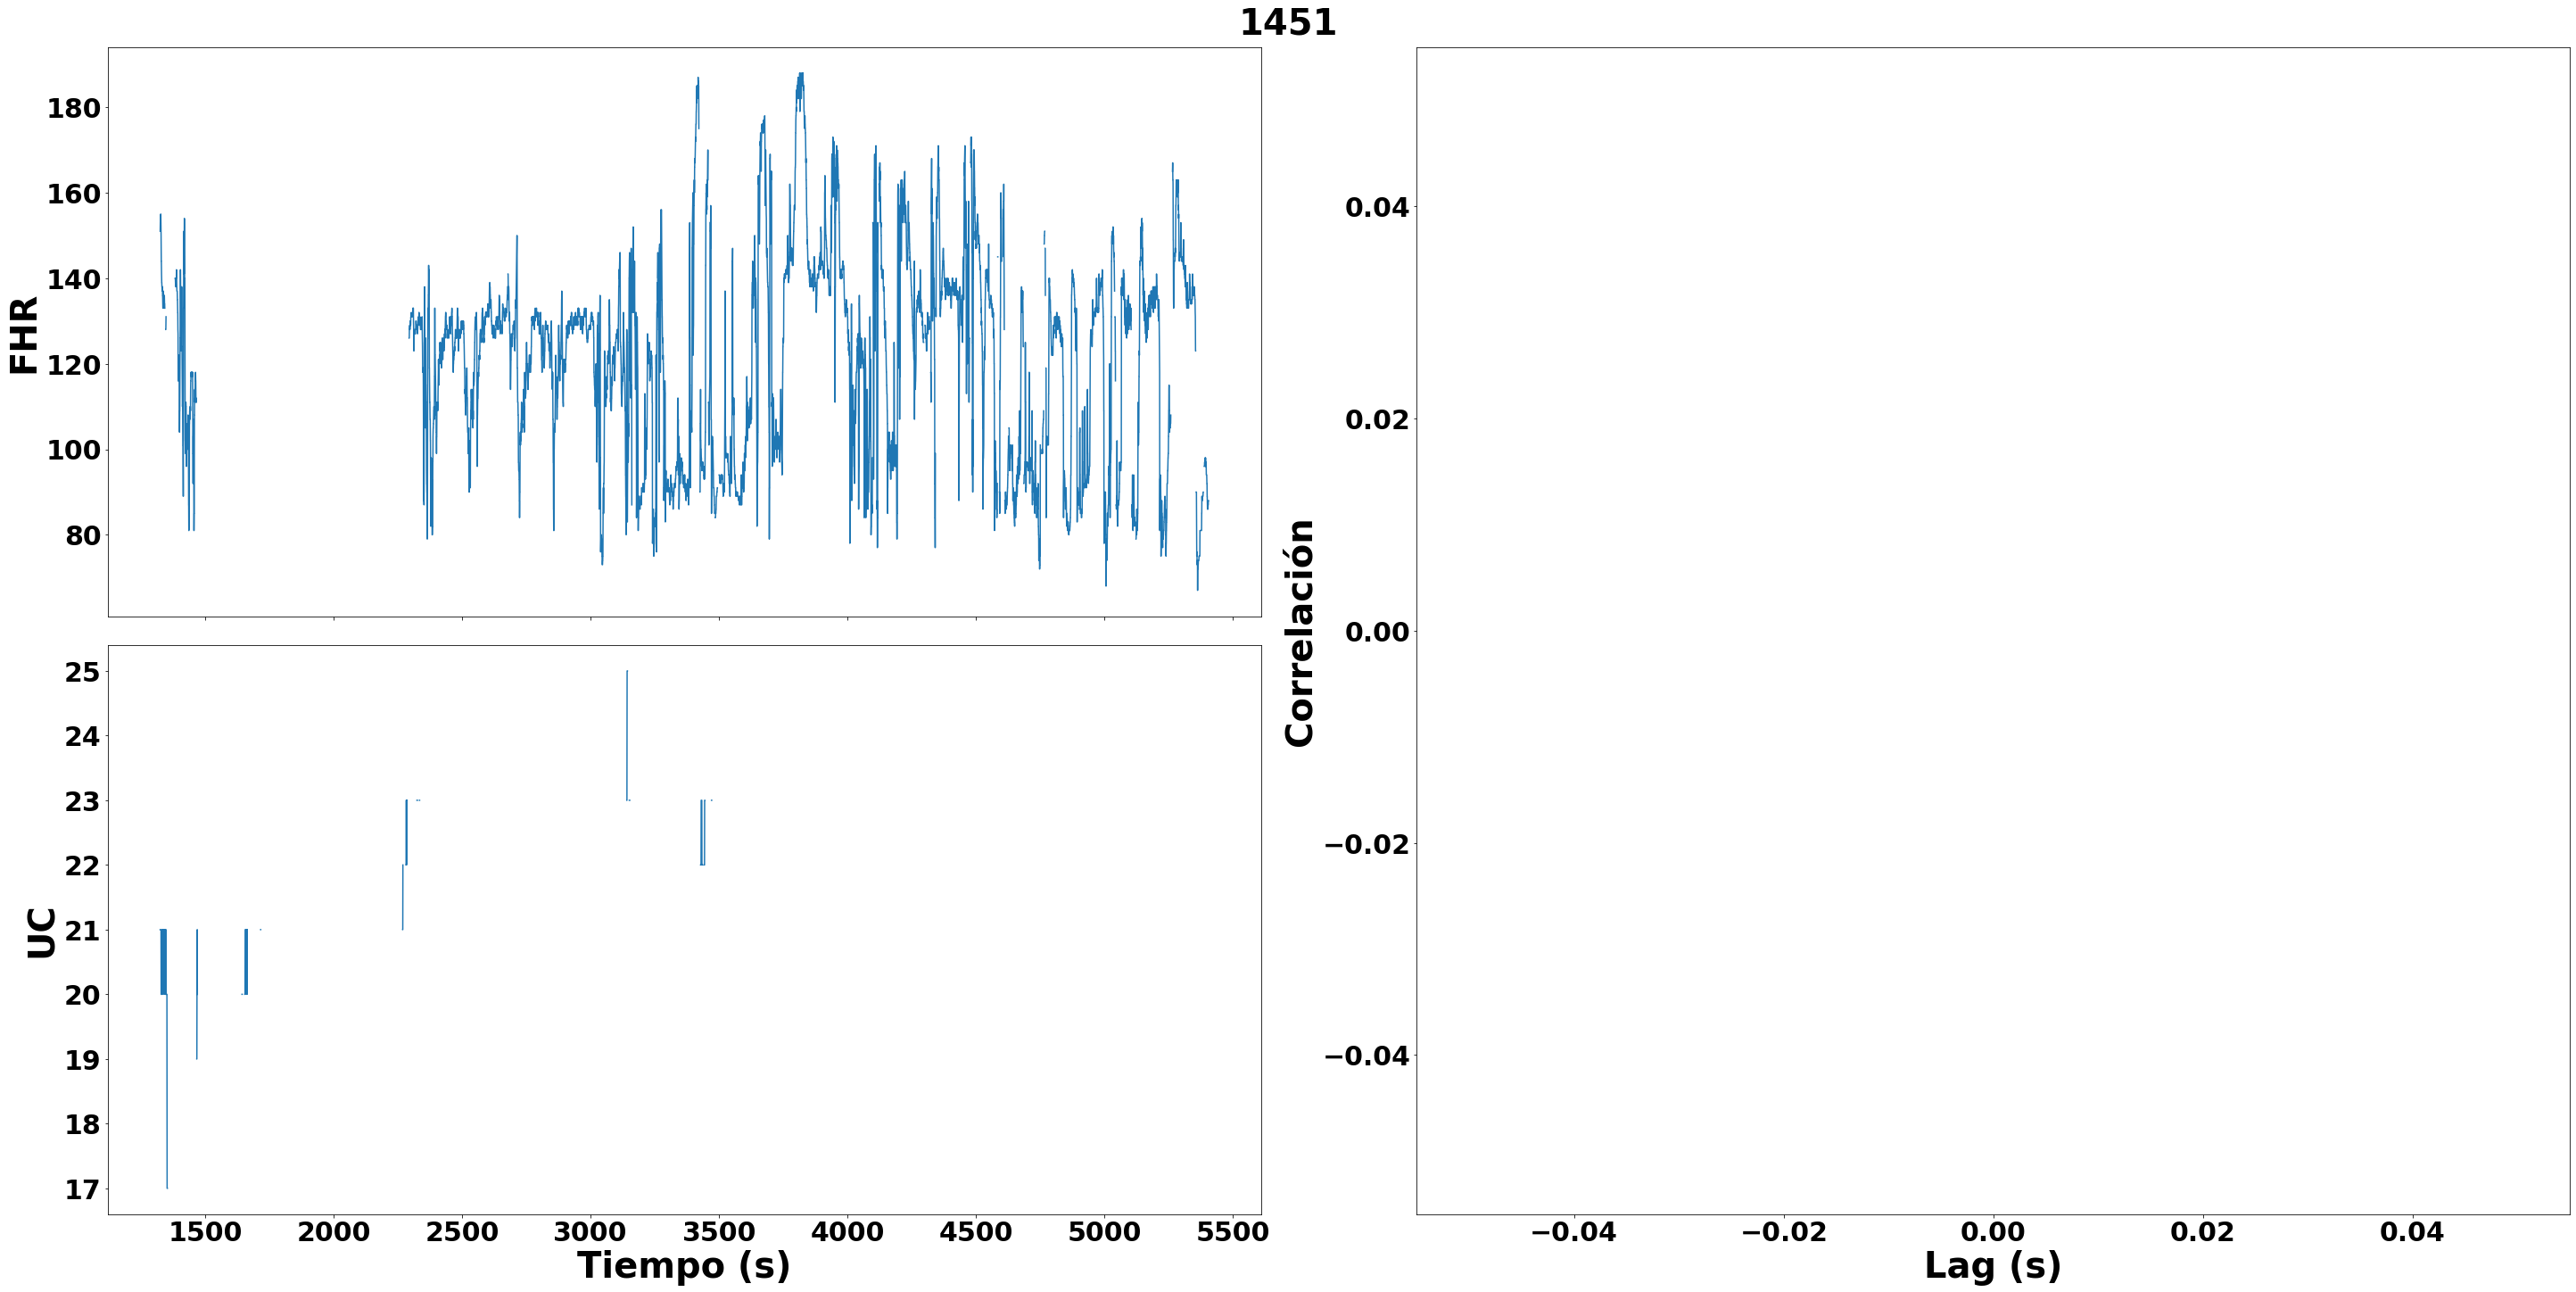

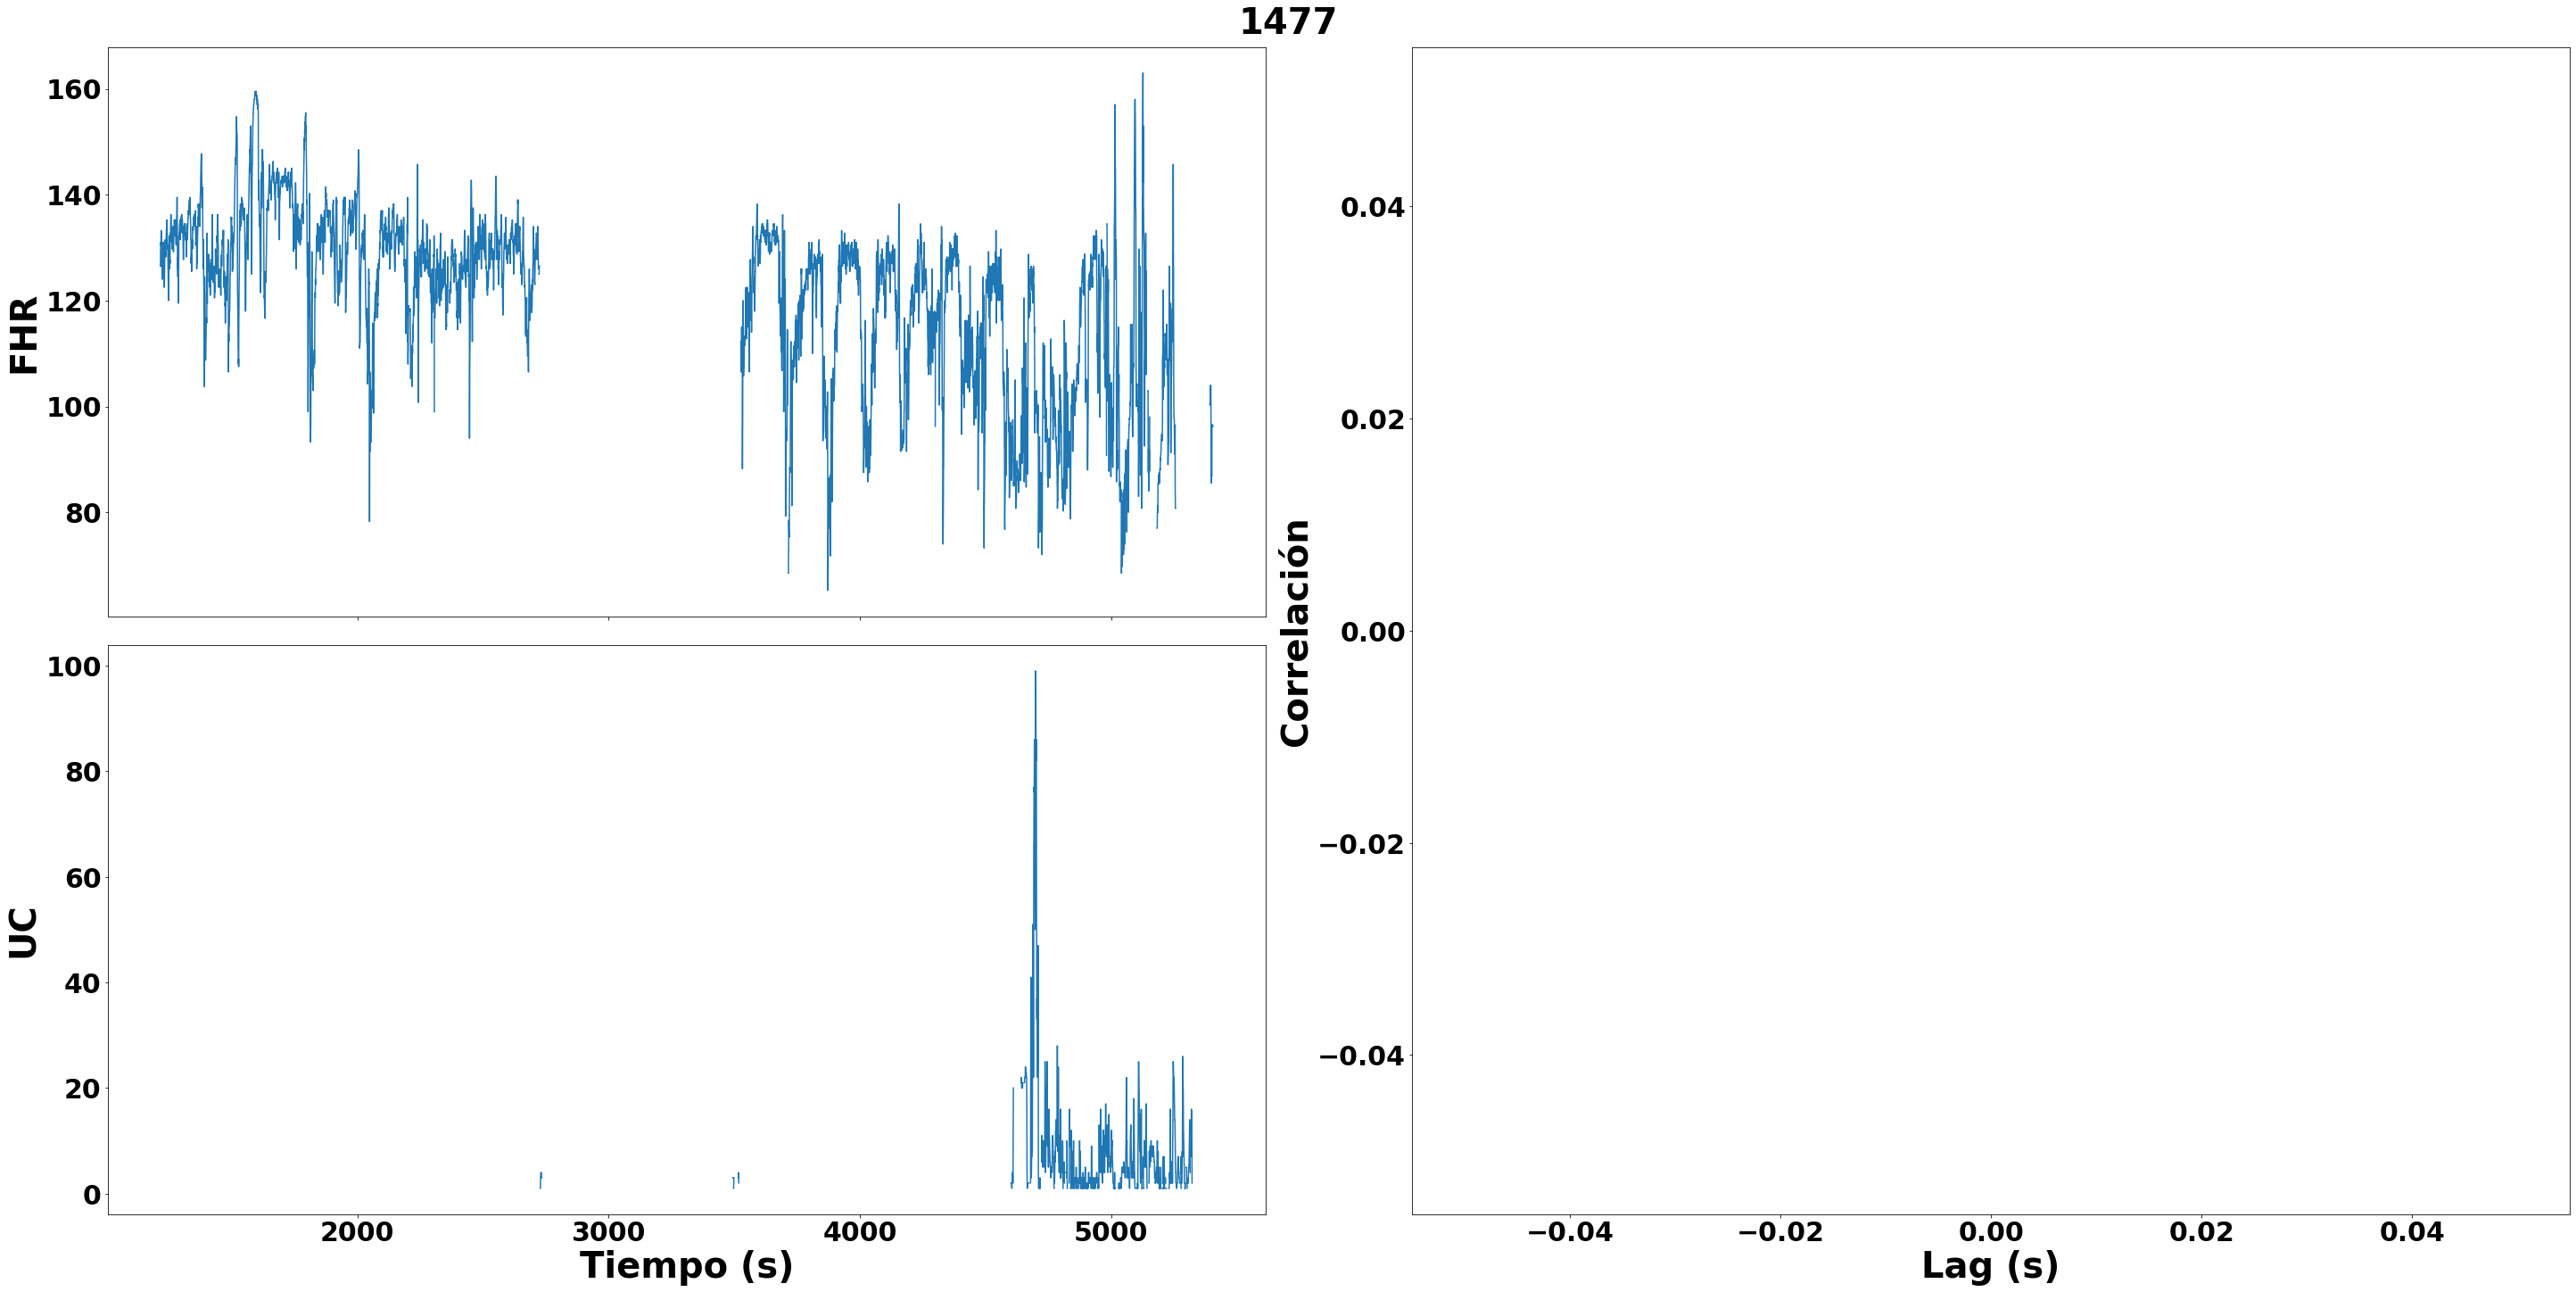

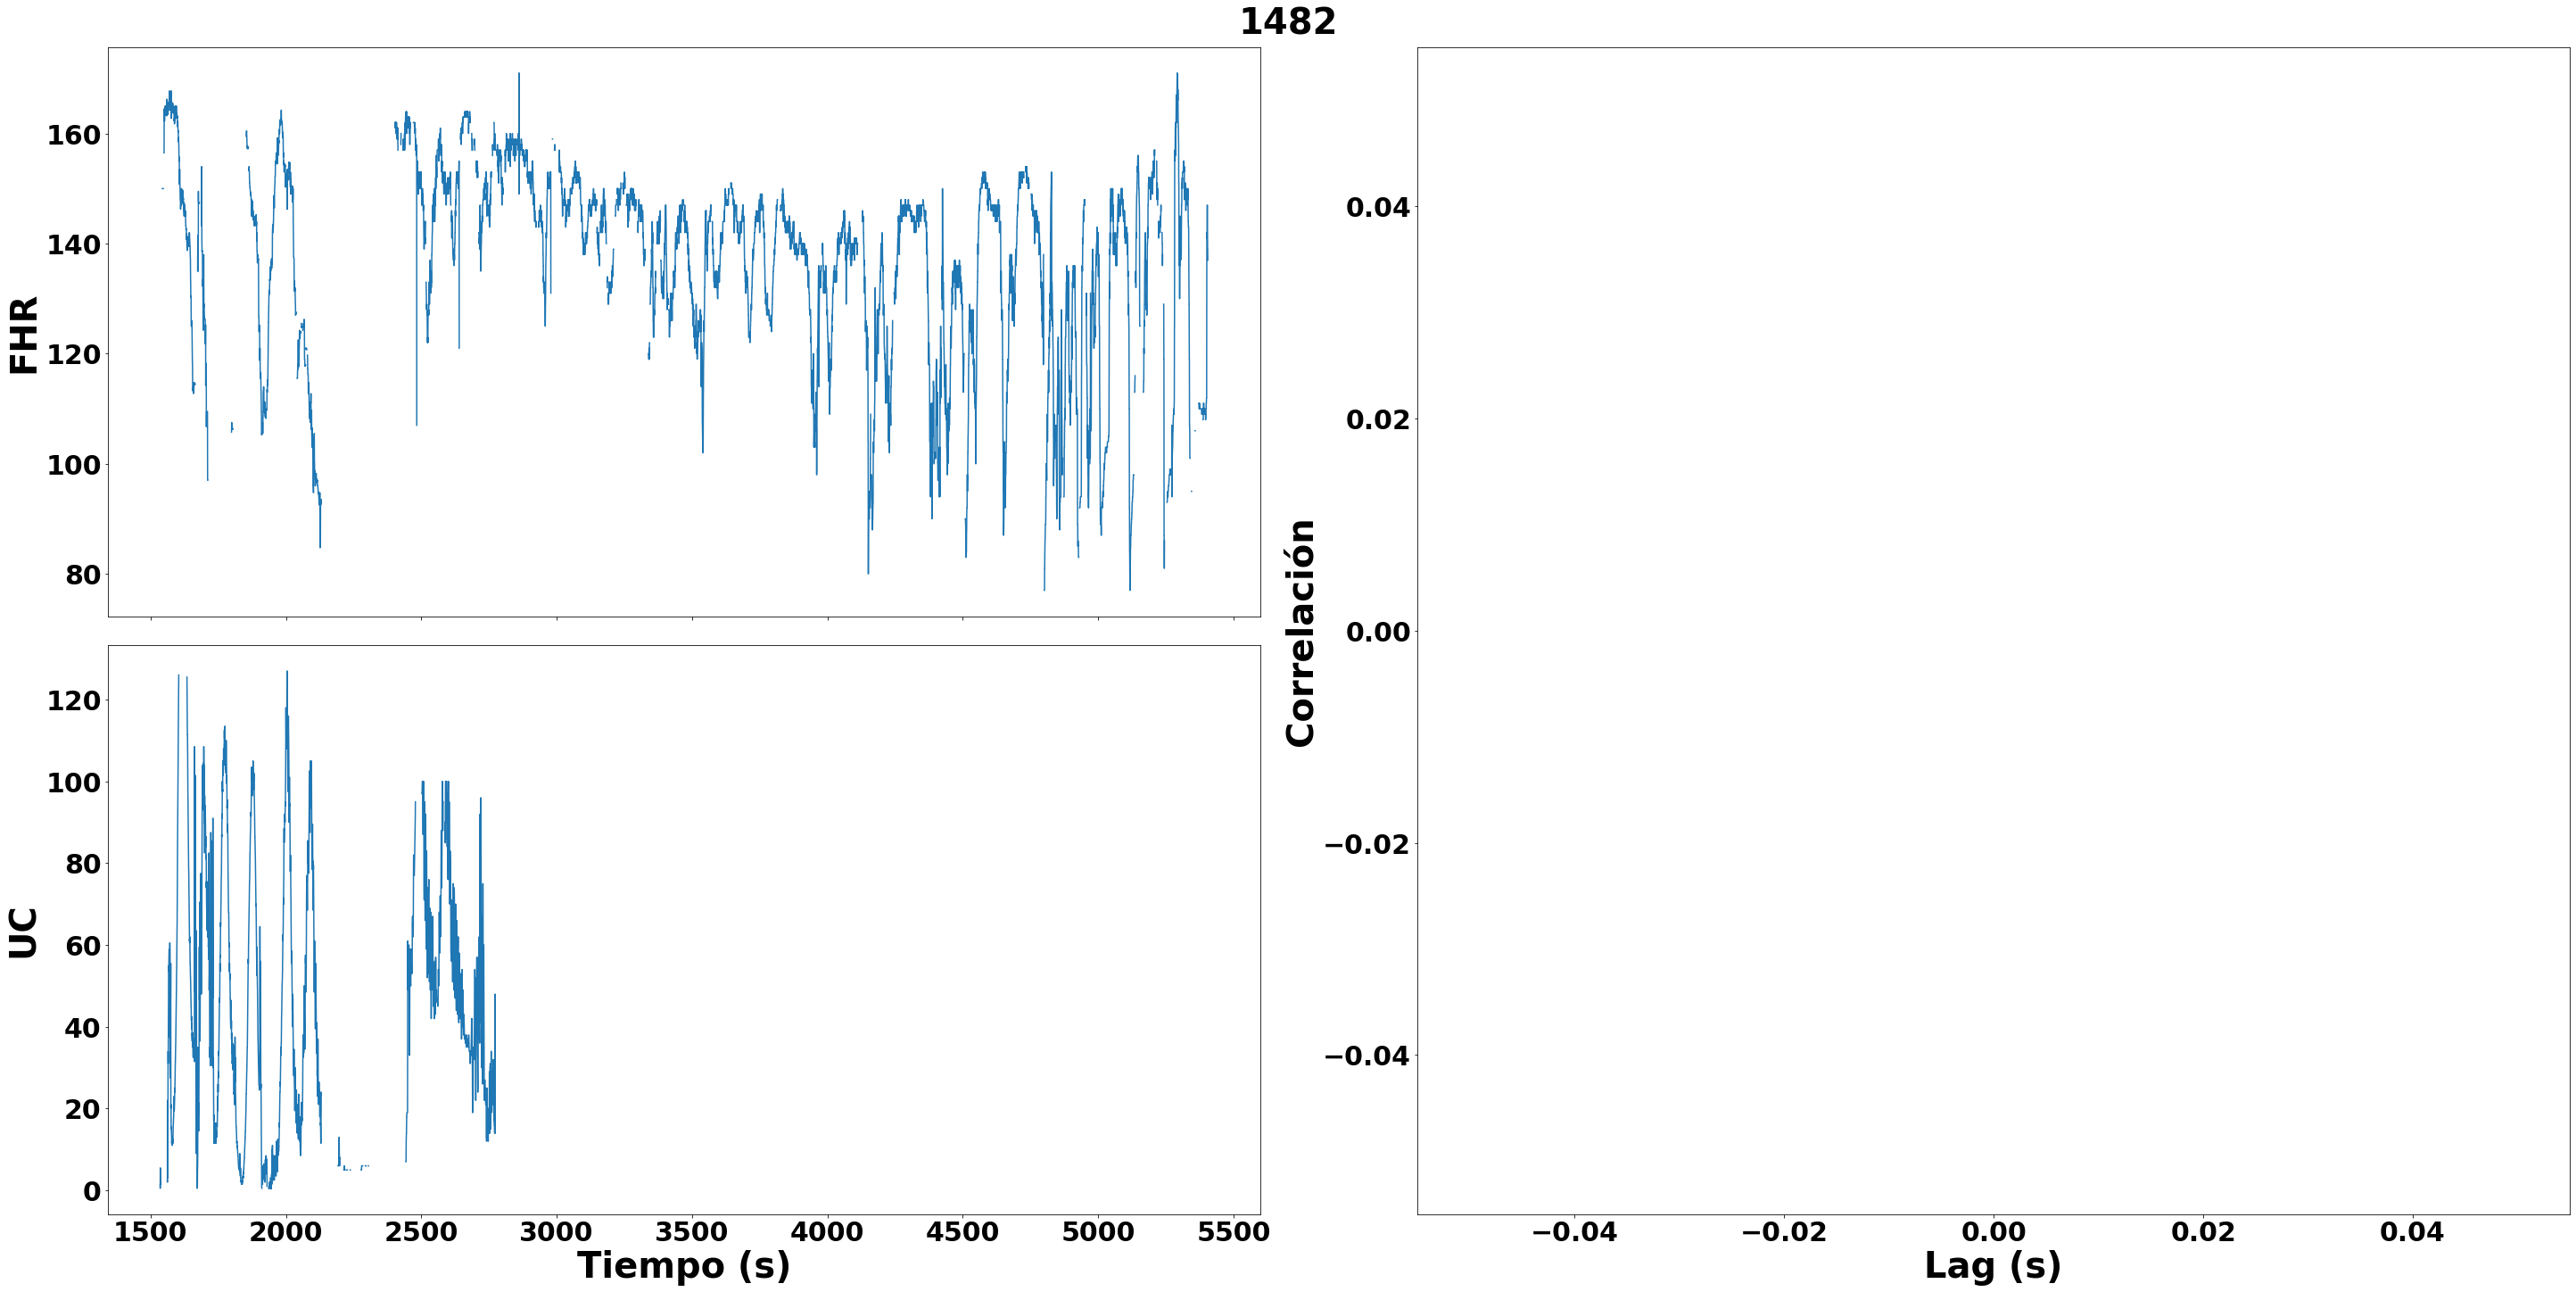

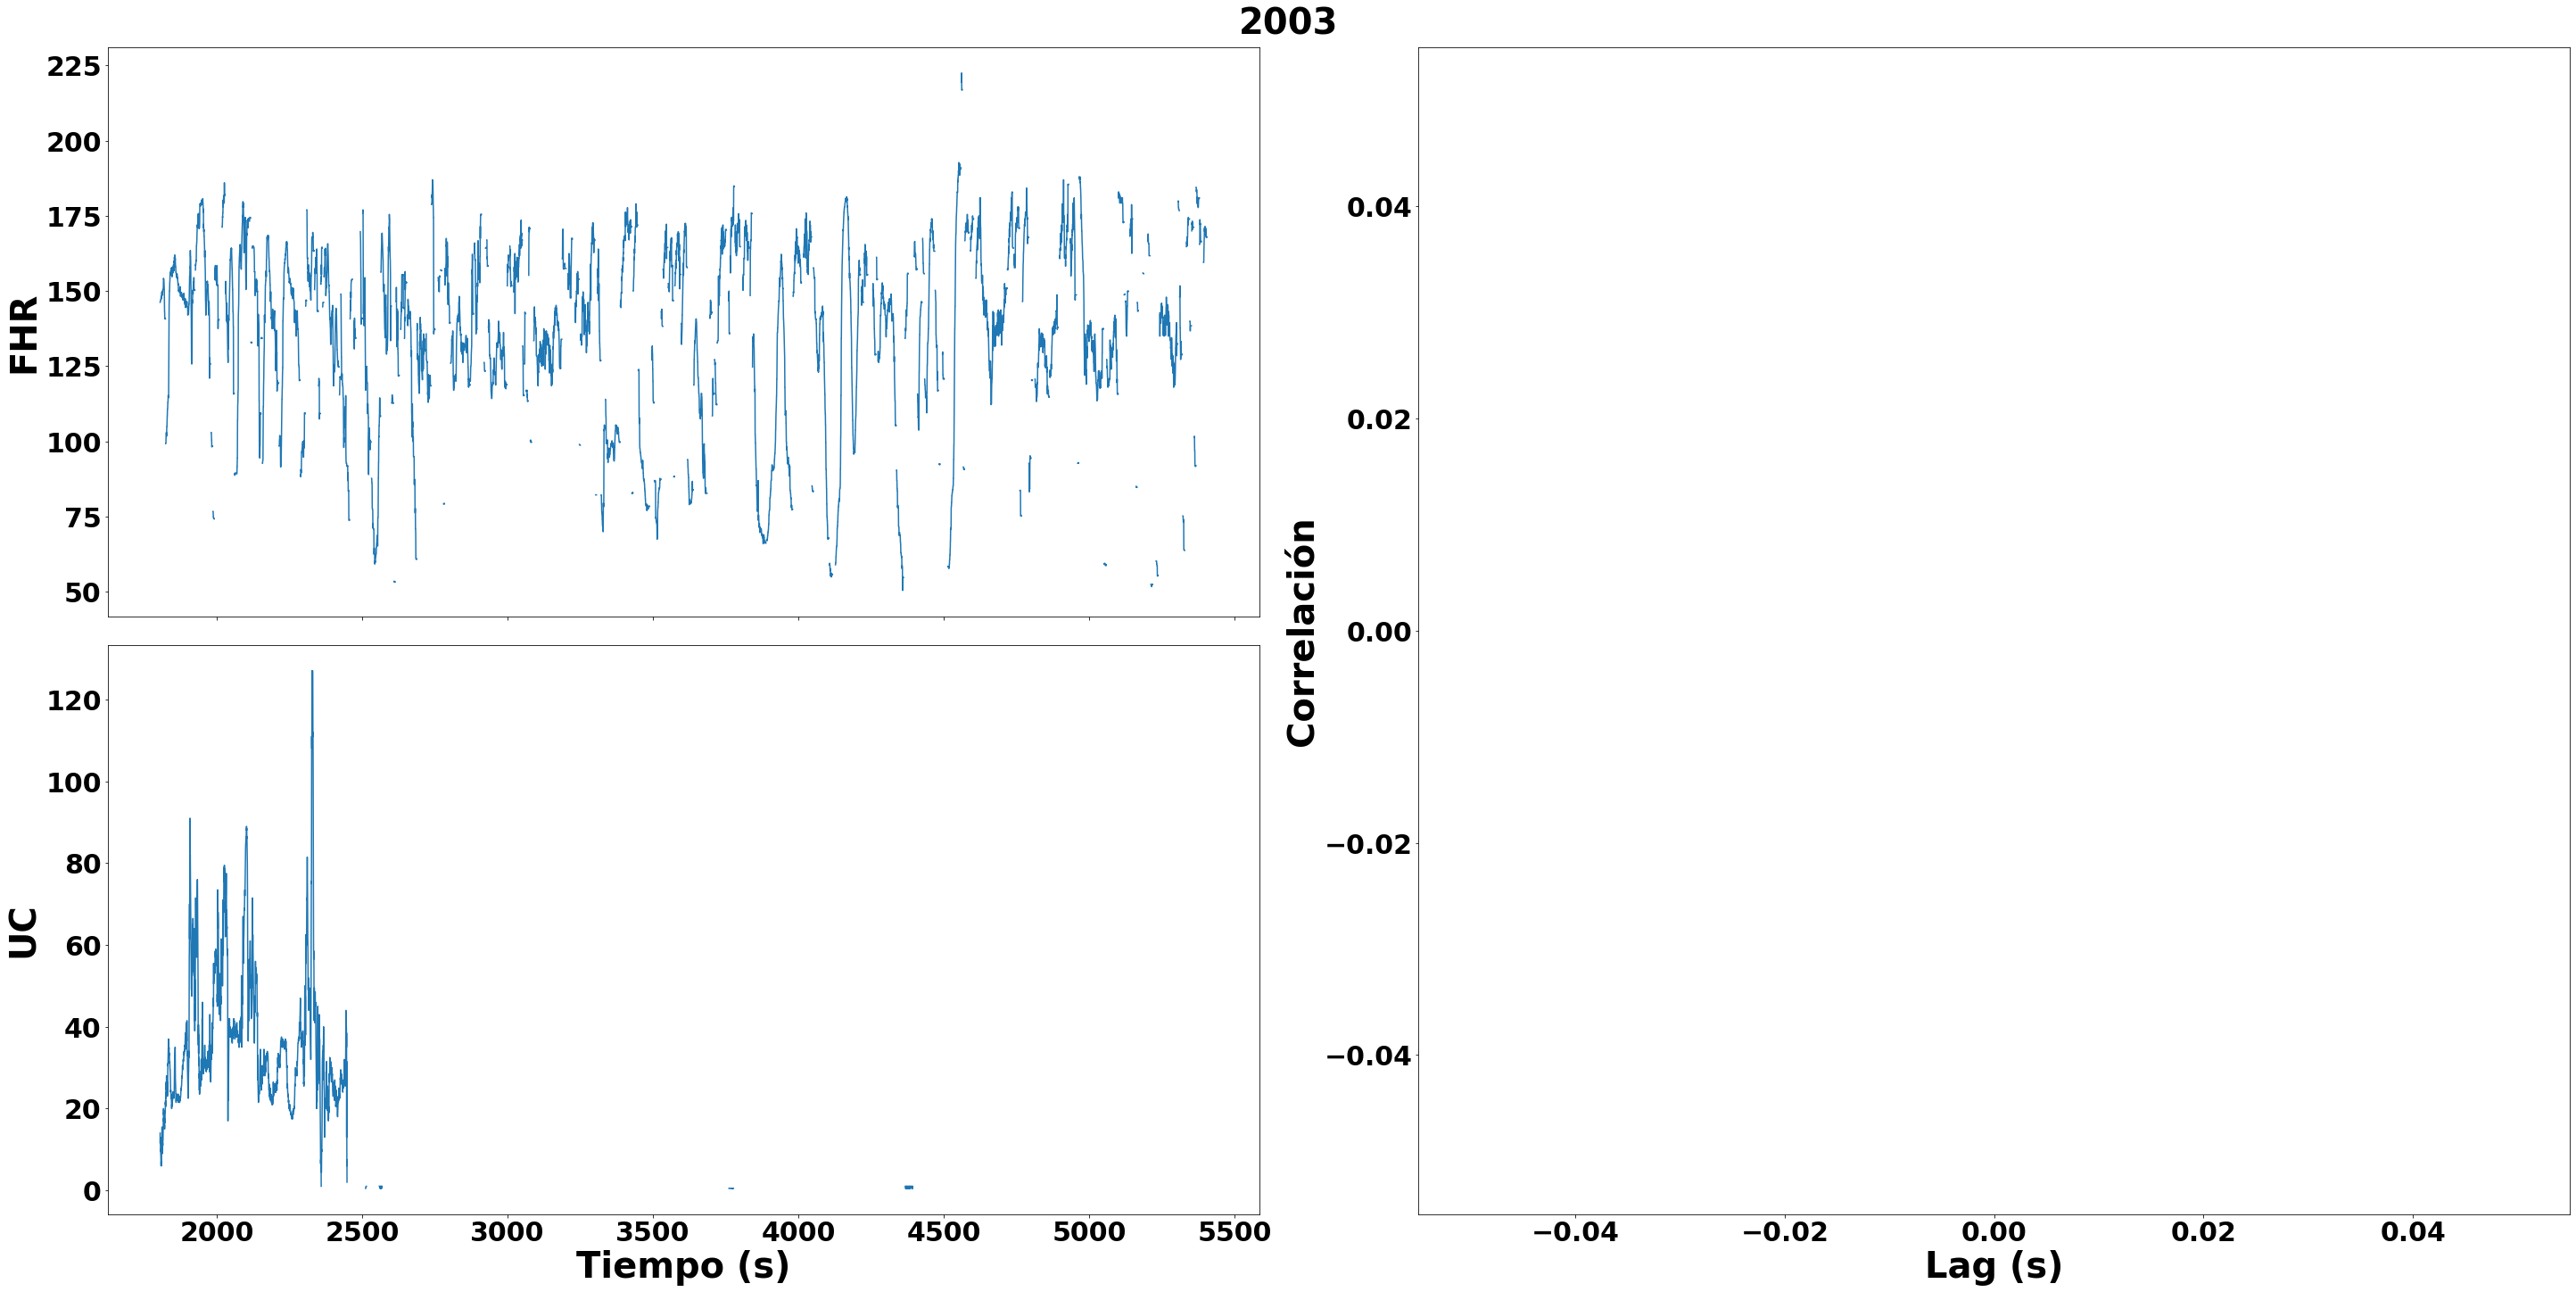

In [76]:
to_plot = [1104, 1119, 1134, 1149, 1155, 1158, 1186, 1188, 1258, 1292, 1322,
           1327, 1451, 1477, 1482, 2003]

for idx in to_plot:
    lags = t_utils.calc_lags(minutes=5)
    fhr_signal = fhr_clean.loc[idx]
    uc_signal = uc_clean.loc[idx]
    y_signal = y_clean.loc[idx]

    cc_transformation = joblib.Parallel(n_jobs=8)(
        joblib.delayed(t_utils.cc)(fhr_signal, uc_signal, lag, 3000) for lag in lags
    )

    cc_signal = pd.Series(cc_transformation, index=lags)

    axd = plt.figure(constrained_layout=True, figsize=(40, 20)).subplot_mosaic(
        """
        AACC
        BBCC
        """
    )

    axd['A'].plot(fhr_signal.index, fhr_signal.values)
    axd['B'].plot(uc_signal.index, uc_signal.values)
    axd['C'].plot(cc_signal.index / 4, cc_signal.values)

    factor_label_font_size = 2
    axd['B'].set_xlabel('Tiempo (s)', fontsize=xlabel_font_size * factor_label_font_size)
    axd['C'].set_xlabel("Lag (s)", fontsize=xlabel_font_size * factor_label_font_size)
    axd['A'].get_shared_x_axes().join(axd['A'], axd['B'])
    axd['A'].set_xticklabels([])

    axd['A'].set_ylabel('FHR', fontsize=xlabel_font_size * factor_label_font_size)
    axd['B'].set_ylabel('UC', fontsize=xlabel_font_size * factor_label_font_size)
    axd['C'].set_ylabel('Correlación', fontsize=xlabel_font_size * factor_label_font_size)

    factor_both_ticks_label_size = 2
    axd['A'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)
    axd['B'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)
    axd['C'].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * factor_both_ticks_label_size)

    fig = plt.gcf()
    fig.suptitle(idx, fontsize=40)

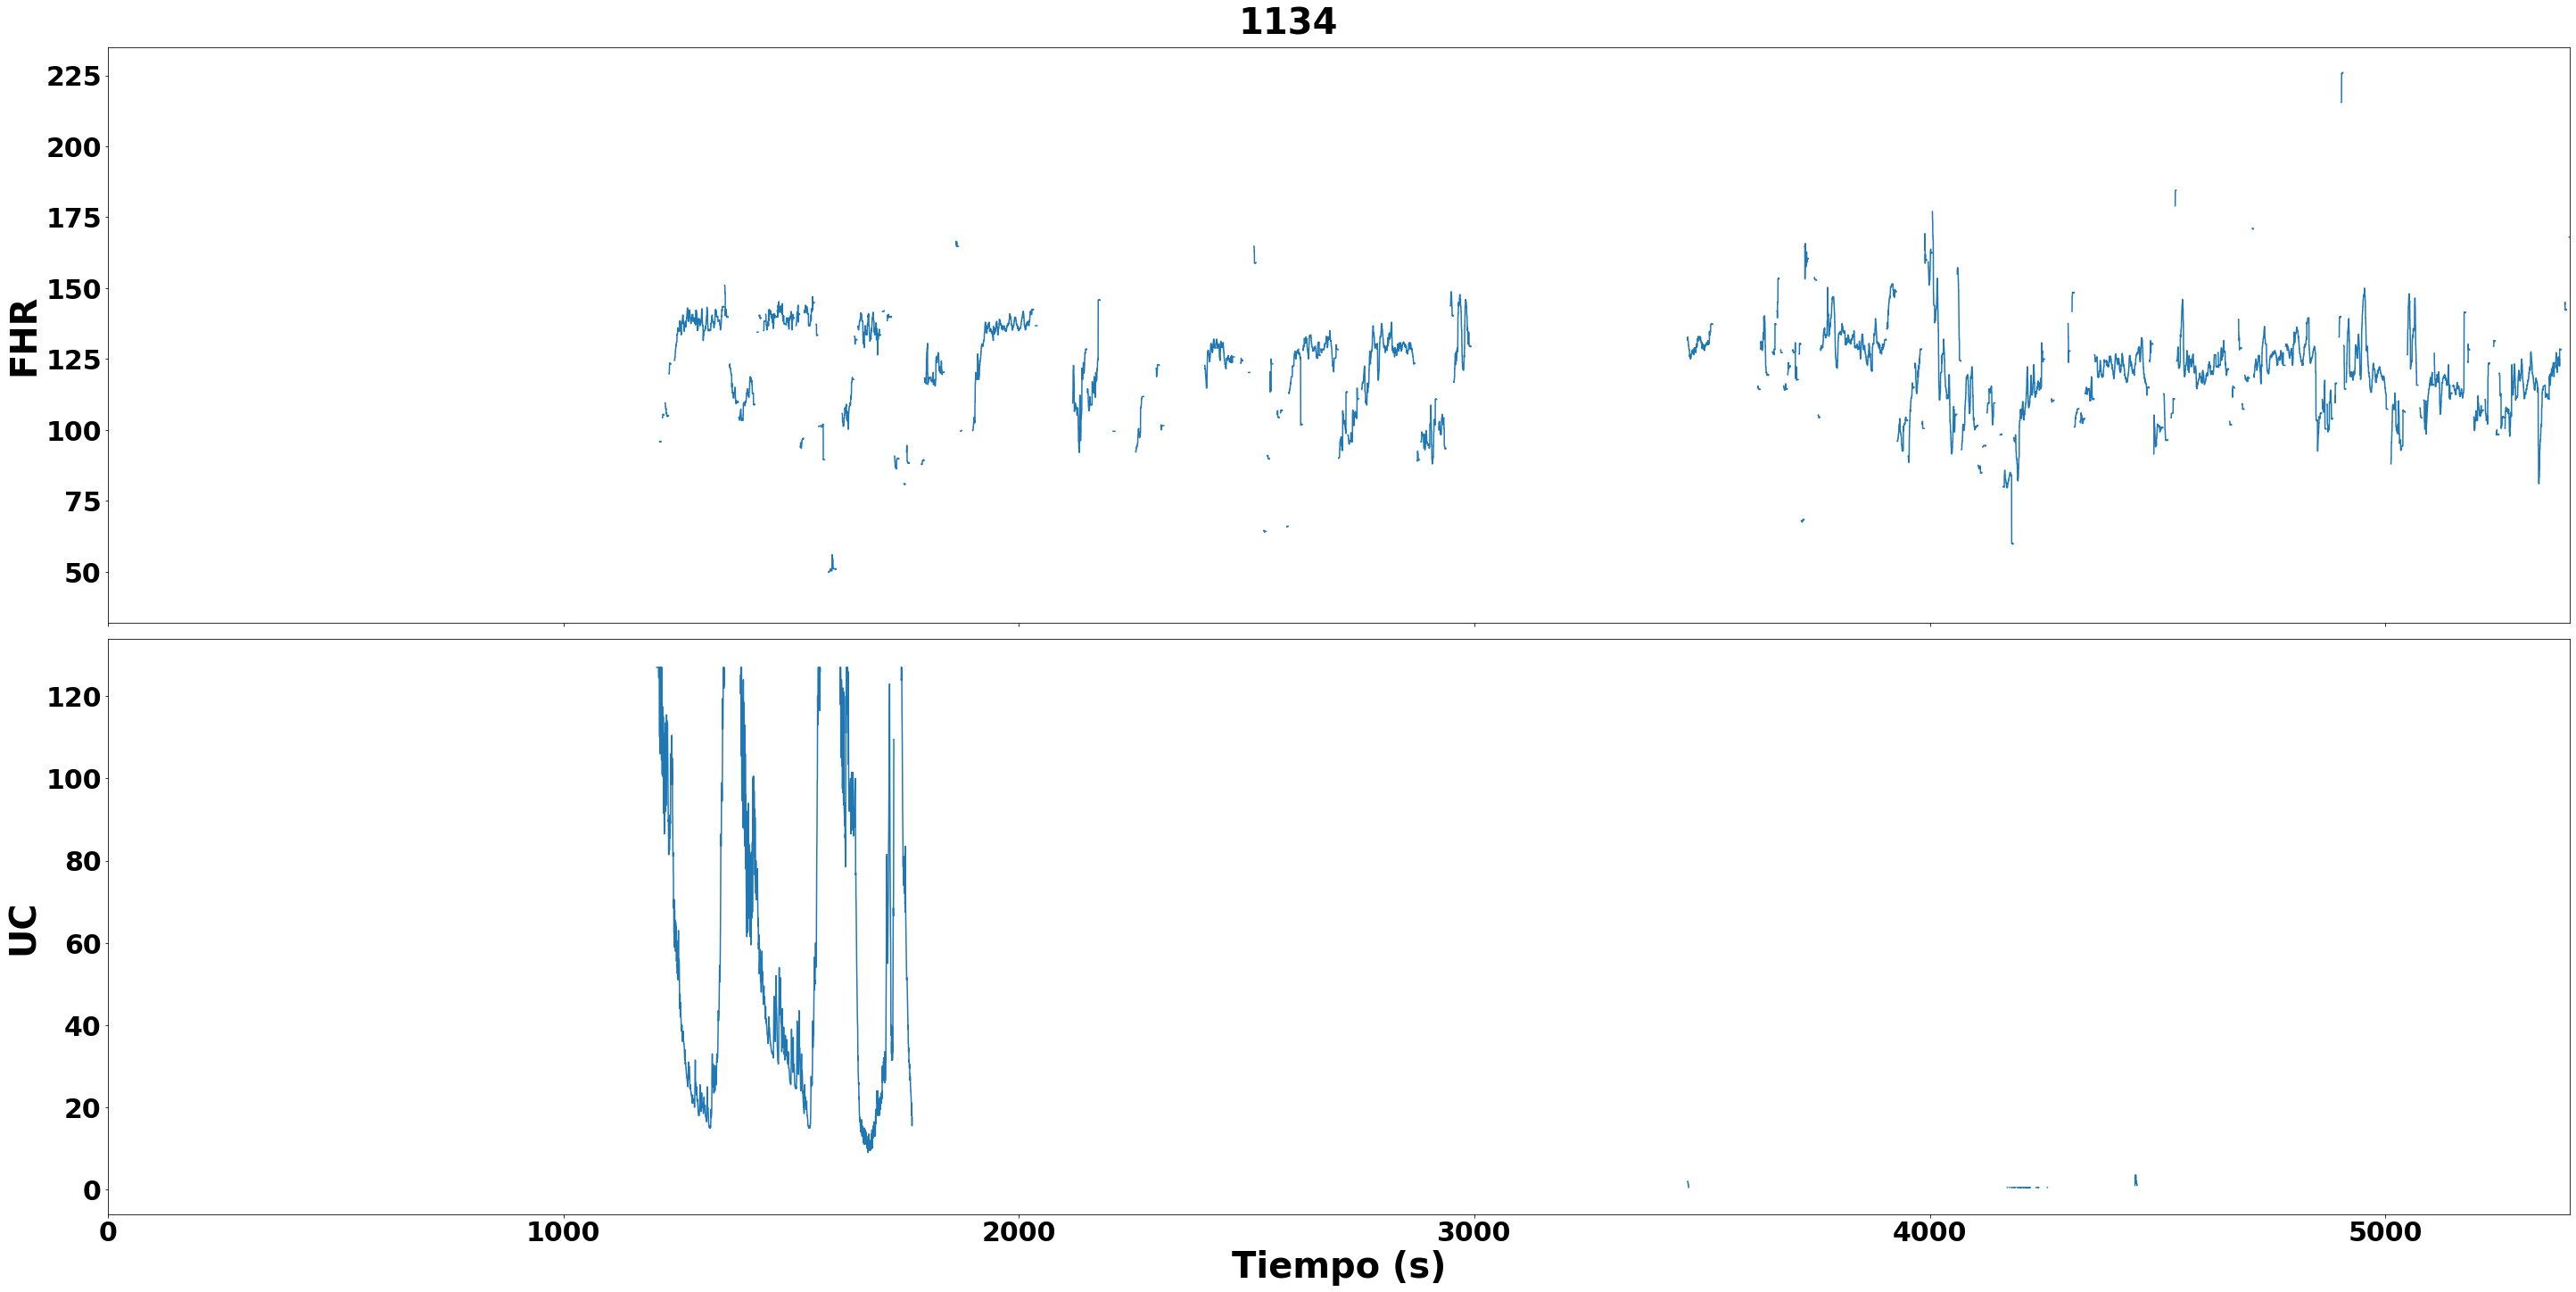

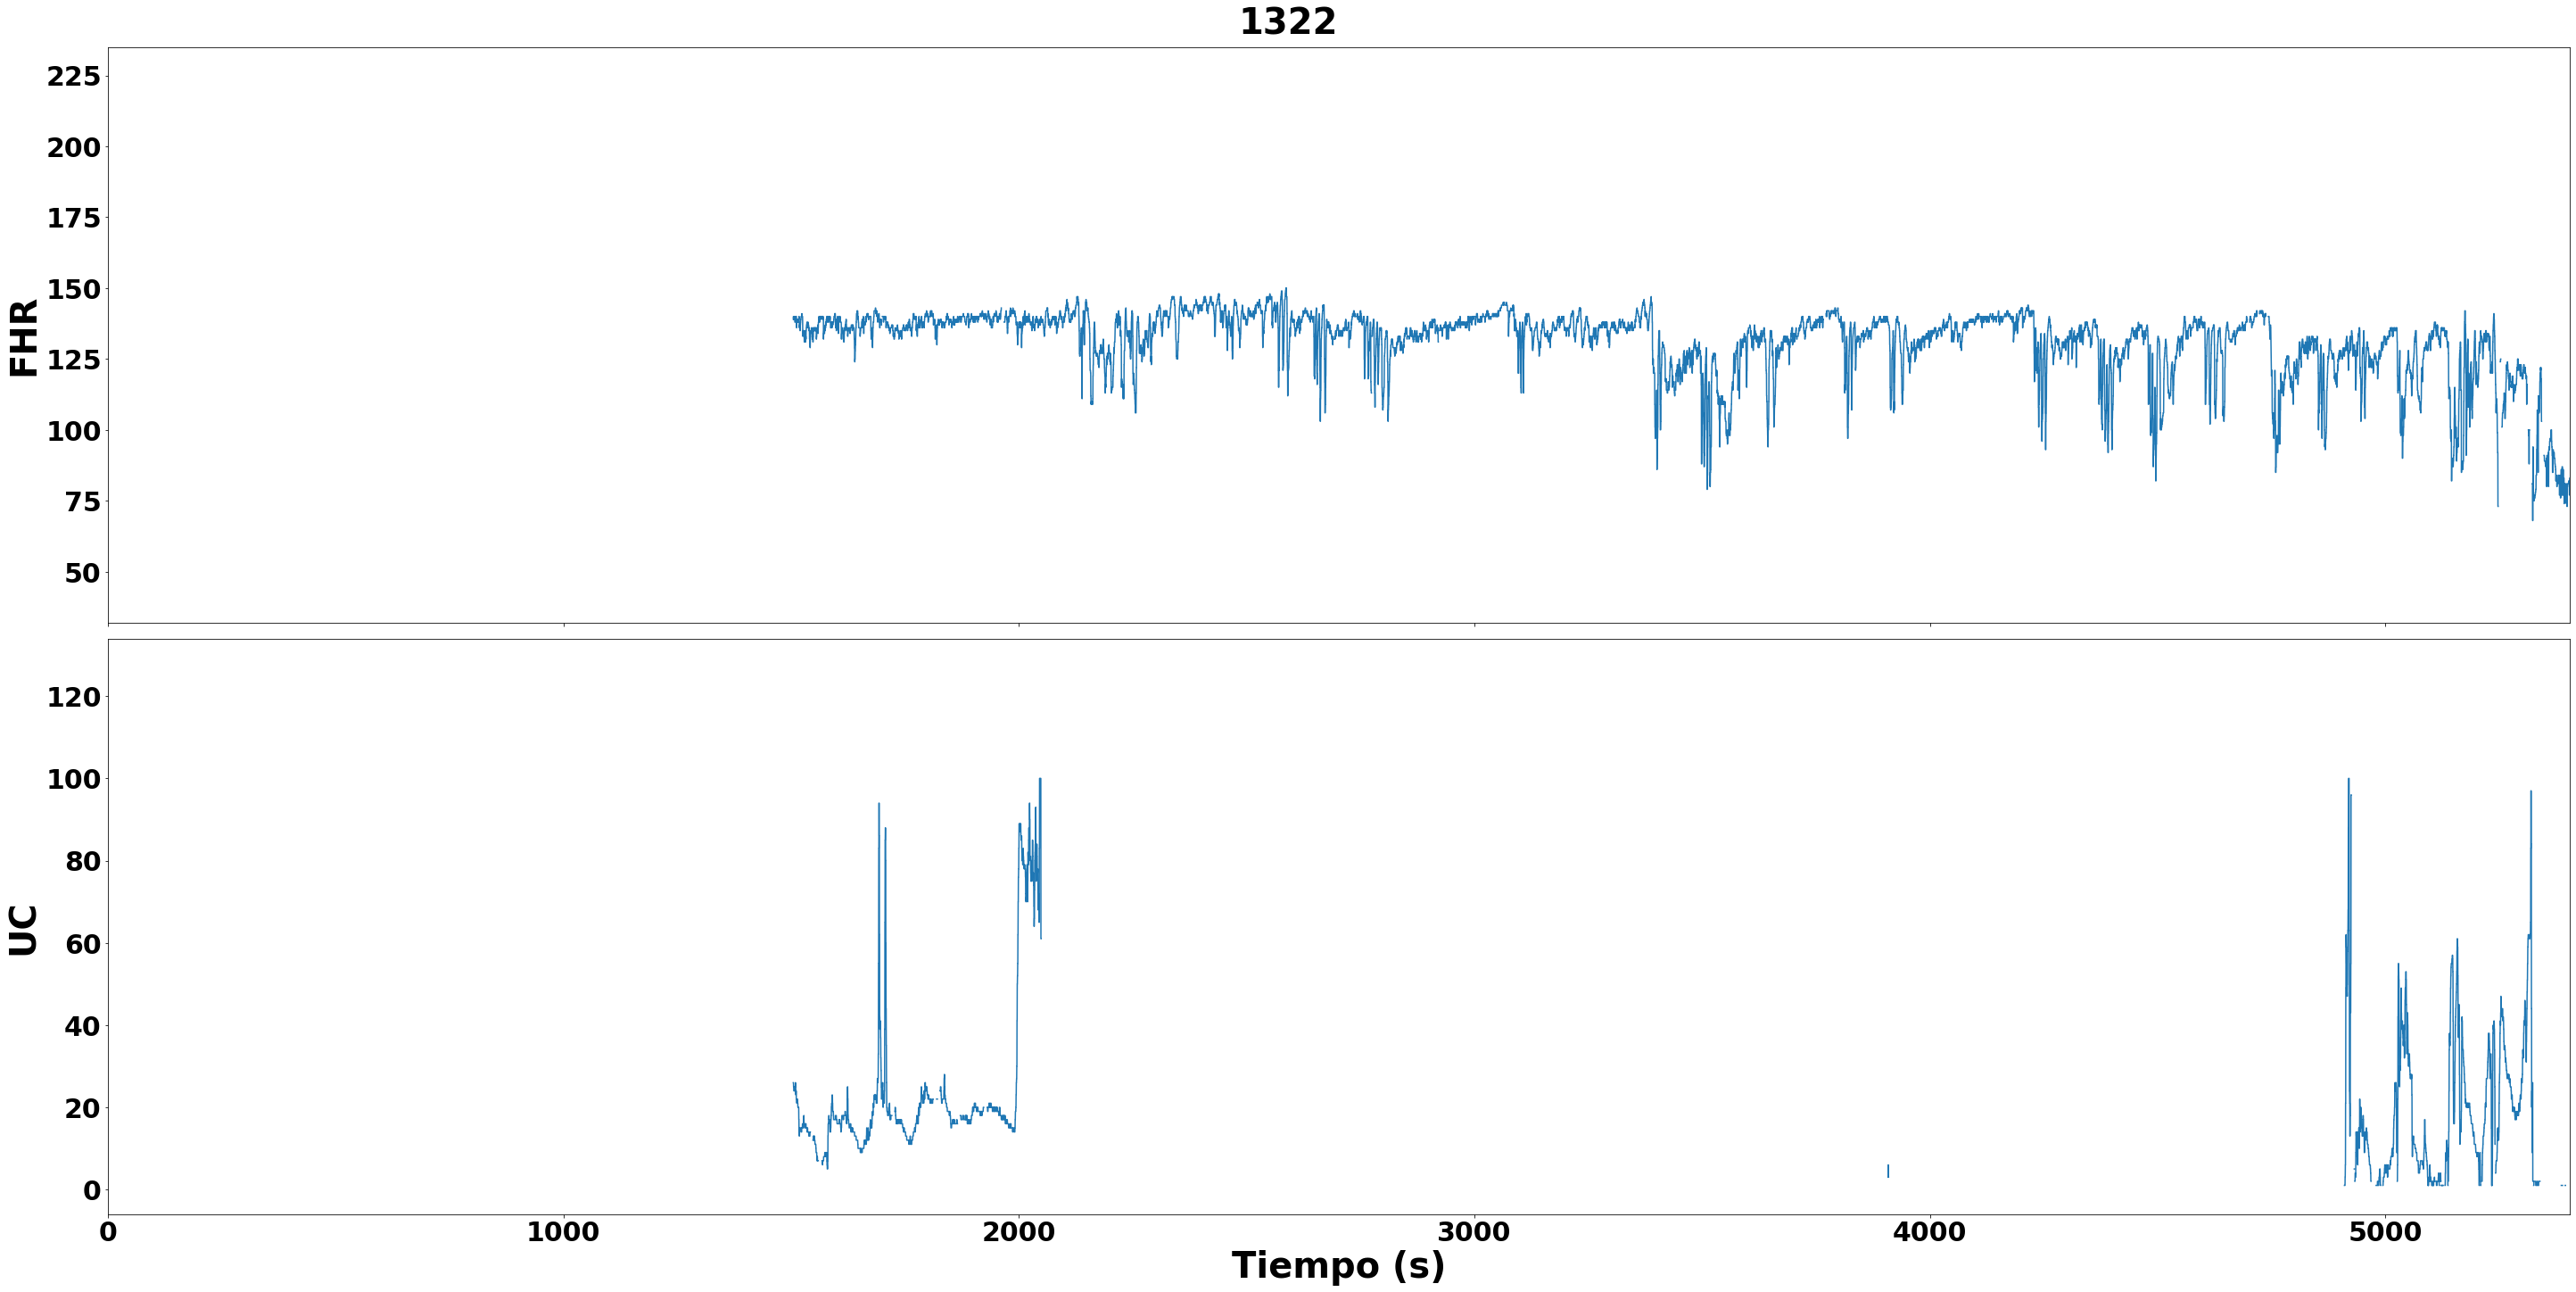

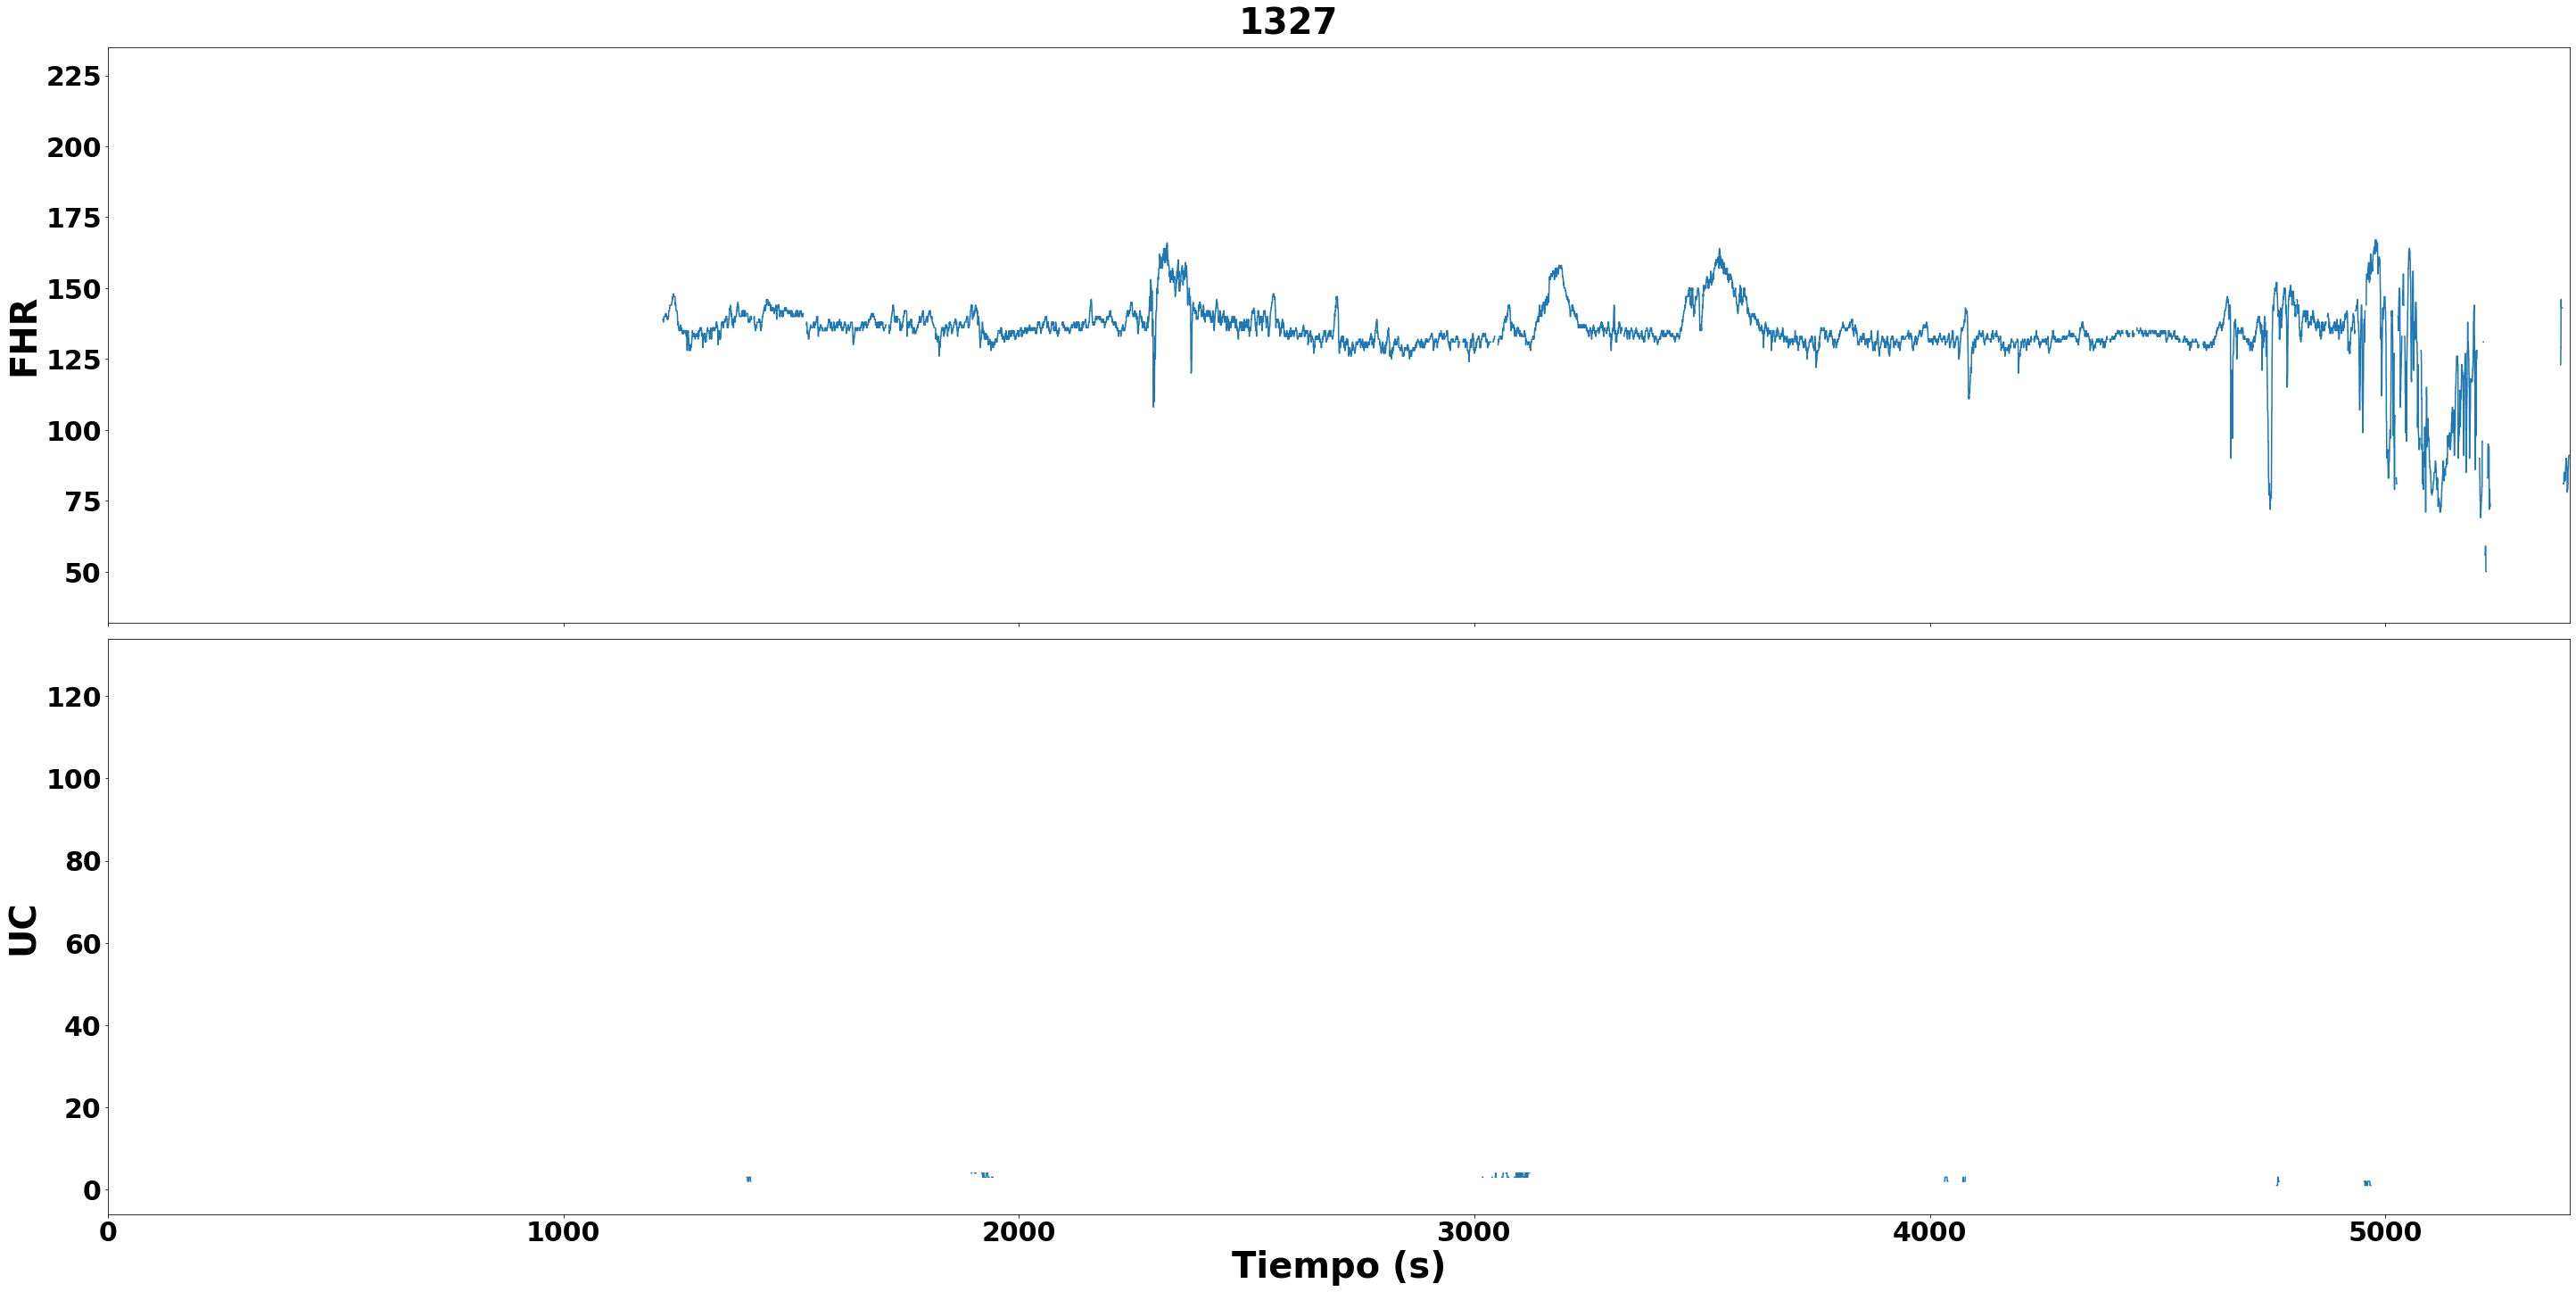

In [130]:
for idx in [1134, 1322, 1327]:
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(40, 20), sharex='all', constrained_layout=True)
    fhr_signal = fhr_clean.loc[idx]
    uc_signal = uc_clean.loc[idx]
    y_signal = y_clean.loc[idx]

    ax[0].plot(fhr_signal.index, fhr_signal.values)
    ax[1].plot(uc_signal.index, uc_signal.values)

    ax[1].set_xlabel('Tiempo (s)', fontsize=xlabel_font_size * 2)
    ax[0].set_ylabel('FHR', fontsize=xlabel_font_size * 2)
    ax[1].set_ylabel('UC', fontsize=xlabel_font_size * 2)

    ax[0].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * 2)
    ax[1].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * 2)

    ax[0].set_ylim((32, 235))
    ax[1].set_xlim((0, 5405))
    ax[1].set_ylim((-6, 134))

    fig.suptitle(f"{idx}", fontsize=40)
    # fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_3000filter_{idx}_example.pdf")

In [95]:
filtered_3030 = [1025, 1026, 1027, 1029, 1030, 1031, 1033, 1034, 1037, 1039, 1041,
                 1042, 1043, 1044, 2039, 1046, 1047, 1049, 1050, 1051, 1052, 1054,
                 1056, 1057, 1058, 1059, 1062, 1063, 1065, 1068, 1069, 1071, 1072,
                 1073, 1074, 1075, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1087,
                 1088, 1089, 1090, 1091, 1093, 1095, 1099, 1100, 1101, 1104, 1105,
                 1107, 1108, 1111, 1114, 1115, 1117, 1119, 1121, 1122, 1125, 1126,
                 1128, 1130, 1131, 1133, 1134, 1137, 1138, 1140, 1145, 1146, 1149,
                 1150, 1151, 1154, 1155, 1156, 1158, 1160, 1164, 1168, 1170, 1171,
                 1173, 1174, 1175, 1178, 1181, 1184, 1186, 1187, 1188, 1194, 1196,
                 1198, 1199, 1200, 1203, 1205, 1206, 1209, 1211, 1212, 1213, 1214,
                 1215, 1216, 1217, 1219, 1220, 1222, 1227, 1228, 1231, 1232, 1233,
                 1239, 1242, 1243, 1244, 1245, 1246, 1247, 1250, 1251, 1252, 1253,
                 1254, 1255, 1257, 1258, 1259, 1260, 1261, 1262, 1265, 1266, 1267,
                 1268, 1271, 1272, 1274, 1275, 1276, 1277, 1279, 1283, 1284, 1289,
                 1290, 1291, 1292, 1296, 1297, 1298, 1300, 1302, 1304, 1306, 1307,
                 1310, 1311, 1312, 1313, 1316, 1318, 1321, 1322, 1323, 1324, 1325,
                 1327, 1329, 1330, 1333, 1335, 1336, 1338, 1347, 1348, 1351, 1353,
                 1354, 1355, 1357, 1358, 1359, 1360, 1361, 1363, 1364, 1365, 1369,
                 1371, 1374, 1375, 1376, 1377, 1383, 1384, 1386, 1388, 1390, 1391,
                 1392, 1393, 1394, 1397, 1398, 1404, 1406, 1407, 1409, 1410, 1411,
                 1414, 1417, 1419, 1422, 1424, 1425, 1431, 1433, 1434, 1437, 1441,
                 1444, 1448, 1449, 1451, 1455, 1456, 1458, 1462, 1463, 1465, 1469,
                 1470, 1474, 1475, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1488,
                 1489, 1491, 1492, 1493, 1494, 2003, 2004, 2008, 2010, 2011, 2012,
                 1501, 2013, 1503, 1505, 2019, 2020, 2021, 2022, 2024, 1001, 1002,
                 1003, 1004, 1005, 1006, 1007, 2026, 1009, 1010, 2028, 2033, 1013,
                 1014, 1015, 1016, 1017, 2035, 1019, 2036, 1021, 2046]

In [110]:
filtered = np.array(list(set(filtered_3030) - set(to_plot)))

array([1025, 1026, 1027, 1029, 1030, 1031, 1033, 1034, 1037, 1039, 1041,
       1042, 1043, 1044, 1021, 1046, 1047, 1049, 1050, 1051, 1052, 1054,
       1056, 1057, 1058, 1059, 1062, 1063, 1065, 1068, 1069, 1071, 1072,
       1073, 1074, 1075, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1087,
       1088, 1089, 1090, 1091, 1093, 1095, 1099, 1100, 1101, 1105, 1107,
       1108, 1111, 1114, 1115, 1117, 1121, 1122, 1125, 1126, 1128, 1130,
       1131, 1133, 1137, 1138, 1140, 1145, 1146, 1150, 1151, 1154, 1156,
       1160, 1164, 1168, 1170, 1171, 1173, 1174, 1175, 1178, 1181, 1184,
       1187, 1194, 1196, 1198, 1199, 1200, 1203, 1205, 1206, 1209, 1211,
       1212, 1213, 1214, 1215, 1216, 1217, 1219, 1220, 1222, 1227, 1228,
       1231, 1232, 1233, 1239, 1242, 1243, 1244, 1245, 1246, 1247, 1250,
       1251, 1252, 1253, 1254, 1255, 1257, 1259, 1260, 1261, 1262, 1265,
       1266, 1267, 1268, 1271, 1272, 1274, 1275, 1276, 1277, 1279, 1283,
       1284, 1289, 1290, 1291, 1296, 1297, 1298, 13

In [149]:
cut_fhr = fhr_clean.copy().loc[filtered].iloc[:, -30 * 60 * 4:]
fhr_nans_percent = (cut_fhr.isna().sum(axis=1) / cut_fhr.shape[1] * 100)
fhr_now_dismissed = fhr_nans_percent.index[fhr_nans_percent > 30].to_numpy()

cut_uc = uc_clean.copy().loc[filtered].iloc[:, -30 * 60 * 4:]
uc_nans_percent = (cut_uc.isna().sum(axis=1) / cut_fhr.shape[1] * 100)
uc_now_dismissed = uc_nans_percent.index[uc_nans_percent > 30].to_numpy()

In [116]:
filtered.shape,fhr_now_dismissed.shape, uc_now_dismissed.shape

((279,), (111,), (256,))

In [150]:
both = list(set(fhr_now_dismissed).intersection(set(uc_now_dismissed)))
fhr_nans_percent_both = fhr_nans_percent.copy().loc[both]
uc_nans_percent_both = uc_nans_percent.copy().loc[both]

fhr_nans_percent_both[uc_nans_percent_both > uc_nans_percent_both.median()].sort_values()

1268    31.138889
1128    31.250000
1318    31.638889
1199    34.152778
1125    34.305556
1310    34.777778
1312    35.875000
1411    36.194444
1289    36.611111
1244    37.833333
1217    39.458333
1311    39.638889
1017    40.819444
2013    42.027778
1231    42.652778
1184    44.166667
1227    44.611111
1463    47.500000
2028    47.930556
1354    48.666667
1087    48.666667
1365    49.763889
1321    49.847222
1140    50.486111
1187    52.833333
1054    56.708333
1164    57.416667
1073    57.944444
1009    60.319444
1291    60.750000
1044    61.375000
1072    62.027778
1222    63.805556
1383    65.555556
1171    66.861111
1173    67.527778
1266    67.527778
1137    71.055556
1277    71.638889
1425    73.444444
1357    76.958333
1448    77.861111
1417    84.569444
1058    92.361111
dtype: float64

In [159]:
fhr_nans_percent[fhr_nans_percent == fhr_nans_percent[fhr_nans_percent > 30].median()]

1214    40.25
dtype: float64

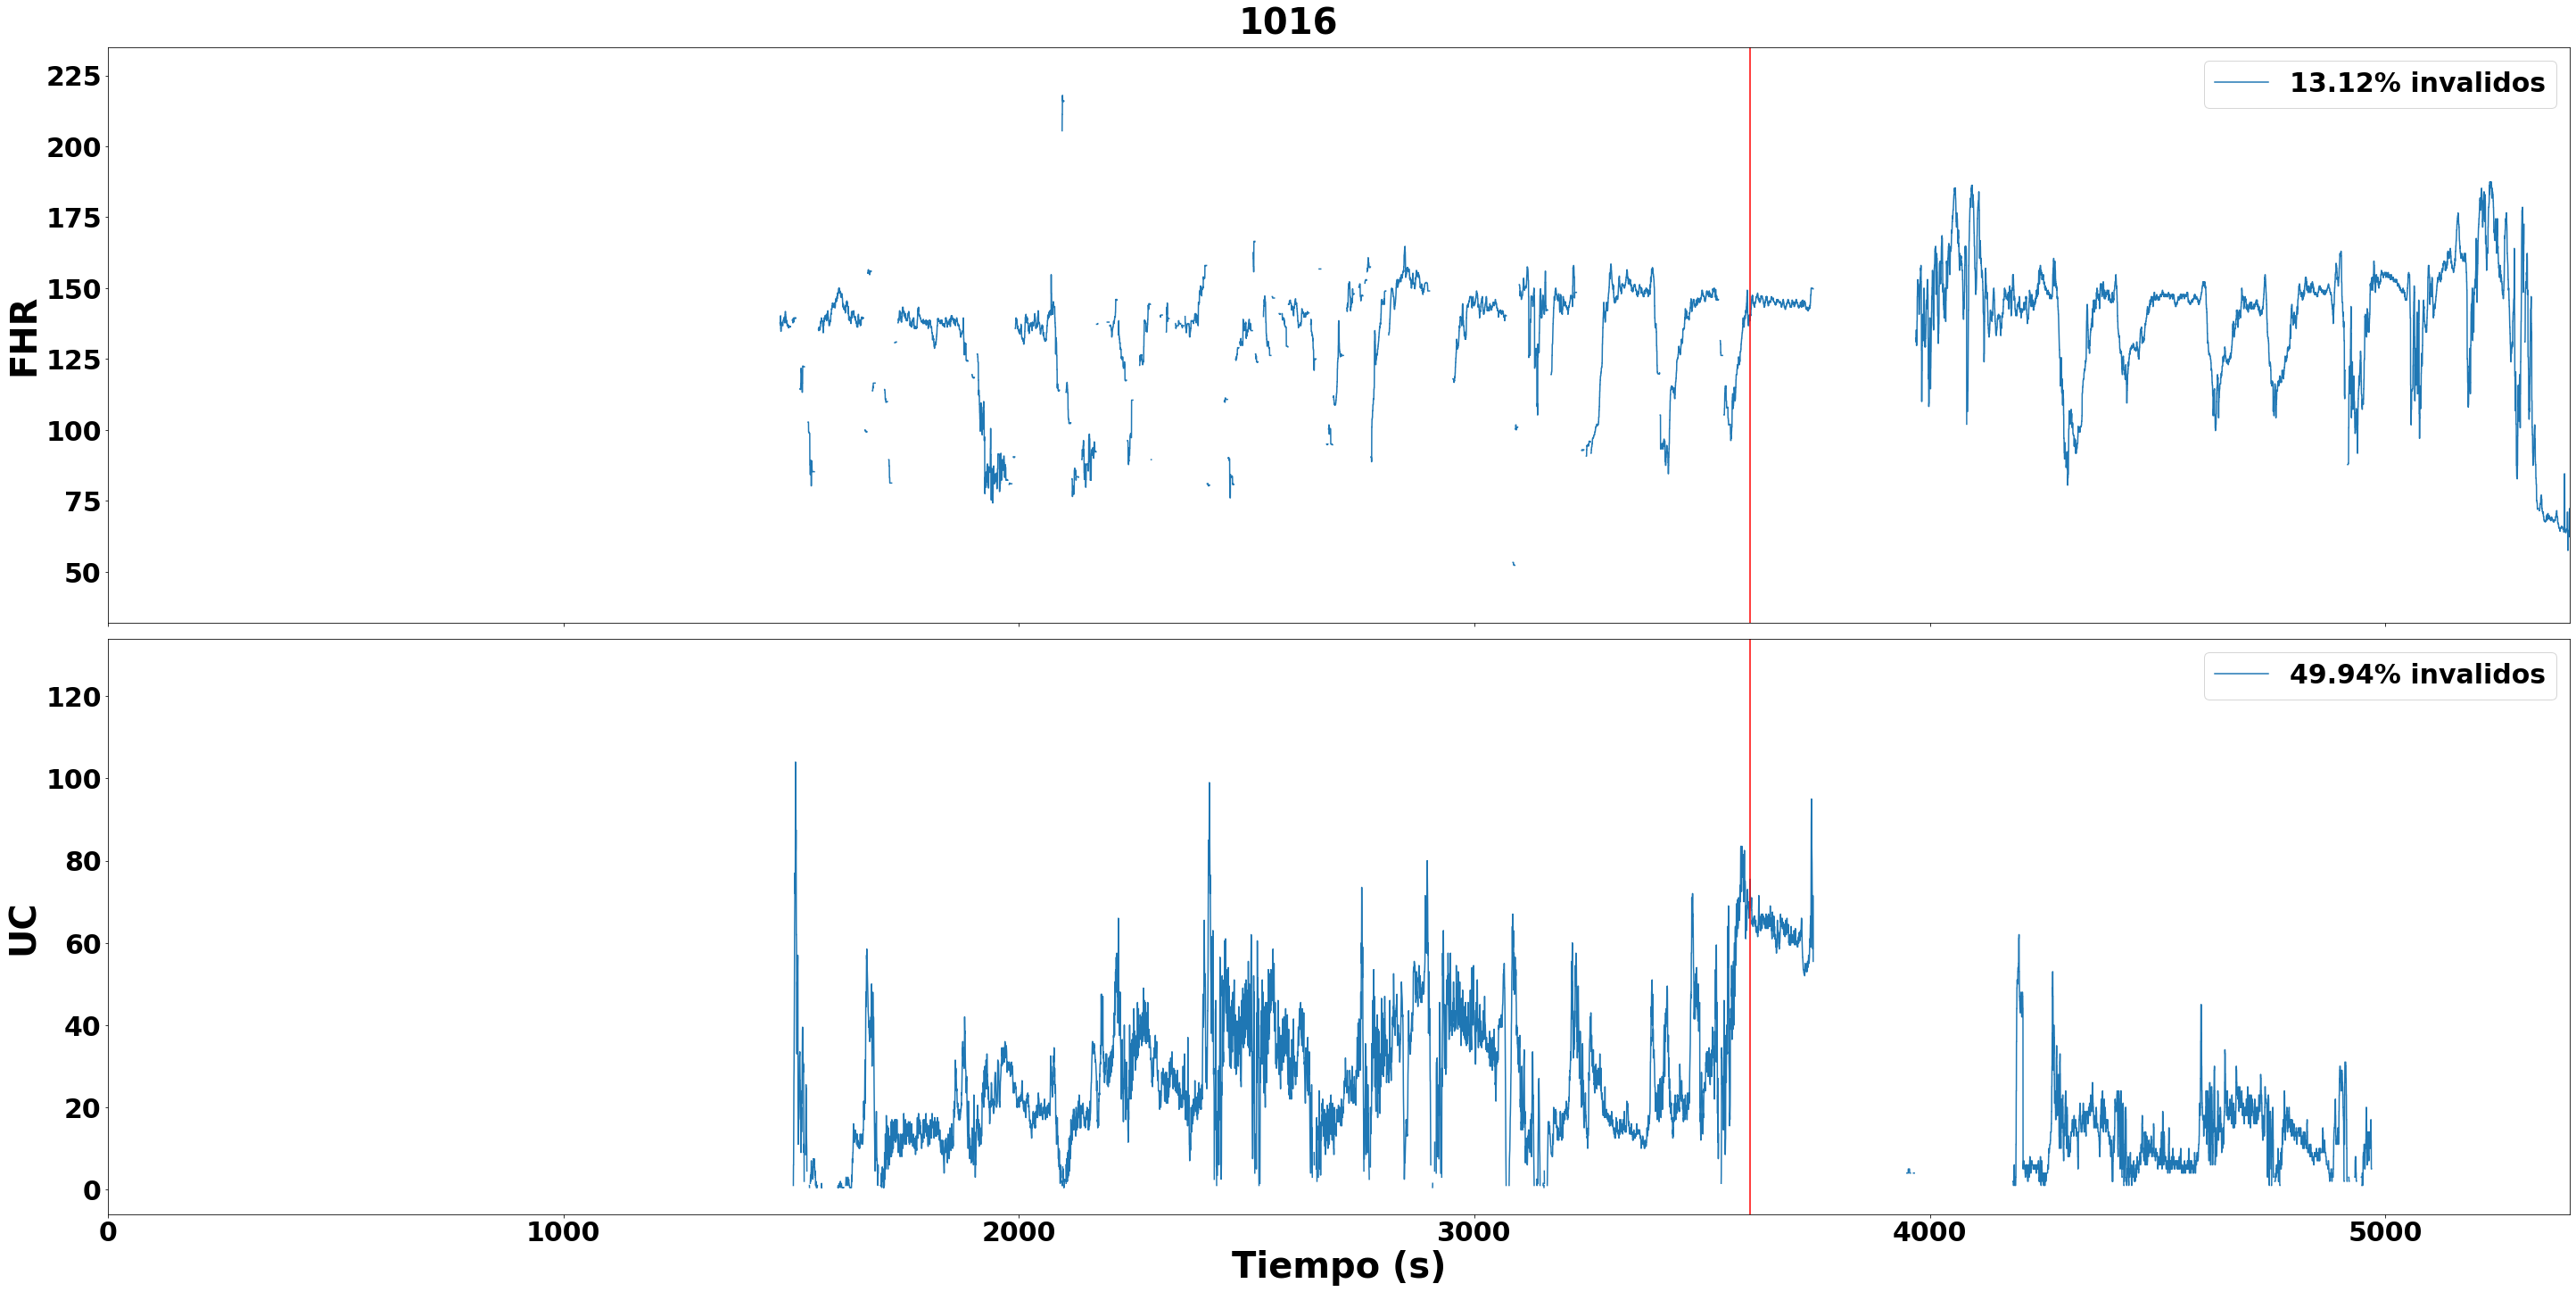

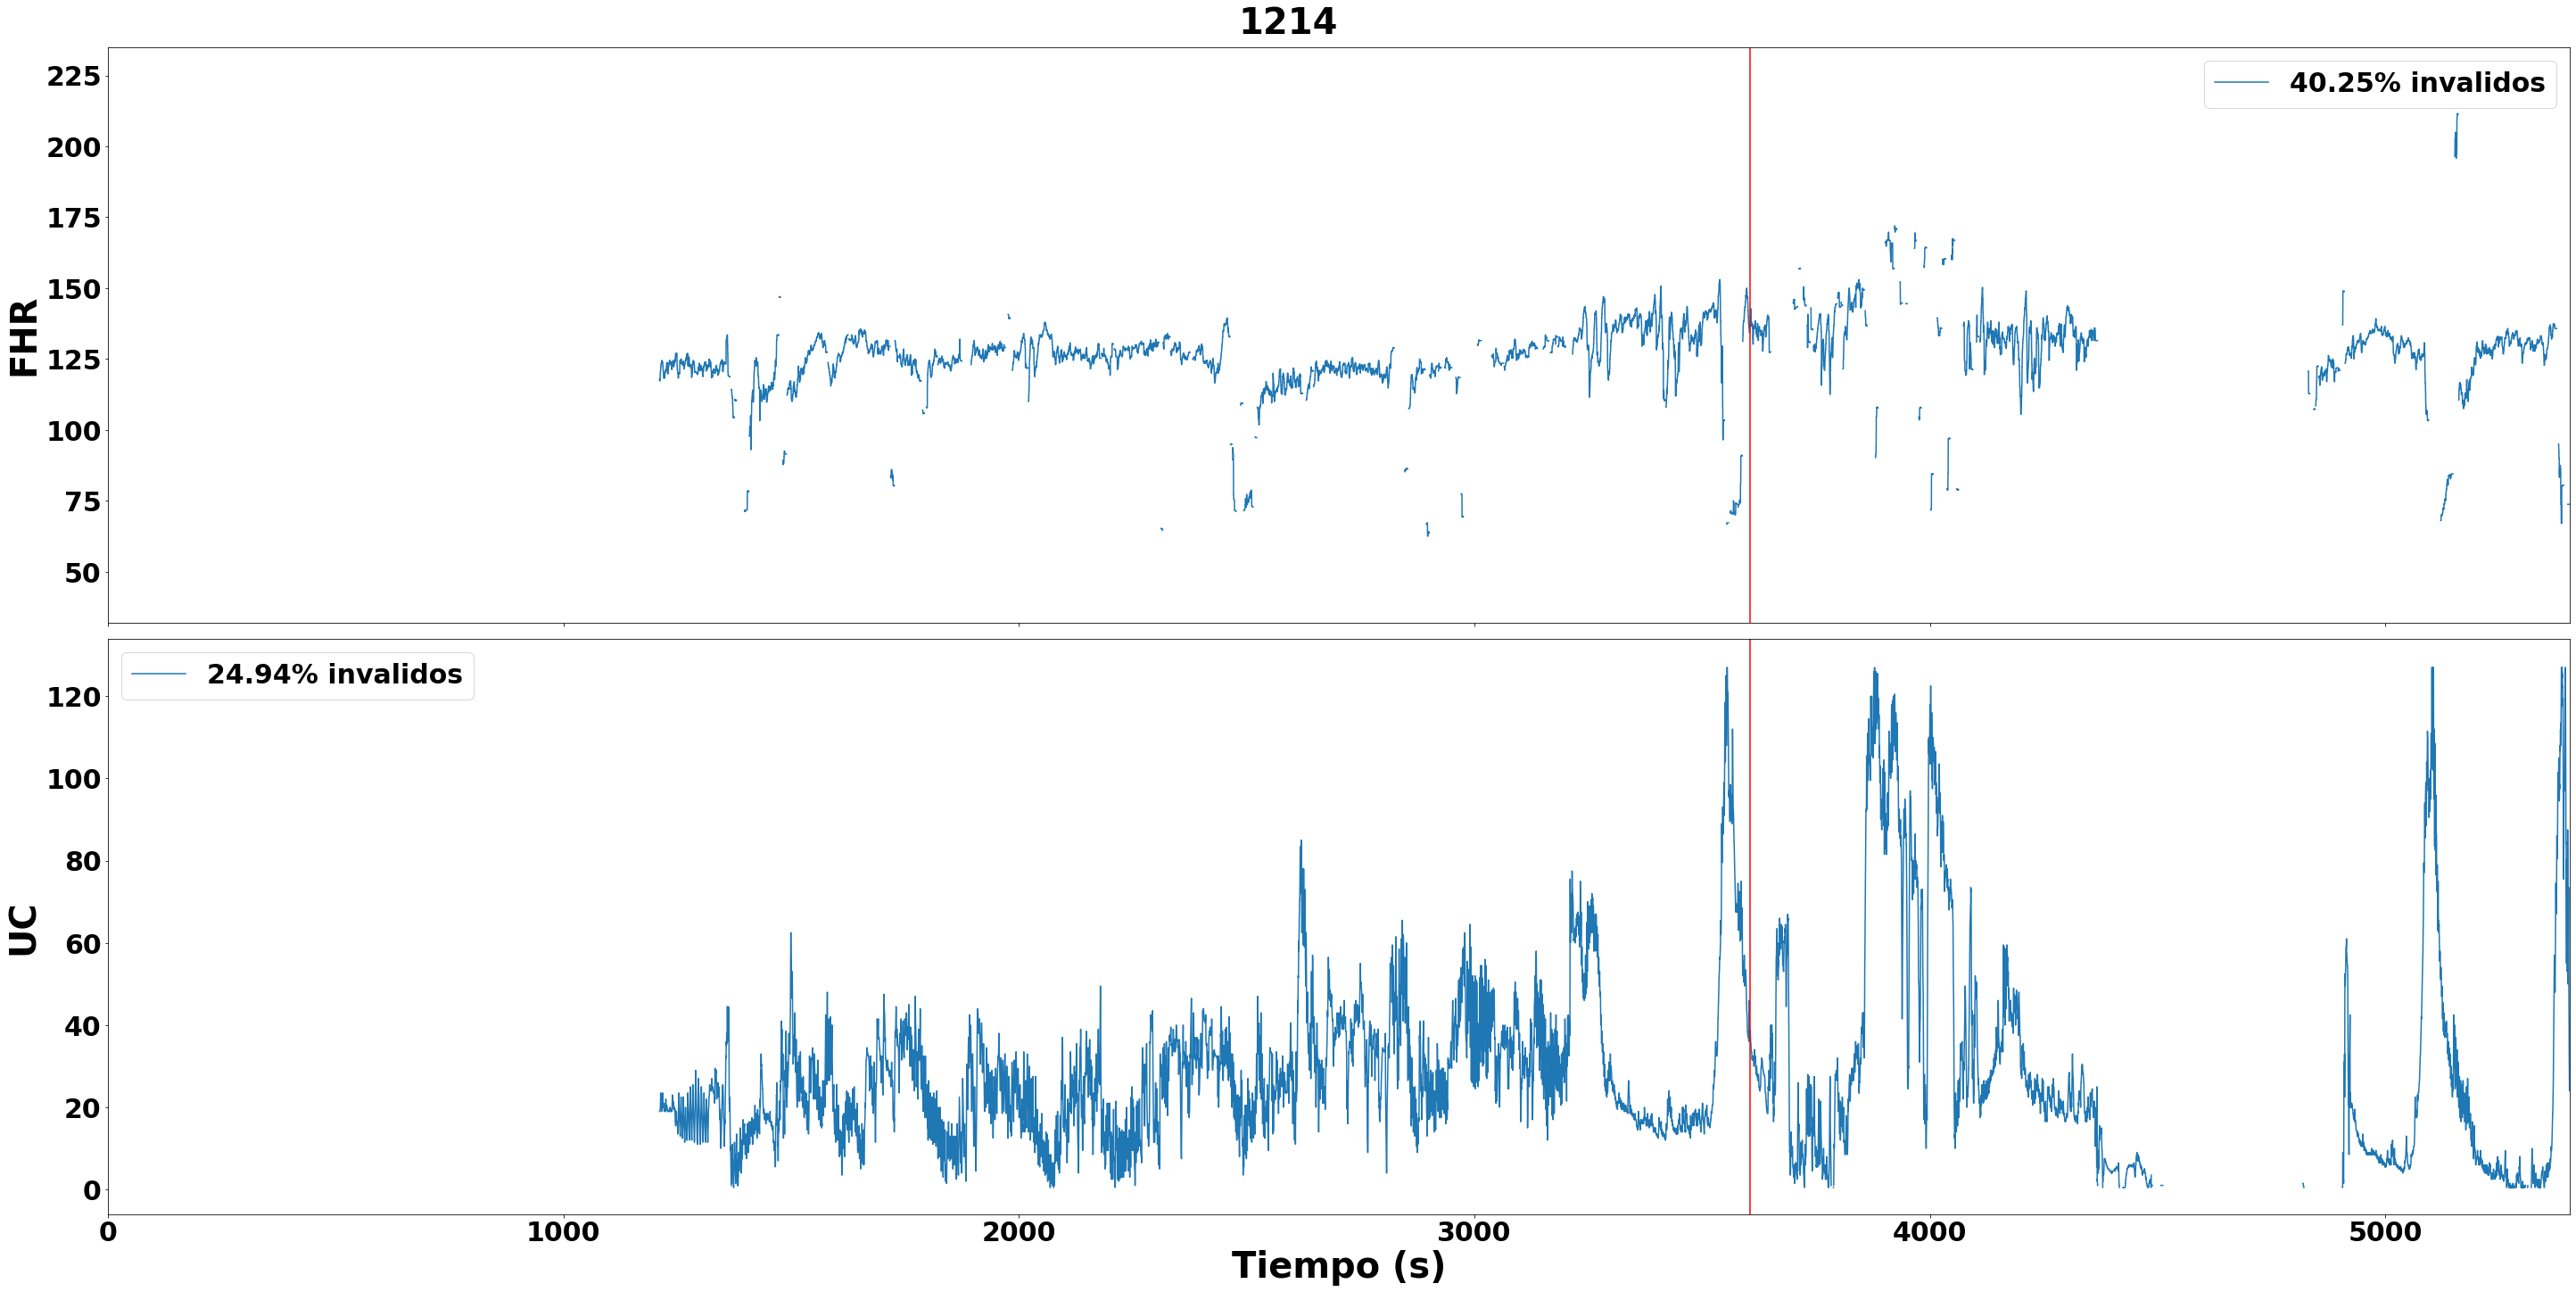

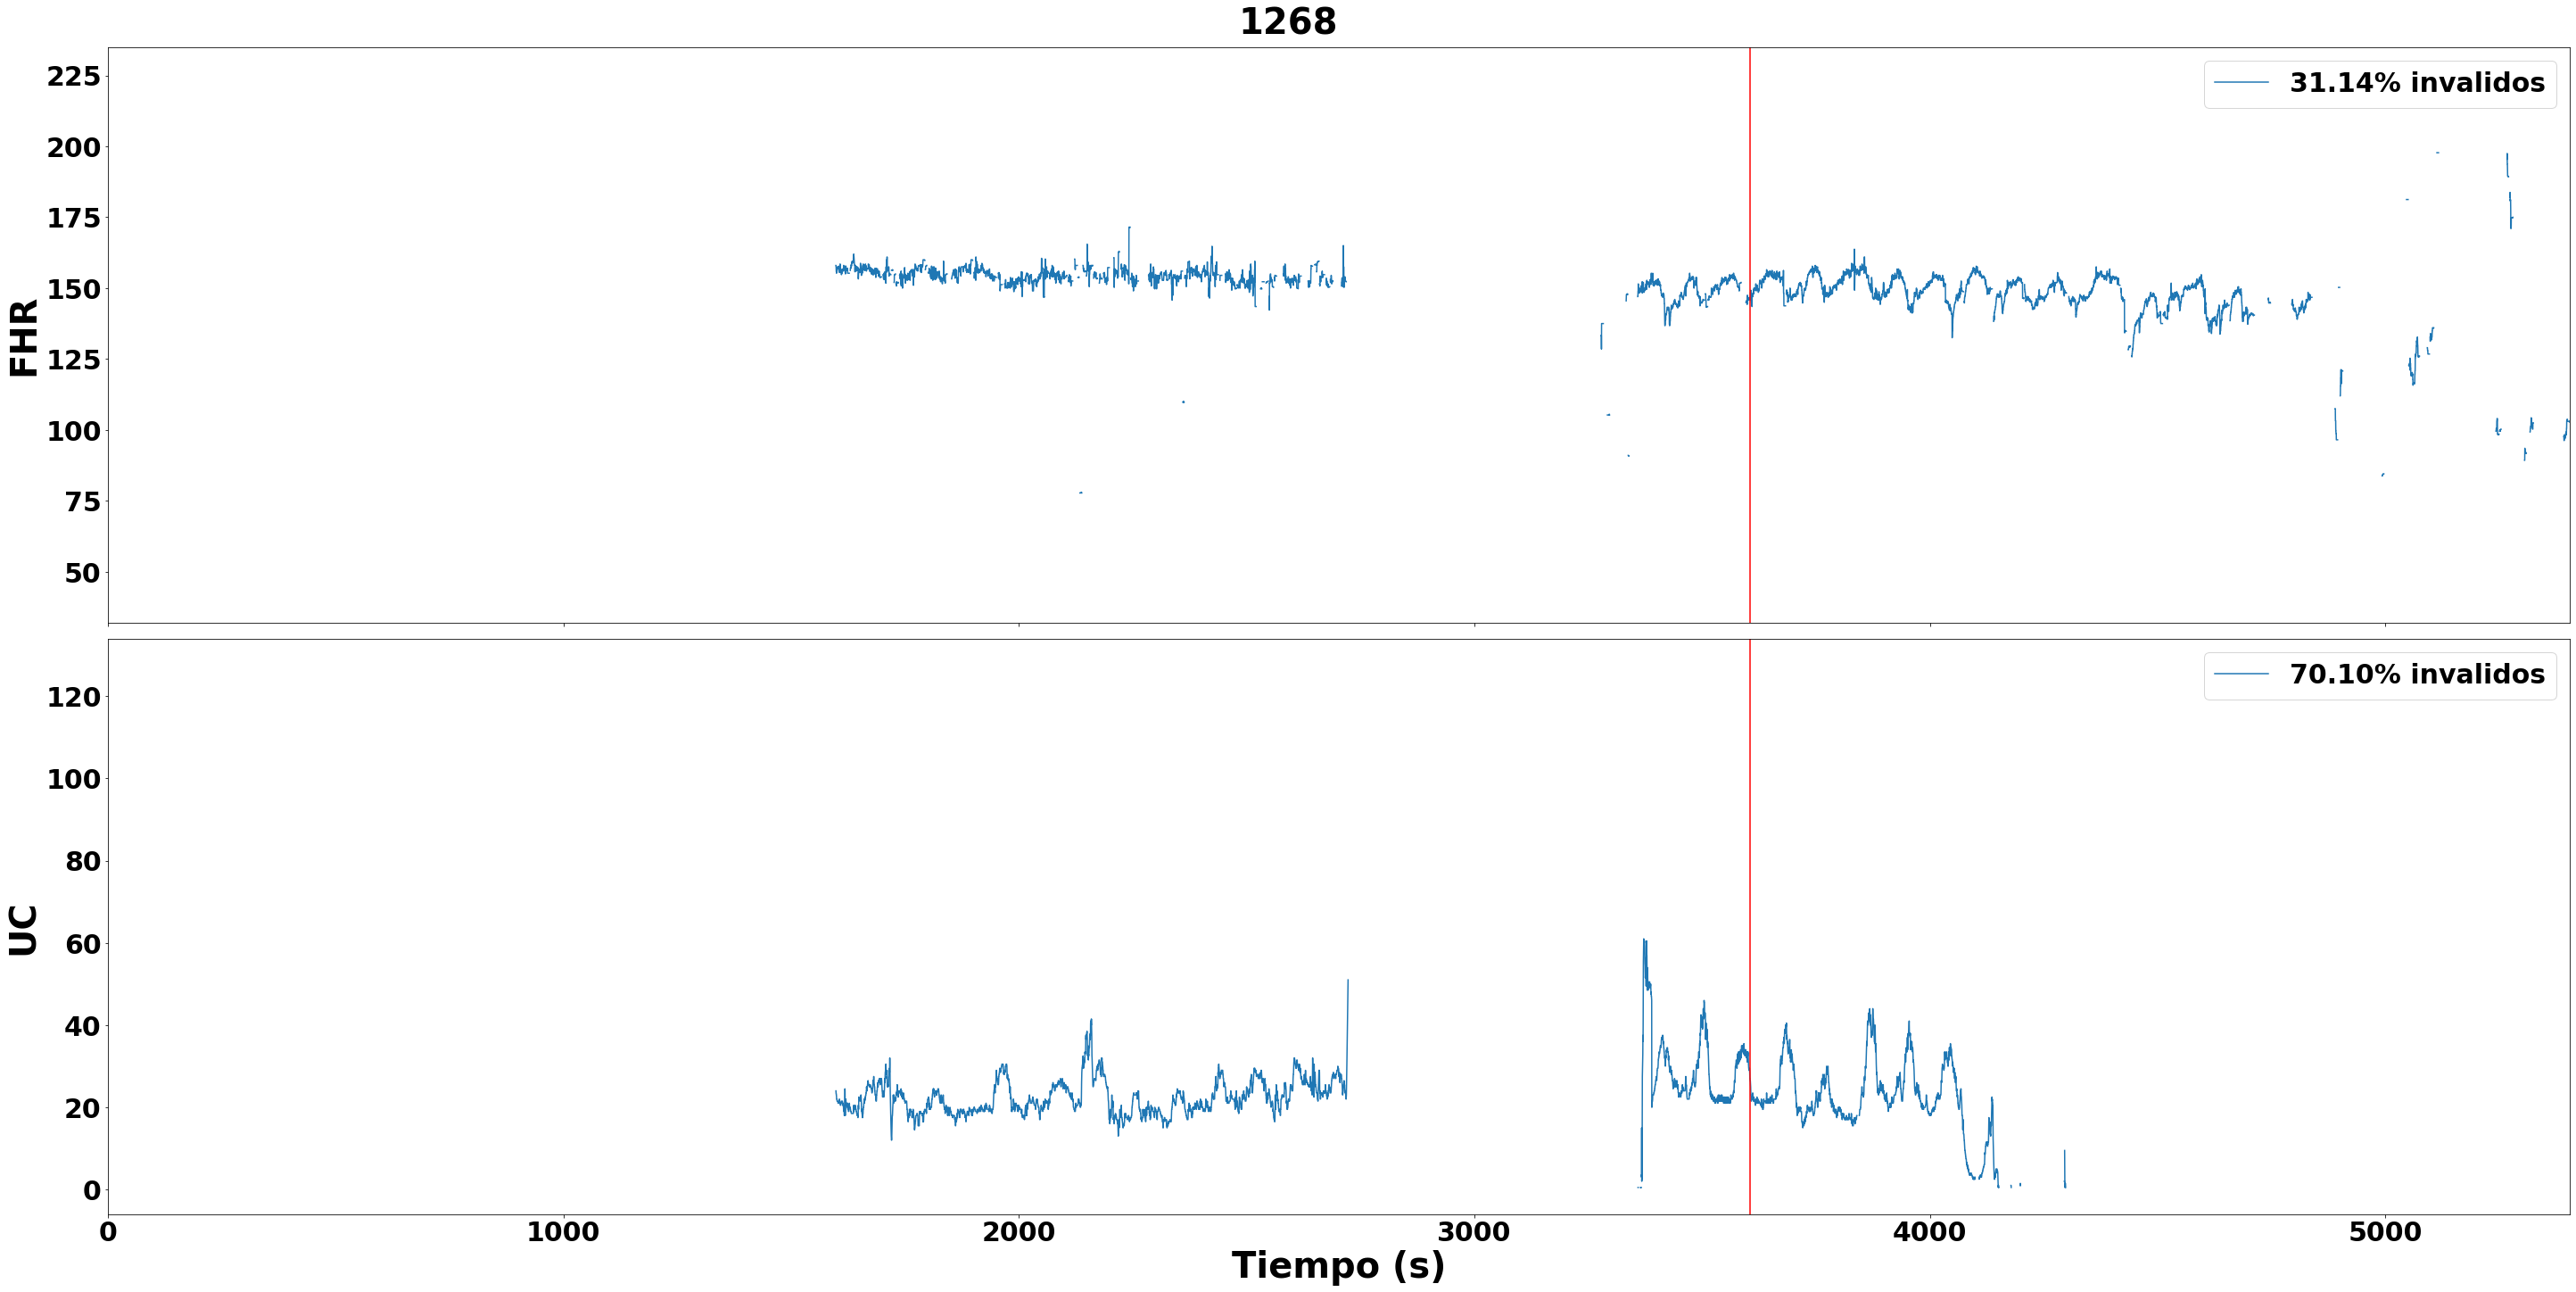

In [160]:
for idx in [1016, 1214, 1268]:
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(40, 20), sharex='all', constrained_layout=True)
    fhr_signal = fhr_clean.loc[idx]
    uc_signal = uc_clean.loc[idx]
    y_signal = y_clean.loc[idx]

    ax[0].plot(fhr_signal.index, fhr_signal.values, label=f'{fhr_nans_percent.loc[idx]:.2f}% invalidos')
    ax[1].plot(uc_signal.index, uc_signal.values, label=f'{uc_nans_percent.loc[idx]:.2f}% invalidos')

    ax[1].set_xlabel('Tiempo (s)', fontsize=xlabel_font_size * 2)
    ax[0].set_ylabel('FHR', fontsize=xlabel_font_size * 2)
    ax[1].set_ylabel('UC', fontsize=xlabel_font_size * 2)

    for _ax in ax:
        _ax.axvline(x=max(fhr_signal.index) - 30 * 60, color='red')

    ax[0].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * 2)
    ax[1].tick_params(axis='both', which='major', labelsize=both_ticks_label_size * 2)

    ax[0].set_ylim((32, 235))
    ax[1].set_ylim((-6, 134))
    ax[1].set_xlim((0, 5405))
    ax[0].legend(fontsize=legend_font_size * 2)
    ax[1].legend(fontsize=legend_font_size * 2)

    fig.suptitle(f"{idx}", fontsize=40)
    fig.savefig(f"{paths.PLOTS_MEMORIA_PATH}/4_1_filtered_{idx}_example.pdf")

In [129]:
fhr.iloc[0].index

Float64Index([    0.0,    0.25,     0.5,    0.75,     1.0,    1.25,     1.5,
                 1.75,     2.0,    2.25,
              ...
               5402.5, 5402.75,  5403.0, 5403.25,  5403.5, 5403.75,  5404.0,
              5404.25,  5404.5, 5404.75],
             dtype='float64', length=21620)